In [1]:
import numpy as np
import pandas as pd
import random
from numpy.random import seed
seed(125)
from tensorflow import set_random_seed
set_random_seed(125)
import keras
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


### Why set seed? - Reproducible results

For the sake of reproducibility and to compare models we want the exact same result every time the same network is trained on the same data.

The most robust way to report results and compare models is to repeat your experiment many times (30+) and use summary statistics.

Neural networks use randomness by design to ensure they effectively learn the function being approximated for the problem.

Randomness is used in initialization network weights. Although randomness can be used in other areas, such as:

* Randomness in Regularization, such as dropout.
* Randomness in Layers, such as word embedding.
* Randomness in Optimization, such as stochastic optimization.

In [0]:
# FASHION_MNIST class

class FASHION_MNIST():
  
    def __init__(self,
                 img_rows=28,            # Number of pixels rows in image
                 img_cols=28,            # Number of pixels columns in image
                 num_classes=10,         # Number of label classes
                 l1_out=32,              # Number of convolution filters to use in first convolution
                 l2_out=32,              # Number of convolution filters to use in second convolution
                 l3_out=32,             # Number of convolution filters to use in third convolution
                 l4_out=32,             # Dimensionality of the output space for first dense layer
                 l1_drop=0.0,           # Dropout rate l1 - fraction of input units to drop in first convolution layer
                 l2_drop=0.0,           # Dropout rate l2 - fraction of input units to drop in second convolution layer
                 l3_drop=0.0,            # Dropout rate l3 - fraction of input units to drop in third convolution layer
                 l4_drop=0.0,            # Dropout rate l4 - fraction of input units to drop in first dense layer
                 batch_size=64,         # Number of samples per gradient update
                 patience=5,             # Stop training when loss stops improving after 10 epochs
                 epochs=50,              # An epoch is an iteration over the entire x and y data provided
                 validation_split=0.2):  # Fraction of the training data to be used as validation data
      
        self.__img_rows = img_rows
        self.__img_cols = img_cols
        self.__num_classes = num_classes
        self.l1_out = l1_out
        self.l2_out = l2_out
        self.l3_out = l3_out
        self.l4_out = l4_out
        self.l1_drop = l1_drop
        self.l2_drop = l2_drop
        self.l3_drop = l3_drop
        self.l4_drop = l4_drop        
        self.batch_size = batch_size
        self.patience = patience
        self.epochs = epochs
        self.validation_split = validation_split
        self.__X_train, self.__X_test, self.__y_train, self.__y_test = self.load_process_data()
        self.__model = self.fashion_mnist_model()
        

    # load and process Fashion MNIST data (can load from Keras)  
    def load_process_data(self):
      
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

        # Preprocess input data for Keras

        # Each image is 28x28 pixels
        # Specify input shape sutable for Keras to be used as input image dimensions
        input_shape = (self.__img_rows, self.__img_cols, 1)

        # When using the TensorFlow backend, you must explicitly declare a dimension for the depth of the input image. 
        # For example, a full-color image with all 3 RGB channels will have a depth of 3
        # As the fashion mnist images are in black and white, only have a depth of 1

        # Reshape input data
        # Want to transform the dataset from having shape (n, width, height) to (n, width, height, depth)
        X_train = X_train.reshape(X_train.shape[0], self.__img_rows, self.__img_rows, 1)
        X_test = X_test.reshape(X_test.shape[0], self.__img_rows, self.__img_cols, 1)

        # Convert input data to float32
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        # Normalize data values to the range [0,1]
        # note: Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black)
        X_train /= 255
        X_test /= 255

        # For the output, we change number to one-hot vector. 
        y_train = to_categorical(y_train, 10)
        y_test = to_categorical(y_test, 10)

        return X_train, X_test, y_train, y_test

      
    # specify Fashion MNIST model architecture
    def fashion_mnist_model(self):
      
        model = Sequential()        
        
        # First convolution layer
        model.add(Conv2D(filters=self.l1_out, 
                         kernel_size=(3, 3),
                         kernel_initializer='he_normal',
                         input_shape=(self.__img_rows, self.__img_cols, 1)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(self.l1_drop))

        # Second convolution layer
        model.add(Conv2D(filters=self.l2_out, 
                         kernel_size=(3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(self.l2_drop))
        
        # Third convolution layer
        model.add(Conv2D(filters=self.l3_out, 
                         kernel_size=(3, 3)))
        model.add(Activation('relu'))
        model.add(Dropout(self.l3_drop))

        # First dense layer
        model.add(Flatten())
        model.add(Dense(units=self.l4_out))
        model.add(Activation('relu'))
        model.add(Dropout(self.l4_drop))
        
        # Second dense layer
        model.add(Dense(self.__num_classes))
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
        
        return model

    
    # fit mnist model
    def fit(self):
      
        """
        Returns:
        A History object. Its History.history attribute is a record of training loss values 
        and metrics values at successive epochs, as well as validation loss values 
        and validation metrics values (if applicable).
        """
      
        early_stopping = EarlyStopping(patience=self.patience, verbose=1)
        
        history = self.__model.fit(self.__X_train, self.__y_train,
                                     batch_size=self.batch_size,
                                     epochs=self.epochs,
                                     verbose=1,
                                     validation_split=self.validation_split,
                                     callbacks=[early_stopping])
        
        return history
    
    
    # evaluate mnist model
    def evaluate(self):
      
        history = self.fit()
        
        evaluation = self.__model.evaluate(self.__X_test,
                                           self.__y_test,
                                           batch_size=self.batch_size,
                                           verbose=0)
        
        return evaluation, history
      
      

### Run Basic model

In [0]:
 # Function to run FASHION_MNIST class

def run_fashion_mnist(img_rows=28, 
                      img_cols=28,
                      num_classes=10,
                      l1_out=32,
                      l2_out=32,
                      l3_out=32,
                      l4_out=32,
                      l1_drop=0.0,
                      l2_drop=0.0,
                      l3_drop=0.0,
                      l4_drop=0.0,
                      batch_size=64,
                      patience=5,
                      epochs=50, 
                      validation_split=0.2):
    
    fashion_mnist = FASHION_MNIST(img_rows= img_rows,
                                  img_cols = img_cols,
                                  num_classes = num_classes,
                                  l1_out=l1_out,
                                  l2_out=l2_out,
                                  l3_out=l3_out,
                                  l4_out=l4_out,
                                  l1_drop=l1_drop,
                                  l2_drop=l2_drop,
                                  l3_drop=l3_drop,
                                  l4_drop=l4_drop,
                                  batch_size=batch_size,
                                  patience=patience,
                                  epochs=epochs,
                                  validation_split=validation_split)
    
    evaluation, history = fashion_mnist.evaluate()
    
    return evaluation, history  

In [12]:
evaluation, history = run_fashion_mnist()

# Wall time: 2min 36s

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 9s 183us/step - loss: 0.6000 - acc: 0.7791 - val_loss: 0.4489 - val_acc: 0.8345
Epoch 2/50
48000/48000 [==============================] - 8s 175us/step - loss: 0.3854 - acc: 0.8612 - val_loss: 0.3554 - val_acc: 0.8748
Epoch 3/50
28544/48000 [================>.............] - ETA: 3s - loss: 0.3352 - acc: 0.8786

48000/48000 [==============================] - 8s 176us/step - loss: 0.3301 - acc: 0.8809 - val_loss: 0.3350 - val_acc: 0.8768
Epoch 4/50
48000/48000 [==============================] - 8s 175us/step - loss: 0.3011 - acc: 0.8910 - val_loss: 0.3221 - val_acc: 0.8834
Epoch 5/50
48000/48000 [==============================] - 8s 175us/step - loss: 0.2791 - acc: 0.8988 - val_loss: 0.3039 - val_acc: 0.8920
Epoch 6/50
 5952/48000 [==>...........................] - ETA: 6s - loss: 0.2524 - acc: 0.9074

48000/48000 [==============================] - 8s 175us/step - loss: 0.2599 - acc: 0.9053 - val_loss: 0.3110 - val_acc: 0.8915
Epoch 7/50
48000/48000 [==============================] - 8s 176us/step - loss: 0.2443 - acc: 0.9115 - val_loss: 0.2806 - val_acc: 0.8994
Epoch 8/50
48000/48000 [==============================] - 8s 175us/step - loss: 0.2301 - acc: 0.9162 - val_loss: 0.2819 - val_acc: 0.8991
Epoch 9/50
 2368/48000 [>.............................] - ETA: 7s - loss: 0.2176 - acc: 0.9181

48000/48000 [==============================] - 8s 173us/step - loss: 0.2193 - acc: 0.9196 - val_loss: 0.2807 - val_acc: 0.9001
Epoch 10/50
48000/48000 [==============================] - 8s 174us/step - loss: 0.2078 - acc: 0.9244 - val_loss: 0.2764 - val_acc: 0.9042
Epoch 11/50
48000/48000 [==============================] - 8s 175us/step - loss: 0.1993 - acc: 0.9270 - val_loss: 0.2820 - val_acc: 0.8998
Epoch 12/50
 2112/48000 [>.............................] - ETA: 7s - loss: 0.1896 - acc: 0.9280

48000/48000 [==============================] - 8s 175us/step - loss: 0.1901 - acc: 0.9296 - val_loss: 0.2769 - val_acc: 0.9022
Epoch 13/50
48000/48000 [==============================] - 8s 174us/step - loss: 0.1796 - acc: 0.9344 - val_loss: 0.2970 - val_acc: 0.9017
Epoch 14/50
48000/48000 [==============================] - 8s 175us/step - loss: 0.1722 - acc: 0.9367 - val_loss: 0.2737 - val_acc: 0.9072
Epoch 15/50
 1728/48000 [>.............................] - ETA: 7s - loss: 0.1772 - acc: 0.9323

48000/48000 [==============================] - 8s 174us/step - loss: 0.1659 - acc: 0.9385 - val_loss: 0.2823 - val_acc: 0.9070
Epoch 16/50
48000/48000 [==============================] - 8s 174us/step - loss: 0.1549 - acc: 0.9420 - val_loss: 0.3017 - val_acc: 0.9036
Epoch 17/50
48000/48000 [==============================] - 8s 174us/step - loss: 0.1503 - acc: 0.9451 - val_loss: 0.3128 - val_acc: 0.8982
Epoch 18/50
 1664/48000 [>.............................] - ETA: 7s - loss: 0.1279 - acc: 0.9591

48000/48000 [==============================] - 8s 176us/step - loss: 0.1434 - acc: 0.9472 - val_loss: 0.3038 - val_acc: 0.9044
Epoch 19/50
48000/48000 [==============================] - 8s 176us/step - loss: 0.1381 - acc: 0.9485 - val_loss: 0.3297 - val_acc: 0.8997
Epoch 00019: early stopping


In [13]:
print('TEST LOSS:', evaluation[0])
print('TEST ACCURACY:', evaluation[1])

# TEST LOSS: 0.3528409385681152
# TEST ACCURACY: 0.8973

TEST LOSS: 0.3528409385681152
TEST ACCURACY: 0.8973


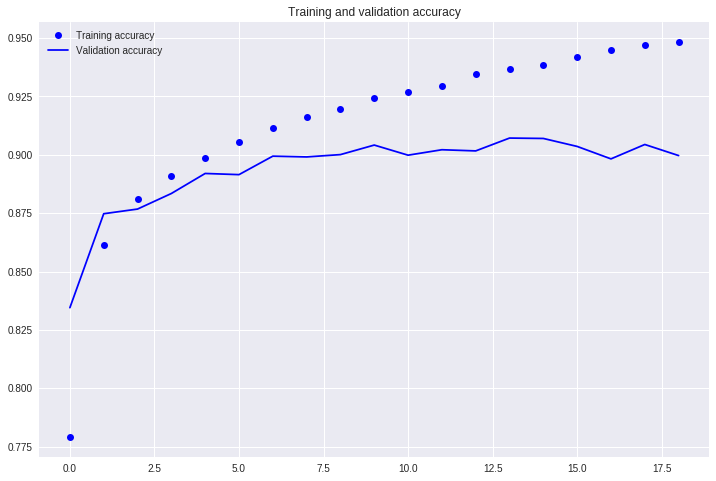

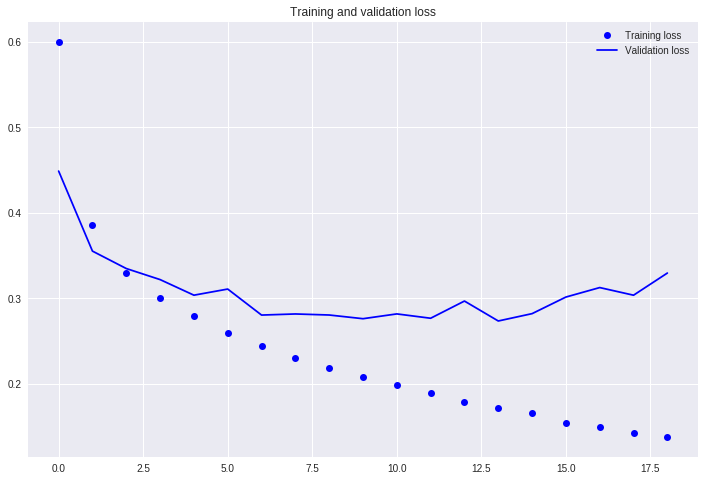

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(12, 8))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Bayesian Optimization

Install and import GPyOpt

http://sheffieldml.github.io/GPyOpt/

In [17]:
! pip install GPy
! pip install gpyopt

    100% |████████████████████████████████| 860kB 9.3MB/s 
    100% |████████████████████████████████| 71kB 9.2MB/s 
  Running setup.py bdist_wheel for GPy ... - \ | / - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/36/b9/13/498e283b6081c81aded82d1c174f8c251096027be686e79005
  Running setup.py bdist_wheel for paramz ... - \ done
  Stored in directory: /content/.cache/pip/wheels/17/72/fe/035ce71322865ed7de8a98cac33e65f464dcc2bcbcf93cf642
Successfully built GPy paramz
    100% |████████████████████████████████| 61kB 4.2MB/s 
  Running setup.py bdist_wheel for gpyopt ... - \ done
  Stored in directory: /content/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
Successfully built gpyopt


In [0]:
import GPy, GPyOpt

In [0]:
# Specify bounds for hyperparameters

# bounds dict should be in order of continuous type and then discrete type

bounds = [{'name': 'validation_split', 'type': 'continuous',  'domain': (0.0, 0.3)},
          {'name': 'l1_drop',          'type': 'continuous',  'domain': (0.0, 0.5)},
          {'name': 'l2_drop',          'type': 'continuous',  'domain': (0.0, 0.5)},
          {'name': 'l3_drop',          'type': 'continuous',  'domain': (0.0, 0.5)},
          {'name': 'l4_drop',          'type': 'continuous',  'domain': (0.0, 0.5)},
          {'name': 'l1_out',           'type': 'discrete',    'domain': (16, 32, 64, 128, 256, 512)},
          {'name': 'l2_out',           'type': 'discrete',    'domain': (32, 64, 128, 256, 512, 1024)},
          {'name': 'l3_out',           'type': 'discrete',    'domain': (32, 64, 128, 256, 512, 1024)},
          {'name': 'l4_out',           'type': 'discrete',    'domain': (32, 64, 128, 256, 512, 1024)},
          {'name': 'batch_size',       'type': 'discrete',    'domain': (64, 128, 256, 512)},
          {'name': 'patience',         'type': 'discrete',    'domain': (4, 5, 6, 7, 8)}]

In [0]:
# function to optimize fashion mnist model

def f(x):
  
    print(x)
    
    evaluation = run_fashion_mnist(
        img_rows=28, 
        img_cols=28,
        num_classes=10,
        l1_out = int(x[:,5]),
        l2_out = int(x[:,6]),
        l3_out = int(x[:,7]),
        l4_out = int(x[:,8]),
        l1_drop = float(x[:,1]),
        l2_drop = float(x[:,2]),
        l3_drop = float(x[:,3]),
        l4_drop = float(x[:,4]),
        batch_size = int(x[:,9]),
        patience = int(x[:,10]),
        epochs=50,
        validation_split = float(x[:,0]))
    
    print("TEST LOSS: {} \t TEST ACCURACY: {}".format(evaluation[0][0], evaluation[0][1]))
    print(evaluation[0], "\n")
        
    return evaluation[0][0]

### Optimizer instance

In [21]:
# optimizer


# Initialize the Bayesian Optimization method with 5 instances.

# f: function to optimize
### should take 2-dimensional numpy arrays as input and return 2-dimensional outputs 
# domain: 
### list of dictionaries containing the description of the inputs variables 

optimize_fashion_mnist = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, acquisition_type='EI', exact_feval = True) # Selects the Expected improvement

# Wall time: 1h 55min 34s

[[8.78036607e-02 9.53412966e-02 4.85372173e-01 1.26727354e-01
  7.27212560e-02 1.28000000e+02 3.20000000e+01 1.28000000e+02
  1.28000000e+02 5.12000000e+02 5.00000000e+00]]
Train on 54731 samples, validate on 5269 samples
Epoch 1/50
54731/54731 [==============================] - 8s 146us/step - loss: 0.8946 - acc: 0.6691 - val_loss: 0.4746 - val_acc: 0.8279
Epoch 2/50
54731/54731 [==============================] - 7s 128us/step - loss: 0.5172 - acc: 0.8072 - val_loss: 0.4199 - val_acc: 0.8449
Epoch 3/50
14336/54731 [======>.......................] - ETA: 4s - loss: 0.4673 - acc: 0.8260

54731/54731 [==============================] - 7s 127us/step - loss: 0.4522 - acc: 0.8317 - val_loss: 0.3597 - val_acc: 0.8711
Epoch 4/50
54731/54731 [==============================] - 7s 128us/step - loss: 0.4104 - acc: 0.8496 - val_loss: 0.3436 - val_acc: 0.8763
Epoch 5/50
54731/54731 [==============================] - 7s 127us/step - loss: 0.3823 - acc: 0.8596 - val_loss: 0.3122 - val_acc: 0.8842
Epoch 6/50
31232/54731 [================>.............] - ETA: 2s - loss: 0.3702 - acc: 0.8619

54731/54731 [==============================] - 7s 128us/step - loss: 0.3684 - acc: 0.8627 - val_loss: 0.3167 - val_acc: 0.8838
Epoch 7/50
54731/54731 [==============================] - 7s 127us/step - loss: 0.3501 - acc: 0.8704 - val_loss: 0.3098 - val_acc: 0.8823
Epoch 8/50
54731/54731 [==============================] - 7s 128us/step - loss: 0.3329 - acc: 0.8768 - val_loss: 0.2877 - val_acc: 0.8939
Epoch 9/50
33280/54731 [=================>............] - ETA: 2s - loss: 0.3227 - acc: 0.8797

54731/54731 [==============================] - 7s 128us/step - loss: 0.3234 - acc: 0.8794 - val_loss: 0.2721 - val_acc: 0.8973
Epoch 10/50
54731/54731 [==============================] - 7s 128us/step - loss: 0.3128 - acc: 0.8827 - val_loss: 0.2639 - val_acc: 0.9000
Epoch 11/50
54731/54731 [==============================] - 7s 129us/step - loss: 0.3049 - acc: 0.8867 - val_loss: 0.2539 - val_acc: 0.9080
Epoch 12/50
33792/54731 [=================>............] - ETA: 2s - loss: 0.2953 - acc: 0.8891

54731/54731 [==============================] - 7s 129us/step - loss: 0.2943 - acc: 0.8901 - val_loss: 0.2522 - val_acc: 0.9064
Epoch 13/50
54731/54731 [==============================] - 7s 128us/step - loss: 0.2909 - acc: 0.8916 - val_loss: 0.2790 - val_acc: 0.8930
Epoch 14/50
54731/54731 [==============================] - 7s 128us/step - loss: 0.2805 - acc: 0.8956 - val_loss: 0.2405 - val_acc: 0.9100
Epoch 15/50
34304/54731 [=================>............] - ETA: 2s - loss: 0.2774 - acc: 0.8950

54731/54731 [==============================] - 7s 128us/step - loss: 0.2783 - acc: 0.8947 - val_loss: 0.2472 - val_acc: 0.9059
Epoch 16/50
54731/54731 [==============================] - 7s 129us/step - loss: 0.2741 - acc: 0.8974 - val_loss: 0.2369 - val_acc: 0.9119
Epoch 17/50
54731/54731 [==============================] - 7s 129us/step - loss: 0.2667 - acc: 0.8992 - val_loss: 0.2361 - val_acc: 0.9110
Epoch 18/50
32768/54731 [================>.............] - ETA: 2s - loss: 0.2587 - acc: 0.9031

54731/54731 [==============================] - 7s 128us/step - loss: 0.2602 - acc: 0.9024 - val_loss: 0.2272 - val_acc: 0.9148
Epoch 19/50
54731/54731 [==============================] - 7s 129us/step - loss: 0.2592 - acc: 0.9038 - val_loss: 0.2266 - val_acc: 0.9159
Epoch 20/50
54731/54731 [==============================] - 7s 127us/step - loss: 0.2549 - acc: 0.9039 - val_loss: 0.2209 - val_acc: 0.9154
Epoch 21/50
34304/54731 [=================>............] - ETA: 2s - loss: 0.2501 - acc: 0.9053

54731/54731 [==============================] - 7s 126us/step - loss: 0.2481 - acc: 0.9067 - val_loss: 0.2231 - val_acc: 0.9163
Epoch 22/50
54731/54731 [==============================] - 7s 127us/step - loss: 0.2467 - acc: 0.9072 - val_loss: 0.2193 - val_acc: 0.9174
Epoch 23/50
54731/54731 [==============================] - 7s 125us/step - loss: 0.2462 - acc: 0.9073 - val_loss: 0.2212 - val_acc: 0.9171
Epoch 24/50
34816/54731 [==================>...........] - ETA: 2s - loss: 0.2391 - acc: 0.9099

54731/54731 [==============================] - 7s 126us/step - loss: 0.2408 - acc: 0.9093 - val_loss: 0.2138 - val_acc: 0.9226
Epoch 25/50
54731/54731 [==============================] - 7s 126us/step - loss: 0.2400 - acc: 0.9093 - val_loss: 0.2204 - val_acc: 0.9195
Epoch 26/50
54731/54731 [==============================] - 7s 126us/step - loss: 0.2378 - acc: 0.9108 - val_loss: 0.2166 - val_acc: 0.9209
Epoch 27/50
34304/54731 [=================>............] - ETA: 2s - loss: 0.2258 - acc: 0.9152

54731/54731 [==============================] - 7s 128us/step - loss: 0.2331 - acc: 0.9124 - val_loss: 0.2122 - val_acc: 0.9224
Epoch 28/50
54731/54731 [==============================] - 7s 127us/step - loss: 0.2302 - acc: 0.9132 - val_loss: 0.2125 - val_acc: 0.9224
Epoch 29/50
54731/54731 [==============================] - 7s 127us/step - loss: 0.2299 - acc: 0.9125 - val_loss: 0.2139 - val_acc: 0.9247
Epoch 30/50
34816/54731 [==================>...........] - ETA: 2s - loss: 0.2267 - acc: 0.9146

54731/54731 [==============================] - 7s 125us/step - loss: 0.2260 - acc: 0.9153 - val_loss: 0.2115 - val_acc: 0.9224
Epoch 31/50
54731/54731 [==============================] - 7s 126us/step - loss: 0.2280 - acc: 0.9143 - val_loss: 0.2013 - val_acc: 0.9266
Epoch 32/50
54731/54731 [==============================] - 7s 125us/step - loss: 0.2220 - acc: 0.9174 - val_loss: 0.2074 - val_acc: 0.9231
Epoch 33/50
34816/54731 [==================>...........] - ETA: 2s - loss: 0.2170 - acc: 0.9179

54731/54731 [==============================] - 7s 125us/step - loss: 0.2184 - acc: 0.9168 - val_loss: 0.2072 - val_acc: 0.9222
Epoch 34/50
54731/54731 [==============================] - 7s 126us/step - loss: 0.2184 - acc: 0.9179 - val_loss: 0.2144 - val_acc: 0.9197
Epoch 35/50
54731/54731 [==============================] - 7s 125us/step - loss: 0.2176 - acc: 0.9173 - val_loss: 0.2025 - val_acc: 0.9241
Epoch 36/50
34816/54731 [==================>...........] - ETA: 2s - loss: 0.2153 - acc: 0.9193

54731/54731 [==============================] - 7s 126us/step - loss: 0.2156 - acc: 0.9181 - val_loss: 0.2105 - val_acc: 0.9188
Epoch 00036: early stopping
TEST LOSS: 0.2235534798383713 	 TEST ACCURACY: 0.9173999999046326
[0.2235534798383713, 0.9173999999046326] 

[[2.85428654e-01 2.41809552e-01 3.41749205e-01 3.35766438e-01
  3.21760587e-01 1.28000000e+02 1.28000000e+02 5.12000000e+02
  2.56000000e+02 2.56000000e+02 6.00000000e+00]]
Train on 42874 samples, validate on 17126 samples
Epoch 1/50
41984/42874 [============================>.] - ETA: 0s - loss: 0.6594 - acc: 0.7550

42874/42874 [==============================] - 11s 265us/step - loss: 0.6552 - acc: 0.7568 - val_loss: 0.4084 - val_acc: 0.8529
Epoch 2/50
42874/42874 [==============================] - 10s 234us/step - loss: 0.4077 - acc: 0.8490 - val_loss: 0.3330 - val_acc: 0.8773
Epoch 3/50
42874/42874 [==============================] - 10s 233us/step - loss: 0.3489 - acc: 0.8716 - val_loss: 0.3049 - val_acc: 0.8882
Epoch 4/50
  768/42874 [..............................] - ETA: 8s - loss: 0.3232 - acc: 0.8750

42874/42874 [==============================] - 10s 232us/step - loss: 0.3175 - acc: 0.8825 - val_loss: 0.2850 - val_acc: 0.8943
Epoch 5/50
42874/42874 [==============================] - 10s 234us/step - loss: 0.2954 - acc: 0.8927 - val_loss: 0.2722 - val_acc: 0.9017
Epoch 6/50
34560/42874 [=======================>......] - ETA: 1s - loss: 0.2732 - acc: 0.8995

42874/42874 [==============================] - 10s 233us/step - loss: 0.2727 - acc: 0.8995 - val_loss: 0.2519 - val_acc: 0.9089
Epoch 7/50
42874/42874 [==============================] - 10s 233us/step - loss: 0.2571 - acc: 0.9035 - val_loss: 0.2614 - val_acc: 0.9020
Epoch 8/50
42240/42874 [============================>.] - ETA: 0s - loss: 0.2457 - acc: 0.9079

42874/42874 [==============================] - 10s 233us/step - loss: 0.2457 - acc: 0.9078 - val_loss: 0.2386 - val_acc: 0.9121
Epoch 9/50
42874/42874 [==============================] - 10s 232us/step - loss: 0.2316 - acc: 0.9140 - val_loss: 0.2385 - val_acc: 0.9096
Epoch 10/50
42874/42874 [==============================] - 10s 233us/step - loss: 0.2223 - acc: 0.9158 - val_loss: 0.2299 - val_acc: 0.9166
Epoch 11/50
  512/42874 [..............................] - ETA: 9s - loss: 0.1627 - acc: 0.9414

42874/42874 [==============================] - 10s 233us/step - loss: 0.2123 - acc: 0.9195 - val_loss: 0.2317 - val_acc: 0.9176
Epoch 12/50
42874/42874 [==============================] - 10s 233us/step - loss: 0.2047 - acc: 0.9230 - val_loss: 0.2279 - val_acc: 0.9177
Epoch 13/50
34048/42874 [======================>.......] - ETA: 1s - loss: 0.1934 - acc: 0.9262

42874/42874 [==============================] - 10s 235us/step - loss: 0.1950 - acc: 0.9256 - val_loss: 0.2213 - val_acc: 0.9201
Epoch 14/50
42874/42874 [==============================] - 10s 232us/step - loss: 0.1876 - acc: 0.9291 - val_loss: 0.2185 - val_acc: 0.9227
Epoch 15/50
41728/42874 [============================>.] - ETA: 0s - loss: 0.1793 - acc: 0.9317

42874/42874 [==============================] - 10s 234us/step - loss: 0.1797 - acc: 0.9315 - val_loss: 0.2207 - val_acc: 0.9218
Epoch 16/50
42874/42874 [==============================] - 10s 234us/step - loss: 0.1740 - acc: 0.9357 - val_loss: 0.2255 - val_acc: 0.9180
Epoch 17/50
42874/42874 [==============================] - 10s 236us/step - loss: 0.1667 - acc: 0.9363 - val_loss: 0.2263 - val_acc: 0.9208
Epoch 18/50
  256/42874 [..............................] - ETA: 9s - loss: 0.1507 - acc: 0.9375

42874/42874 [==============================] - 10s 236us/step - loss: 0.1658 - acc: 0.9358 - val_loss: 0.2293 - val_acc: 0.9197
Epoch 19/50
42874/42874 [==============================] - 10s 235us/step - loss: 0.1550 - acc: 0.9407 - val_loss: 0.2289 - val_acc: 0.9206
Epoch 20/50
34048/42874 [======================>.......] - ETA: 1s - loss: 0.1518 - acc: 0.9414

42874/42874 [==============================] - 10s 235us/step - loss: 0.1551 - acc: 0.9403 - val_loss: 0.2222 - val_acc: 0.9227
Epoch 00020: early stopping
TEST LOSS: 0.24132875895500183 	 TEST ACCURACY: 0.9188
[0.24132875895500183, 0.9188] 

[[1.40412593e-01 3.81368861e-01 3.53451865e-01 3.61778062e-02
  3.45332508e-01 1.60000000e+01 3.20000000e+01 1.28000000e+02
  1.28000000e+02 5.12000000e+02 8.00000000e+00]]
Train on 51575 samples, validate on 8425 samples
Epoch 1/50
51575/51575 [==============================] - 3s 60us/step - loss: 1.1372 - acc: 0.5744 - val_loss: 0.6838 - val_acc: 0.7592
Epoch 2/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.6695 - acc: 0.7445 - val_loss: 0.5606 - val_acc: 0.7973
Epoch 3/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.5882 - acc: 0.7774 - val_loss: 0.5056 - val_acc: 0.8228
Epoch 4/50
28672/51575 [===============>..............] - ETA: 0s - loss: 0.5599 - acc: 0.7912

51575/51575 [==============================] - 2s 46us/step - loss: 0.5466 - acc: 0.7952 - val_loss: 0.4582 - val_acc: 0.8296
Epoch 5/50
51575/51575 [==============================] - 2s 46us/step - loss: 0.5100 - acc: 0.8094 - val_loss: 0.4302 - val_acc: 0.8474
Epoch 6/50
51575/51575 [==============================] - 2s 46us/step - loss: 0.4803 - acc: 0.8203 - val_loss: 0.4014 - val_acc: 0.8536
Epoch 7/50
51575/51575 [==============================] - 2s 46us/step - loss: 0.4588 - acc: 0.8311 - val_loss: 0.3873 - val_acc: 0.8577
Epoch 8/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.4379 - acc: 0.8391 - val_loss: 0.3689 - val_acc: 0.8675
Epoch 9/50
51575/51575 [==============================] - 2s 46us/step - loss: 0.4188 - acc: 0.8473 - val_loss: 0.3613 - val_acc: 0.8688
Epoch 10/50
 2048/51575 [>.............................] - ETA: 2s - loss: 0.4143 - acc: 0.8525

51575/51575 [==============================] - 2s 46us/step - loss: 0.4018 - acc: 0.8514 - val_loss: 0.3442 - val_acc: 0.8742
Epoch 11/50
51575/51575 [==============================] - 2s 46us/step - loss: 0.3877 - acc: 0.8583 - val_loss: 0.3377 - val_acc: 0.8768
Epoch 12/50
51575/51575 [==============================] - 2s 46us/step - loss: 0.3768 - acc: 0.8608 - val_loss: 0.3230 - val_acc: 0.8834
Epoch 13/50
51575/51575 [==============================] - 2s 47us/step - loss: 0.3675 - acc: 0.8681 - val_loss: 0.3046 - val_acc: 0.8881
Epoch 14/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.3599 - acc: 0.8684 - val_loss: 0.3057 - val_acc: 0.8878
Epoch 15/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.3496 - acc: 0.8733 - val_loss: 0.3079 - val_acc: 0.8877
Epoch 16/50
 2048/51575 [>.............................] - ETA: 2s - loss: 0.3298 - acc: 0.8716

51575/51575 [==============================] - 2s 45us/step - loss: 0.3457 - acc: 0.8744 - val_loss: 0.2935 - val_acc: 0.8916
Epoch 17/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.3407 - acc: 0.8747 - val_loss: 0.2992 - val_acc: 0.8884
Epoch 18/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.3308 - acc: 0.8785 - val_loss: 0.2872 - val_acc: 0.8923
Epoch 19/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.3262 - acc: 0.8790 - val_loss: 0.2807 - val_acc: 0.8948
Epoch 20/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.3209 - acc: 0.8817 - val_loss: 0.2794 - val_acc: 0.8964
Epoch 21/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.3165 - acc: 0.8837 - val_loss: 0.2739 - val_acc: 0.8977
Epoch 22/50
 9728/51575 [====>.........................] - ETA: 1s - loss: 0.2909 - acc: 0.8927

51575/51575 [==============================] - 2s 44us/step - loss: 0.3124 - acc: 0.8846 - val_loss: 0.2693 - val_acc: 0.9009
Epoch 23/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.3078 - acc: 0.8867 - val_loss: 0.2735 - val_acc: 0.8947
Epoch 24/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.3026 - acc: 0.8899 - val_loss: 0.2688 - val_acc: 0.8977
Epoch 25/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2997 - acc: 0.8900 - val_loss: 0.2630 - val_acc: 0.9018
Epoch 26/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2988 - acc: 0.8890 - val_loss: 0.2748 - val_acc: 0.8986
Epoch 27/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2930 - acc: 0.8932 - val_loss: 0.2749 - val_acc: 0.8960
Epoch 28/50
 9728/51575 [====>.........................] - ETA: 1s - loss: 0.2950 - acc: 0.8941

51575/51575 [==============================] - 2s 45us/step - loss: 0.2922 - acc: 0.8931 - val_loss: 0.2585 - val_acc: 0.9022
Epoch 29/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2852 - acc: 0.8942 - val_loss: 0.2576 - val_acc: 0.9035
Epoch 30/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2869 - acc: 0.8936 - val_loss: 0.2615 - val_acc: 0.9028
Epoch 31/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2820 - acc: 0.8960 - val_loss: 0.2584 - val_acc: 0.9016
Epoch 32/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2829 - acc: 0.8958 - val_loss: 0.2552 - val_acc: 0.9039
Epoch 33/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2801 - acc: 0.8971 - val_loss: 0.2495 - val_acc: 0.9069
Epoch 34/50
12800/51575 [======>.......................] - ETA: 1s - loss: 0.2731 - acc: 0.8969

51575/51575 [==============================] - 2s 45us/step - loss: 0.2739 - acc: 0.8993 - val_loss: 0.2543 - val_acc: 0.9060
Epoch 35/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2719 - acc: 0.8989 - val_loss: 0.2515 - val_acc: 0.9046
Epoch 36/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.2698 - acc: 0.9000 - val_loss: 0.2504 - val_acc: 0.9053
Epoch 37/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.2666 - acc: 0.9010 - val_loss: 0.2458 - val_acc: 0.9088
Epoch 38/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.2650 - acc: 0.9022 - val_loss: 0.2535 - val_acc: 0.9067
Epoch 39/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2660 - acc: 0.9011 - val_loss: 0.2450 - val_acc: 0.9088
Epoch 40/50
 9728/51575 [====>.........................] - ETA: 1s - loss: 0.2562 - acc: 0.9057

51575/51575 [==============================] - 2s 44us/step - loss: 0.2647 - acc: 0.9030 - val_loss: 0.2439 - val_acc: 0.9096
Epoch 41/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.2598 - acc: 0.9034 - val_loss: 0.2556 - val_acc: 0.9054
Epoch 42/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2577 - acc: 0.9030 - val_loss: 0.2428 - val_acc: 0.9093
Epoch 43/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.2577 - acc: 0.9037 - val_loss: 0.2408 - val_acc: 0.9100
Epoch 44/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2553 - acc: 0.9051 - val_loss: 0.2396 - val_acc: 0.9107
Epoch 45/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2526 - acc: 0.9057 - val_loss: 0.2452 - val_acc: 0.9106
Epoch 46/50
11264/51575 [=====>........................] - ETA: 1s - loss: 0.2441 - acc: 0.9100

51575/51575 [==============================] - 2s 44us/step - loss: 0.2528 - acc: 0.9063 - val_loss: 0.2380 - val_acc: 0.9130
Epoch 47/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.2496 - acc: 0.9067 - val_loss: 0.2476 - val_acc: 0.9098
Epoch 48/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2493 - acc: 0.9079 - val_loss: 0.2411 - val_acc: 0.9092
Epoch 49/50
51575/51575 [==============================] - 2s 45us/step - loss: 0.2470 - acc: 0.9073 - val_loss: 0.2405 - val_acc: 0.9117
Epoch 50/50
51575/51575 [==============================] - 2s 44us/step - loss: 0.2473 - acc: 0.9093 - val_loss: 0.2490 - val_acc: 0.9100
TEST LOSS: 0.2560000126838684 	 TEST ACCURACY: 0.9052
[0.2560000126838684, 0.9052] 

[[4.53025379e-02 8.65335468e-02 4.64145505e-01 1.15296968e-01
  8.77162414e-02 3.20000000e+01 1.28000000e+02 6.40000000e+01
  1.28000000e+02 6.40000000e+01 4.00000000e+00]]
Train on 57281 samples, validate on 2719 samples
Epoch 1/50
 825

57281/57281 [==============================] - 13s 229us/step - loss: 0.5819 - acc: 0.7825 - val_loss: 0.3637 - val_acc: 0.8624
Epoch 2/50
57281/57281 [==============================] - 13s 228us/step - loss: 0.3740 - acc: 0.8627 - val_loss: 0.2811 - val_acc: 0.8889
Epoch 3/50
23296/57281 [===========>..................] - ETA: 7s - loss: 0.3311 - acc: 0.8796

57281/57281 [==============================] - 13s 226us/step - loss: 0.3243 - acc: 0.8811 - val_loss: 0.2842 - val_acc: 0.8882
Epoch 4/50
57281/57281 [==============================] - 13s 224us/step - loss: 0.2998 - acc: 0.8896 - val_loss: 0.2526 - val_acc: 0.9025
Epoch 5/50
26816/57281 [=============>................] - ETA: 6s - loss: 0.2796 - acc: 0.8983

57281/57281 [==============================] - 13s 228us/step - loss: 0.2809 - acc: 0.8975 - val_loss: 0.2367 - val_acc: 0.9073
Epoch 6/50
57281/57281 [==============================] - 13s 235us/step - loss: 0.2654 - acc: 0.9010 - val_loss: 0.2272 - val_acc: 0.9169
Epoch 7/50
26624/57281 [============>.................] - ETA: 7s - loss: 0.2513 - acc: 0.9062

57281/57281 [==============================] - 13s 236us/step - loss: 0.2527 - acc: 0.9059 - val_loss: 0.2231 - val_acc: 0.9099
Epoch 8/50
57281/57281 [==============================] - 13s 233us/step - loss: 0.2436 - acc: 0.9093 - val_loss: 0.2194 - val_acc: 0.9172
Epoch 9/50
26688/57281 [============>.................] - ETA: 6s - loss: 0.2304 - acc: 0.9134

57281/57281 [==============================] - 13s 233us/step - loss: 0.2344 - acc: 0.9119 - val_loss: 0.2266 - val_acc: 0.9128
Epoch 10/50
57281/57281 [==============================] - 14s 236us/step - loss: 0.2265 - acc: 0.9155 - val_loss: 0.2236 - val_acc: 0.9169
Epoch 11/50
26176/57281 [============>.................] - ETA: 7s - loss: 0.2193 - acc: 0.9198

57281/57281 [==============================] - 13s 235us/step - loss: 0.2222 - acc: 0.9178 - val_loss: 0.2100 - val_acc: 0.9165
Epoch 12/50
57281/57281 [==============================] - 13s 234us/step - loss: 0.2148 - acc: 0.9197 - val_loss: 0.2150 - val_acc: 0.9172
Epoch 13/50
26048/57281 [============>.................] - ETA: 7s - loss: 0.2371 - acc: 0.9109

57281/57281 [==============================] - 13s 234us/step - loss: 0.2218 - acc: 0.9168 - val_loss: 0.1971 - val_acc: 0.9224
Epoch 14/50
57281/57281 [==============================] - 13s 233us/step - loss: 0.2019 - acc: 0.9235 - val_loss: 0.2052 - val_acc: 0.9209
Epoch 15/50
26112/57281 [============>.................] - ETA: 7s - loss: 0.1975 - acc: 0.9245

57281/57281 [==============================] - 13s 234us/step - loss: 0.2024 - acc: 0.9231 - val_loss: 0.1961 - val_acc: 0.9235
Epoch 16/50
57281/57281 [==============================] - 13s 232us/step - loss: 0.1961 - acc: 0.9263 - val_loss: 0.1981 - val_acc: 0.9242
Epoch 17/50
26560/57281 [============>.................] - ETA: 7s - loss: 0.1895 - acc: 0.9286

57281/57281 [==============================] - 13s 234us/step - loss: 0.1937 - acc: 0.9260 - val_loss: 0.1827 - val_acc: 0.9305
Epoch 18/50
57281/57281 [==============================] - 13s 232us/step - loss: 0.1894 - acc: 0.9277 - val_loss: 0.2009 - val_acc: 0.9272
Epoch 19/50
26752/57281 [=============>................] - ETA: 6s - loss: 0.1821 - acc: 0.9311

57281/57281 [==============================] - 13s 233us/step - loss: 0.1887 - acc: 0.9285 - val_loss: 0.2015 - val_acc: 0.9224
Epoch 20/50
57281/57281 [==============================] - 13s 232us/step - loss: 0.1855 - acc: 0.9294 - val_loss: 0.1990 - val_acc: 0.9242
Epoch 21/50
26368/57281 [============>.................] - ETA: 7s - loss: 0.1792 - acc: 0.9310

57281/57281 [==============================] - 13s 235us/step - loss: 0.1812 - acc: 0.9303 - val_loss: 0.1968 - val_acc: 0.9250
Epoch 00021: early stopping
TEST LOSS: 0.23489970197677612 	 TEST ACCURACY: 0.9162
[0.23489970197677612, 0.9162] 

[[2.29081213e-01 2.09945428e-01 4.82148370e-01 2.84462023e-01
  2.99062208e-01 2.56000000e+02 5.12000000e+02 1.28000000e+02
  1.02400000e+03 1.28000000e+02 7.00000000e+00]]
Train on 46255 samples, validate on 13745 samples
Epoch 1/50
19456/46255 [===========>..................] - ETA: 15s - loss: 0.8413 - acc: 0.6906

46255/46255 [==============================] - 27s 589us/step - loss: 0.6546 - acc: 0.7589 - val_loss: 0.4018 - val_acc: 0.8510
Epoch 2/50
45056/46255 [============================>.] - ETA: 0s - loss: 0.4207 - acc: 0.8460

46255/46255 [==============================] - 25s 550us/step - loss: 0.4203 - acc: 0.8460 - val_loss: 0.3344 - val_acc: 0.8772
Epoch 3/50
46255/46255 [==============================] - 26s 556us/step - loss: 0.3632 - acc: 0.8681 - val_loss: 0.2983 - val_acc: 0.8883
Epoch 4/50
 4608/46255 [=>............................] - ETA: 21s - loss: 0.3357 - acc: 0.8717

46255/46255 [==============================] - 25s 544us/step - loss: 0.3268 - acc: 0.8789 - val_loss: 0.2950 - val_acc: 0.8918
Epoch 5/50
41088/46255 [=========================>....] - ETA: 2s - loss: 0.3005 - acc: 0.8899

46255/46255 [==============================] - 25s 545us/step - loss: 0.3011 - acc: 0.8893 - val_loss: 0.2725 - val_acc: 0.8969
Epoch 6/50
46255/46255 [==============================] - 25s 546us/step - loss: 0.2894 - acc: 0.8909 - val_loss: 0.2505 - val_acc: 0.9065
Epoch 7/50
 4864/46255 [==>...........................] - ETA: 20s - loss: 0.2654 - acc: 0.8968

46255/46255 [==============================] - 25s 546us/step - loss: 0.2761 - acc: 0.8980 - val_loss: 0.2547 - val_acc: 0.9038
Epoch 8/50
40960/46255 [=========================>....] - ETA: 2s - loss: 0.2609 - acc: 0.9043

46255/46255 [==============================] - 25s 545us/step - loss: 0.2625 - acc: 0.9038 - val_loss: 0.2463 - val_acc: 0.9095
Epoch 9/50
46255/46255 [==============================] - 25s 543us/step - loss: 0.2504 - acc: 0.9068 - val_loss: 0.2355 - val_acc: 0.9117
Epoch 10/50
 5248/46255 [==>...........................] - ETA: 20s - loss: 0.2327 - acc: 0.9122

46255/46255 [==============================] - 25s 542us/step - loss: 0.2460 - acc: 0.9082 - val_loss: 0.2383 - val_acc: 0.9101
Epoch 11/50
40704/46255 [=========================>....] - ETA: 2s - loss: 0.2373 - acc: 0.9107

46255/46255 [==============================] - 25s 543us/step - loss: 0.2367 - acc: 0.9109 - val_loss: 0.2475 - val_acc: 0.9093
Epoch 12/50
46255/46255 [==============================] - 25s 544us/step - loss: 0.2281 - acc: 0.9137 - val_loss: 0.2353 - val_acc: 0.9136
Epoch 13/50
 4736/46255 [==>...........................] - ETA: 20s - loss: 0.2311 - acc: 0.9162

46255/46255 [==============================] - 25s 543us/step - loss: 0.2258 - acc: 0.9160 - val_loss: 0.2308 - val_acc: 0.9144
Epoch 14/50
40960/46255 [=========================>....] - ETA: 2s - loss: 0.2142 - acc: 0.9188

46255/46255 [==============================] - 25s 543us/step - loss: 0.2157 - acc: 0.9185 - val_loss: 0.2266 - val_acc: 0.9161
Epoch 15/50
46255/46255 [==============================] - 25s 543us/step - loss: 0.2108 - acc: 0.9201 - val_loss: 0.2222 - val_acc: 0.9179
Epoch 16/50
 5248/46255 [==>...........................] - ETA: 20s - loss: 0.2003 - acc: 0.9263

46255/46255 [==============================] - 25s 547us/step - loss: 0.2096 - acc: 0.9206 - val_loss: 0.2303 - val_acc: 0.9151
Epoch 17/50
40960/46255 [=========================>....] - ETA: 2s - loss: 0.2001 - acc: 0.9235

46255/46255 [==============================] - 25s 543us/step - loss: 0.1999 - acc: 0.9241 - val_loss: 0.2342 - val_acc: 0.9153
Epoch 18/50
46255/46255 [==============================] - 25s 544us/step - loss: 0.1929 - acc: 0.9278 - val_loss: 0.2243 - val_acc: 0.9173
Epoch 19/50
 4736/46255 [==>...........................] - ETA: 20s - loss: 0.1823 - acc: 0.9305

46255/46255 [==============================] - 25s 545us/step - loss: 0.1915 - acc: 0.9278 - val_loss: 0.2187 - val_acc: 0.9194
Epoch 20/50
39808/46255 [========================>.....] - ETA: 3s - loss: 0.1911 - acc: 0.9288

46255/46255 [==============================] - 25s 547us/step - loss: 0.1897 - acc: 0.9296 - val_loss: 0.2219 - val_acc: 0.9203
Epoch 21/50
46255/46255 [==============================] - 25s 545us/step - loss: 0.1834 - acc: 0.9314 - val_loss: 0.2240 - val_acc: 0.9189
Epoch 22/50
 4608/46255 [=>............................] - ETA: 21s - loss: 0.1654 - acc: 0.9382

46255/46255 [==============================] - 25s 545us/step - loss: 0.1804 - acc: 0.9329 - val_loss: 0.2163 - val_acc: 0.9204
Epoch 23/50
39808/46255 [========================>.....] - ETA: 3s - loss: 0.1722 - acc: 0.9347

46255/46255 [==============================] - 25s 544us/step - loss: 0.1727 - acc: 0.9349 - val_loss: 0.2165 - val_acc: 0.9235
Epoch 24/50
46255/46255 [==============================] - 25s 545us/step - loss: 0.1704 - acc: 0.9353 - val_loss: 0.2175 - val_acc: 0.9254
Epoch 25/50
 4352/46255 [=>............................] - ETA: 21s - loss: 0.1510 - acc: 0.9435

46255/46255 [==============================] - 25s 541us/step - loss: 0.1716 - acc: 0.9358 - val_loss: 0.2251 - val_acc: 0.9209
Epoch 26/50
40960/46255 [=========================>....] - ETA: 2s - loss: 0.1660 - acc: 0.9368

46255/46255 [==============================] - 25s 541us/step - loss: 0.1666 - acc: 0.9367 - val_loss: 0.2242 - val_acc: 0.9230
Epoch 27/50
46255/46255 [==============================] - 25s 541us/step - loss: 0.1659 - acc: 0.9386 - val_loss: 0.2209 - val_acc: 0.9216
Epoch 28/50
 4992/46255 [==>...........................] - ETA: 20s - loss: 0.1585 - acc: 0.9441

46255/46255 [==============================] - 25s 551us/step - loss: 0.1620 - acc: 0.9391 - val_loss: 0.2203 - val_acc: 0.9212
Epoch 29/50
39680/46255 [========================>.....] - ETA: 3s - loss: 0.1622 - acc: 0.9386

46255/46255 [==============================] - 25s 545us/step - loss: 0.1624 - acc: 0.9389 - val_loss: 0.2262 - val_acc: 0.9222
Epoch 00029: early stopping
TEST LOSS: 0.24196611844301225 	 TEST ACCURACY: 0.9181
[0.24196611844301225, 0.9181] 



### Running Optmization

In [22]:
# optimize mnist model


# Run the optimization
max_iter = 30     # evaluation budget
# eps      = 10e-6  # Minimum allowed distance between the last two observations

optimize_fashion_mnist.run_optimization(max_iter=max_iter)

# Wall time: 3h 37min 58s

[[2.98950266e-01 2.10263297e-01 1.52136579e-01 1.51991737e-01
  3.28412635e-01 1.28000000e+02 1.28000000e+02 5.12000000e+02
  2.56000000e+02 5.12000000e+02 4.00000000e+00]]
Train on 42062 samples, validate on 17938 samples
Epoch 1/50
42062/42062 [==============================] - 10s 240us/step - loss: 0.8429 - acc: 0.6961 - val_loss: 0.4733 - val_acc: 0.8244
Epoch 2/50
42062/42062 [==============================] - 8s 199us/step - loss: 0.4493 - acc: 0.8347 - val_loss: 0.3736 - val_acc: 0.8608
Epoch 3/50
30208/42062 [====================>.........] - ETA: 2s - loss: 0.3825 - acc: 0.8597

42062/42062 [==============================] - 8s 199us/step - loss: 0.3794 - acc: 0.8608 - val_loss: 0.3361 - val_acc: 0.8784
Epoch 4/50
42062/42062 [==============================] - 8s 199us/step - loss: 0.3410 - acc: 0.8763 - val_loss: 0.3158 - val_acc: 0.8840
Epoch 5/50
42062/42062 [==============================] - 8s 200us/step - loss: 0.3114 - acc: 0.8853 - val_loss: 0.2949 - val_acc: 0.8916
Epoch 6/50
42062/42062 [==============================] - 8s 200us/step - loss: 0.2924 - acc: 0.8925 - val_loss: 0.2989 - val_acc: 0.8892
Epoch 7/50
 6656/42062 [===>..........................] - ETA: 6s - loss: 0.2774 - acc: 0.8980

42062/42062 [==============================] - 8s 199us/step - loss: 0.2722 - acc: 0.8991 - val_loss: 0.2967 - val_acc: 0.8891
Epoch 8/50
42062/42062 [==============================] - 8s 200us/step - loss: 0.2599 - acc: 0.9033 - val_loss: 0.2568 - val_acc: 0.9050
Epoch 9/50
42062/42062 [==============================] - 8s 199us/step - loss: 0.2406 - acc: 0.9103 - val_loss: 0.2469 - val_acc: 0.9104
Epoch 10/50
42062/42062 [==============================] - 8s 200us/step - loss: 0.2289 - acc: 0.9148 - val_loss: 0.2455 - val_acc: 0.9122
Epoch 11/50
 3072/42062 [=>............................] - ETA: 6s - loss: 0.1980 - acc: 0.9277

42062/42062 [==============================] - 8s 199us/step - loss: 0.2155 - acc: 0.9194 - val_loss: 0.2439 - val_acc: 0.9118
Epoch 12/50
42062/42062 [==============================] - 8s 199us/step - loss: 0.2065 - acc: 0.9213 - val_loss: 0.2485 - val_acc: 0.9119
Epoch 13/50
42062/42062 [==============================] - 8s 199us/step - loss: 0.1946 - acc: 0.9278 - val_loss: 0.2367 - val_acc: 0.9165
Epoch 14/50
42062/42062 [==============================] - 8s 200us/step - loss: 0.1856 - acc: 0.9281 - val_loss: 0.2329 - val_acc: 0.9182
Epoch 15/50
 2560/42062 [>.............................] - ETA: 6s - loss: 0.1728 - acc: 0.9402

42062/42062 [==============================] - 8s 200us/step - loss: 0.1762 - acc: 0.9322 - val_loss: 0.2423 - val_acc: 0.9136
Epoch 16/50
42062/42062 [==============================] - 8s 200us/step - loss: 0.1688 - acc: 0.9361 - val_loss: 0.2330 - val_acc: 0.9194
Epoch 17/50
42062/42062 [==============================] - 8s 200us/step - loss: 0.1596 - acc: 0.9398 - val_loss: 0.2330 - val_acc: 0.9194
Epoch 18/50
42062/42062 [==============================] - 8s 198us/step - loss: 0.1514 - acc: 0.9430 - val_loss: 0.2314 - val_acc: 0.9209
Epoch 19/50
 2560/42062 [>.............................] - ETA: 6s - loss: 0.1509 - acc: 0.9395

42062/42062 [==============================] - 8s 199us/step - loss: 0.1449 - acc: 0.9446 - val_loss: 0.2311 - val_acc: 0.9242
Epoch 20/50
42062/42062 [==============================] - 8s 199us/step - loss: 0.1384 - acc: 0.9463 - val_loss: 0.2392 - val_acc: 0.9226
Epoch 21/50
42062/42062 [==============================] - 8s 199us/step - loss: 0.1296 - acc: 0.9506 - val_loss: 0.2350 - val_acc: 0.9196
Epoch 22/50
42062/42062 [==============================] - 8s 199us/step - loss: 0.1252 - acc: 0.9522 - val_loss: 0.2399 - val_acc: 0.9231
Epoch 23/50
 2560/42062 [>.............................] - ETA: 6s - loss: 0.1132 - acc: 0.9574

42062/42062 [==============================] - 8s 198us/step - loss: 0.1197 - acc: 0.9536 - val_loss: 0.2356 - val_acc: 0.9237
Epoch 00023: early stopping
TEST LOSS: 0.25602560620307924 	 TEST ACCURACY: 0.9170000000953674
[0.25602560620307924, 0.9170000000953674] 

[[2.65935360e-02 6.69859156e-02 2.85621398e-01 3.17811983e-01
  1.64748429e-01 3.20000000e+01 1.28000000e+02 6.40000000e+01
  1.28000000e+02 6.40000000e+01 6.00000000e+00]]
Train on 58404 samples, validate on 1596 samples
Epoch 1/50
40192/58404 [===================>..........] - ETA: 4s - loss: 0.6682 - acc: 0.7517

58404/58404 [==============================] - 13s 230us/step - loss: 0.6006 - acc: 0.7767 - val_loss: 0.3600 - val_acc: 0.8728
Epoch 2/50
58404/58404 [==============================] - 13s 226us/step - loss: 0.3852 - acc: 0.8602 - val_loss: 0.3191 - val_acc: 0.8741
Epoch 3/50
29760/58404 [==============>...............] - ETA: 6s - loss: 0.3368 - acc: 0.8758

58404/58404 [==============================] - 13s 225us/step - loss: 0.3325 - acc: 0.8774 - val_loss: 0.2715 - val_acc: 0.8941
Epoch 4/50
58404/58404 [==============================] - 13s 226us/step - loss: 0.3020 - acc: 0.8881 - val_loss: 0.2560 - val_acc: 0.9016
Epoch 5/50
27264/58404 [=============>................] - ETA: 6s - loss: 0.2858 - acc: 0.8939

58404/58404 [==============================] - 13s 225us/step - loss: 0.2875 - acc: 0.8934 - val_loss: 0.2486 - val_acc: 0.9073
Epoch 6/50
58404/58404 [==============================] - 13s 225us/step - loss: 0.2715 - acc: 0.8989 - val_loss: 0.2395 - val_acc: 0.9123
Epoch 7/50
26240/58404 [============>.................] - ETA: 7s - loss: 0.2568 - acc: 0.9050

58404/58404 [==============================] - 13s 227us/step - loss: 0.2595 - acc: 0.9047 - val_loss: 0.2348 - val_acc: 0.9104
Epoch 8/50
58404/58404 [==============================] - 13s 226us/step - loss: 0.2500 - acc: 0.9075 - val_loss: 0.2293 - val_acc: 0.9173
Epoch 9/50
26176/58404 [============>.................] - ETA: 7s - loss: 0.2437 - acc: 0.9074

58404/58404 [==============================] - 13s 226us/step - loss: 0.2401 - acc: 0.9106 - val_loss: 0.2300 - val_acc: 0.9110
Epoch 10/50
58404/58404 [==============================] - 13s 224us/step - loss: 0.2356 - acc: 0.9122 - val_loss: 0.2212 - val_acc: 0.9154
Epoch 11/50
26176/58404 [============>.................] - ETA: 7s - loss: 0.2264 - acc: 0.9160

58404/58404 [==============================] - 13s 225us/step - loss: 0.2294 - acc: 0.9144 - val_loss: 0.2164 - val_acc: 0.9179
Epoch 12/50
58404/58404 [==============================] - 13s 224us/step - loss: 0.2199 - acc: 0.9165 - val_loss: 0.2380 - val_acc: 0.9123
Epoch 13/50
26176/58404 [============>.................] - ETA: 7s - loss: 0.2120 - acc: 0.9195

58404/58404 [==============================] - 13s 223us/step - loss: 0.2142 - acc: 0.9199 - val_loss: 0.2381 - val_acc: 0.9016
Epoch 14/50
58404/58404 [==============================] - 13s 223us/step - loss: 0.2132 - acc: 0.9197 - val_loss: 0.2104 - val_acc: 0.9211
Epoch 15/50
26112/58404 [============>.................] - ETA: 7s - loss: 0.2075 - acc: 0.9224

58404/58404 [==============================] - 13s 225us/step - loss: 0.2071 - acc: 0.9228 - val_loss: 0.2235 - val_acc: 0.9198
Epoch 16/50
58404/58404 [==============================] - 13s 224us/step - loss: 0.2014 - acc: 0.9228 - val_loss: 0.2261 - val_acc: 0.9254
Epoch 17/50
25984/58404 [============>.................] - ETA: 7s - loss: 0.1973 - acc: 0.9272

58404/58404 [==============================] - 13s 225us/step - loss: 0.1989 - acc: 0.9253 - val_loss: 0.2160 - val_acc: 0.9229
Epoch 18/50
58404/58404 [==============================] - 13s 224us/step - loss: 0.1950 - acc: 0.9269 - val_loss: 0.2140 - val_acc: 0.9154
Epoch 19/50
26112/58404 [============>.................] - ETA: 7s - loss: 0.1846 - acc: 0.9294

58404/58404 [==============================] - 13s 224us/step - loss: 0.1903 - acc: 0.9272 - val_loss: 0.2200 - val_acc: 0.9148
Epoch 20/50
58404/58404 [==============================] - 13s 226us/step - loss: 0.1906 - acc: 0.9281 - val_loss: 0.2057 - val_acc: 0.9286
Epoch 21/50
26048/58404 [============>.................] - ETA: 7s - loss: 0.1854 - acc: 0.9299

58404/58404 [==============================] - 13s 226us/step - loss: 0.1864 - acc: 0.9300 - val_loss: 0.1958 - val_acc: 0.9223
Epoch 22/50
58404/58404 [==============================] - 13s 226us/step - loss: 0.1859 - acc: 0.9298 - val_loss: 0.2133 - val_acc: 0.9185
Epoch 23/50
25920/58404 [============>.................] - ETA: 7s - loss: 0.1788 - acc: 0.9329

58404/58404 [==============================] - 13s 226us/step - loss: 0.1837 - acc: 0.9305 - val_loss: 0.2045 - val_acc: 0.9242
Epoch 24/50
58404/58404 [==============================] - 13s 225us/step - loss: 0.1798 - acc: 0.9312 - val_loss: 0.2034 - val_acc: 0.9236
Epoch 25/50
25728/58404 [============>.................] - ETA: 7s - loss: 0.1707 - acc: 0.9353

58404/58404 [==============================] - 13s 224us/step - loss: 0.1783 - acc: 0.9324 - val_loss: 0.1970 - val_acc: 0.9223
Epoch 26/50
58404/58404 [==============================] - 13s 225us/step - loss: 0.1787 - acc: 0.9322 - val_loss: 0.2043 - val_acc: 0.9192
Epoch 27/50
26048/58404 [============>.................] - ETA: 7s - loss: 0.1682 - acc: 0.9357

58404/58404 [==============================] - 13s 225us/step - loss: 0.1726 - acc: 0.9345 - val_loss: 0.1965 - val_acc: 0.9292
Epoch 00027: early stopping
TEST LOSS: 0.23372843010425567 	 TEST ACCURACY: 0.9208
[0.23372843010425567, 0.9208] 

[[  0.    0.    0.    0.5   0.5  32.  128.   64.  128.  128.    8. ]]
Epoch 1/50
60000/60000 [==============================] - 9s 148us/step - loss: 0.7475 - acc: 0.7269
Epoch 2/50
25344/60000 [===========>..................] - ETA: 4s - loss: 0.4832 - acc: 0.8266

60000/60000 [==============================] - 8s 133us/step - loss: 0.4583 - acc: 0.8355
Epoch 3/50
60000/60000 [==============================] - 8s 129us/step - loss: 0.3834 - acc: 0.8625
Epoch 4/50
60000/60000 [==============================] - 8s 127us/step - loss: 0.3479 - acc: 0.8758
Epoch 5/50
39040/60000 [==================>...........] - ETA: 2s - loss: 0.3266 - acc: 0.8832

60000/60000 [==============================] - 8s 126us/step - loss: 0.3223 - acc: 0.8849
Epoch 6/50
60000/60000 [==============================] - 8s 128us/step - loss: 0.3034 - acc: 0.8908
Epoch 7/50
60000/60000 [==============================] - 8s 128us/step - loss: 0.2893 - acc: 0.8966
Epoch 8/50
42368/60000 [====================>.........] - ETA: 2s - loss: 0.2799 - acc: 0.8992

60000/60000 [==============================] - 8s 127us/step - loss: 0.2780 - acc: 0.8995
Epoch 9/50
60000/60000 [==============================] - 8s 127us/step - loss: 0.2658 - acc: 0.9046
Epoch 10/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.2556 - acc: 0.9068
Epoch 11/50
47232/60000 [======================>.......] - ETA: 1s - loss: 0.2500 - acc: 0.9102

60000/60000 [==============================] - 7s 125us/step - loss: 0.2497 - acc: 0.9104
Epoch 12/50
60000/60000 [==============================] - 8s 125us/step - loss: 0.2403 - acc: 0.9124
Epoch 13/50
60000/60000 [==============================] - 8s 127us/step - loss: 0.2332 - acc: 0.9168
Epoch 14/50
44416/60000 [=====================>........] - ETA: 1s - loss: 0.2310 - acc: 0.9167

60000/60000 [==============================] - 8s 128us/step - loss: 0.2292 - acc: 0.9168
Epoch 15/50
60000/60000 [==============================] - 8s 127us/step - loss: 0.2204 - acc: 0.9210
Epoch 16/50
60000/60000 [==============================] - 7s 125us/step - loss: 0.2126 - acc: 0.9238
Epoch 17/50
46848/60000 [======================>.......] - ETA: 1s - loss: 0.2112 - acc: 0.9237

60000/60000 [==============================] - 7s 124us/step - loss: 0.2104 - acc: 0.9240
Epoch 18/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.2085 - acc: 0.9238
Epoch 19/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.2004 - acc: 0.9272
Epoch 20/50
49536/60000 [=======================>......] - ETA: 1s - loss: 0.1958 - acc: 0.9282

60000/60000 [==============================] - 7s 123us/step - loss: 0.1957 - acc: 0.9286
Epoch 21/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.1923 - acc: 0.9298
Epoch 22/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1871 - acc: 0.9314
Epoch 23/50
49664/60000 [=======================>......] - ETA: 1s - loss: 0.1822 - acc: 0.9334

60000/60000 [==============================] - 7s 124us/step - loss: 0.1825 - acc: 0.9333
Epoch 24/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1813 - acc: 0.9326
Epoch 25/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1768 - acc: 0.9355
Epoch 26/50
50176/60000 [========================>.....] - ETA: 1s - loss: 0.1713 - acc: 0.9355

60000/60000 [==============================] - 7s 124us/step - loss: 0.1725 - acc: 0.9351
Epoch 27/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.1719 - acc: 0.9377
Epoch 28/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1682 - acc: 0.9376
Epoch 29/50
48768/60000 [=======================>......] - ETA: 1s - loss: 0.1593 - acc: 0.9421

60000/60000 [==============================] - 7s 125us/step - loss: 0.1630 - acc: 0.9407
Epoch 30/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1593 - acc: 0.9415
Epoch 31/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.1584 - acc: 0.9427
Epoch 32/50
49408/60000 [=======================>......] - ETA: 1s - loss: 0.1519 - acc: 0.9430

60000/60000 [==============================] - 7s 123us/step - loss: 0.1532 - acc: 0.9427
Epoch 33/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.1523 - acc: 0.9430
Epoch 34/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.1512 - acc: 0.9450
Epoch 35/50
47744/60000 [======================>.......] - ETA: 1s - loss: 0.1424 - acc: 0.9472

60000/60000 [==============================] - 7s 125us/step - loss: 0.1445 - acc: 0.9465
Epoch 36/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.1474 - acc: 0.9452
Epoch 37/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1410 - acc: 0.9473
Epoch 38/50
48384/60000 [=======================>......] - ETA: 1s - loss: 0.1375 - acc: 0.9483

60000/60000 [==============================] - 7s 124us/step - loss: 0.1406 - acc: 0.9479
Epoch 39/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.1405 - acc: 0.9480
Epoch 40/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1382 - acc: 0.9487
Epoch 41/50
49920/60000 [=======================>......] - ETA: 1s - loss: 0.1346 - acc: 0.9493

60000/60000 [==============================] - 7s 125us/step - loss: 0.1358 - acc: 0.9488
Epoch 42/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.1325 - acc: 0.9511
Epoch 43/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.1299 - acc: 0.9513
Epoch 44/50
49664/60000 [=======================>......] - ETA: 1s - loss: 0.1277 - acc: 0.9524

60000/60000 [==============================] - 7s 123us/step - loss: 0.1294 - acc: 0.9520
Epoch 45/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.1267 - acc: 0.9534
Epoch 46/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1225 - acc: 0.9556
Epoch 47/50
50176/60000 [========================>.....] - ETA: 1s - loss: 0.1203 - acc: 0.9550

60000/60000 [==============================] - 7s 122us/step - loss: 0.1212 - acc: 0.9547
Epoch 48/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.1253 - acc: 0.9537
Epoch 49/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.1226 - acc: 0.9544
Epoch 50/50
50560/60000 [========================>.....] - ETA: 1s - loss: 0.1206 - acc: 0.9560

60000/60000 [==============================] - 7s 123us/step - loss: 0.1214 - acc: 0.9552
TEST LOSS: 0.2852250992298126 	 TEST ACCURACY: 0.9161
[0.2852250992298126, 0.9161] 

[[  0.    0.    0.    0.5   0.5  64.  128.   64.  128.   64.    8. ]]
Epoch 1/50
60000/60000 [==============================] - 15s 254us/step - loss: 0.6677 - acc: 0.7571
Epoch 2/50
 8576/60000 [===>..........................] - ETA: 12s - loss: 0.4570 - acc: 0.8315

60000/60000 [==============================] - 14s 239us/step - loss: 0.4160 - acc: 0.8488
Epoch 3/50
60000/60000 [==============================] - 14s 241us/step - loss: 0.3611 - acc: 0.8701
Epoch 4/50
30784/60000 [==============>...............] - ETA: 7s - loss: 0.3264 - acc: 0.8808

60000/60000 [==============================] - 15s 250us/step - loss: 0.3239 - acc: 0.8832
Epoch 5/50
60000/60000 [==============================] - 15s 251us/step - loss: 0.3029 - acc: 0.8910
Epoch 6/50
36288/60000 [=================>............] - ETA: 5s - loss: 0.2835 - acc: 0.8970

60000/60000 [==============================] - 15s 250us/step - loss: 0.2860 - acc: 0.8962
Epoch 7/50
60000/60000 [==============================] - 15s 248us/step - loss: 0.2751 - acc: 0.9012
Epoch 8/50
38592/60000 [==================>...........] - ETA: 5s - loss: 0.2584 - acc: 0.9064

60000/60000 [==============================] - 15s 253us/step - loss: 0.2603 - acc: 0.9056
Epoch 9/50
60000/60000 [==============================] - 15s 253us/step - loss: 0.2494 - acc: 0.9084
Epoch 10/50
36864/60000 [=================>............] - ETA: 5s - loss: 0.2388 - acc: 0.9130

60000/60000 [==============================] - 15s 254us/step - loss: 0.2396 - acc: 0.9136
Epoch 11/50
60000/60000 [==============================] - 15s 255us/step - loss: 0.2351 - acc: 0.9155
Epoch 12/50
34496/60000 [================>.............] - ETA: 6s - loss: 0.2212 - acc: 0.9208

60000/60000 [==============================] - 15s 254us/step - loss: 0.2244 - acc: 0.9191
Epoch 13/50
60000/60000 [==============================] - 15s 257us/step - loss: 0.2180 - acc: 0.9206
Epoch 14/50
32832/60000 [===============>..............] - ETA: 6s - loss: 0.2123 - acc: 0.9227

60000/60000 [==============================] - 15s 257us/step - loss: 0.2128 - acc: 0.9226
Epoch 15/50
60000/60000 [==============================] - 15s 254us/step - loss: 0.2048 - acc: 0.9249
Epoch 16/50
35392/60000 [================>.............] - ETA: 6s - loss: 0.1974 - acc: 0.9277

60000/60000 [==============================] - 15s 250us/step - loss: 0.2002 - acc: 0.9266
Epoch 17/50
60000/60000 [==============================] - 15s 248us/step - loss: 0.1996 - acc: 0.9262
Epoch 18/50
37760/60000 [=================>............] - ETA: 5s - loss: 0.1894 - acc: 0.9318

60000/60000 [==============================] - 15s 251us/step - loss: 0.1923 - acc: 0.9309
Epoch 19/50
60000/60000 [==============================] - 15s 252us/step - loss: 0.1835 - acc: 0.9312
Epoch 20/50
38144/60000 [==================>...........] - ETA: 5s - loss: 0.1789 - acc: 0.9329

60000/60000 [==============================] - 15s 247us/step - loss: 0.1825 - acc: 0.9318
Epoch 21/50
60000/60000 [==============================] - 15s 248us/step - loss: 0.1765 - acc: 0.9338
Epoch 22/50
38784/60000 [==================>...........] - ETA: 5s - loss: 0.1678 - acc: 0.9374

60000/60000 [==============================] - 15s 247us/step - loss: 0.1723 - acc: 0.9359
Epoch 23/50
60000/60000 [==============================] - 15s 251us/step - loss: 0.1728 - acc: 0.9361
Epoch 24/50
38528/60000 [==================>...........] - ETA: 5s - loss: 0.1652 - acc: 0.9378

60000/60000 [==============================] - 15s 251us/step - loss: 0.1677 - acc: 0.9378
Epoch 25/50
60000/60000 [==============================] - 15s 248us/step - loss: 0.1636 - acc: 0.9401
Epoch 26/50
38720/60000 [==================>...........] - ETA: 5s - loss: 0.1558 - acc: 0.9429

60000/60000 [==============================] - 15s 251us/step - loss: 0.1626 - acc: 0.9399
Epoch 27/50
60000/60000 [==============================] - 15s 251us/step - loss: 0.1576 - acc: 0.9414
Epoch 28/50
38016/60000 [==================>...........] - ETA: 5s - loss: 0.1550 - acc: 0.9436

60000/60000 [==============================] - 15s 250us/step - loss: 0.1560 - acc: 0.9432
Epoch 29/50
60000/60000 [==============================] - 15s 250us/step - loss: 0.1546 - acc: 0.9439
Epoch 30/50
38144/60000 [==================>...........] - ETA: 5s - loss: 0.1468 - acc: 0.9450

60000/60000 [==============================] - 15s 251us/step - loss: 0.1486 - acc: 0.9448
Epoch 31/50
60000/60000 [==============================] - 15s 250us/step - loss: 0.1499 - acc: 0.9444
Epoch 32/50
38784/60000 [==================>...........] - ETA: 5s - loss: 0.1417 - acc: 0.9475

60000/60000 [==============================] - 15s 248us/step - loss: 0.1443 - acc: 0.9466
Epoch 33/50
60000/60000 [==============================] - 15s 248us/step - loss: 0.1449 - acc: 0.9470
Epoch 34/50
39680/60000 [==================>...........] - ETA: 5s - loss: 0.1392 - acc: 0.9471

60000/60000 [==============================] - 15s 248us/step - loss: 0.1412 - acc: 0.9480
Epoch 35/50
60000/60000 [==============================] - 15s 250us/step - loss: 0.1391 - acc: 0.9487
Epoch 36/50
39424/60000 [==================>...........] - ETA: 5s - loss: 0.1346 - acc: 0.9508

60000/60000 [==============================] - 15s 248us/step - loss: 0.1380 - acc: 0.9491
Epoch 37/50
60000/60000 [==============================] - 15s 249us/step - loss: 0.1384 - acc: 0.9482
Epoch 38/50
38528/60000 [==================>...........] - ETA: 5s - loss: 0.1330 - acc: 0.9513

60000/60000 [==============================] - 15s 249us/step - loss: 0.1338 - acc: 0.9517
Epoch 39/50
60000/60000 [==============================] - 15s 248us/step - loss: 0.1313 - acc: 0.9518
Epoch 40/50
38848/60000 [==================>...........] - ETA: 5s - loss: 0.1279 - acc: 0.9526

60000/60000 [==============================] - 15s 250us/step - loss: 0.1295 - acc: 0.9521
Epoch 41/50
60000/60000 [==============================] - 15s 252us/step - loss: 0.1263 - acc: 0.9546
Epoch 42/50
37568/60000 [=================>............] - ETA: 5s - loss: 0.1240 - acc: 0.9548

60000/60000 [==============================] - 15s 249us/step - loss: 0.1259 - acc: 0.9542
Epoch 43/50
60000/60000 [==============================] - 15s 251us/step - loss: 0.1238 - acc: 0.9553
Epoch 44/50
38720/60000 [==================>...........] - ETA: 5s - loss: 0.1169 - acc: 0.9561

60000/60000 [==============================] - 15s 247us/step - loss: 0.1200 - acc: 0.9553
Epoch 45/50
60000/60000 [==============================] - 15s 248us/step - loss: 0.1221 - acc: 0.9559
Epoch 46/50
39168/60000 [==================>...........] - ETA: 5s - loss: 0.1142 - acc: 0.9584

60000/60000 [==============================] - 15s 250us/step - loss: 0.1193 - acc: 0.9564
Epoch 47/50
60000/60000 [==============================] - 15s 250us/step - loss: 0.1172 - acc: 0.9570
Epoch 48/50
38208/60000 [==================>...........] - ETA: 5s - loss: 0.1140 - acc: 0.9583

60000/60000 [==============================] - 15s 249us/step - loss: 0.1172 - acc: 0.9567
Epoch 49/50
60000/60000 [==============================] - 15s 248us/step - loss: 0.1161 - acc: 0.9569
Epoch 50/50
39040/60000 [==================>...........] - ETA: 5s - loss: 0.1084 - acc: 0.9616

60000/60000 [==============================] - 15s 248us/step - loss: 0.1132 - acc: 0.9592
TEST LOSS: 0.29098871030807494 	 TEST ACCURACY: 0.9196
[0.29098871030807494, 0.9196] 

[[0.00000000e+00 6.83363408e-02 0.00000000e+00 5.00000000e-01
  5.00000000e-01 1.60000000e+01 1.28000000e+02 6.40000000e+01
  1.28000000e+02 6.40000000e+01 8.00000000e+00]]
Epoch 1/50
53632/60000 [=========================>....] - ETA: 1s - loss: 0.7244 - acc: 0.7322

60000/60000 [==============================] - 13s 221us/step - loss: 0.7003 - acc: 0.7416
Epoch 2/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.4474 - acc: 0.8390
Epoch 3/50
49600/60000 [=======================>......] - ETA: 2s - loss: 0.3819 - acc: 0.8622

60000/60000 [==============================] - 12s 204us/step - loss: 0.3813 - acc: 0.8628
Epoch 4/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.3450 - acc: 0.8765
Epoch 5/50
48896/60000 [=======================>......] - ETA: 2s - loss: 0.3254 - acc: 0.8847

60000/60000 [==============================] - 12s 204us/step - loss: 0.3231 - acc: 0.8853
Epoch 6/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.3071 - acc: 0.8882
Epoch 7/50
48448/60000 [=======================>......] - ETA: 2s - loss: 0.2944 - acc: 0.8945

60000/60000 [==============================] - 12s 204us/step - loss: 0.2960 - acc: 0.8938
Epoch 8/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.2834 - acc: 0.8970
Epoch 9/50
47552/60000 [======================>.......] - ETA: 2s - loss: 0.2757 - acc: 0.8990

60000/60000 [==============================] - 12s 205us/step - loss: 0.2750 - acc: 0.8998
Epoch 10/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.2681 - acc: 0.9033
Epoch 11/50
47488/60000 [======================>.......] - ETA: 2s - loss: 0.2586 - acc: 0.9061

60000/60000 [==============================] - 12s 204us/step - loss: 0.2595 - acc: 0.9059
Epoch 12/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.2519 - acc: 0.9084
Epoch 13/50
46976/60000 [======================>.......] - ETA: 2s - loss: 0.2477 - acc: 0.9097

60000/60000 [==============================] - 12s 205us/step - loss: 0.2484 - acc: 0.9092
Epoch 14/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.2433 - acc: 0.9113
Epoch 15/50
47680/60000 [======================>.......] - ETA: 2s - loss: 0.2374 - acc: 0.9110

60000/60000 [==============================] - 12s 204us/step - loss: 0.2393 - acc: 0.9104
Epoch 16/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.2346 - acc: 0.9133
Epoch 17/50
47296/60000 [======================>.......] - ETA: 2s - loss: 0.2277 - acc: 0.9177

60000/60000 [==============================] - 12s 205us/step - loss: 0.2311 - acc: 0.9160
Epoch 18/50
60000/60000 [==============================] - 12s 207us/step - loss: 0.2282 - acc: 0.9170
Epoch 19/50
47360/60000 [======================>.......] - ETA: 2s - loss: 0.2204 - acc: 0.9183

60000/60000 [==============================] - 12s 203us/step - loss: 0.2216 - acc: 0.9181
Epoch 20/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.2177 - acc: 0.9212
Epoch 21/50
48960/60000 [=======================>......] - ETA: 2s - loss: 0.2150 - acc: 0.9203

60000/60000 [==============================] - 12s 202us/step - loss: 0.2165 - acc: 0.9197
Epoch 22/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.2124 - acc: 0.9217
Epoch 23/50
47680/60000 [======================>.......] - ETA: 2s - loss: 0.2142 - acc: 0.9213

60000/60000 [==============================] - 12s 206us/step - loss: 0.2149 - acc: 0.9217
Epoch 24/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.2106 - acc: 0.9233
Epoch 25/50
46592/60000 [======================>.......] - ETA: 2s - loss: 0.2072 - acc: 0.9239

60000/60000 [==============================] - 12s 205us/step - loss: 0.2089 - acc: 0.9234
Epoch 26/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.2018 - acc: 0.9254
Epoch 27/50
47424/60000 [======================>.......] - ETA: 2s - loss: 0.1977 - acc: 0.9269

60000/60000 [==============================] - 12s 206us/step - loss: 0.2004 - acc: 0.9259
Epoch 28/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.1990 - acc: 0.9271
Epoch 29/50
48128/60000 [=======================>......] - ETA: 2s - loss: 0.1964 - acc: 0.9272

60000/60000 [==============================] - 12s 204us/step - loss: 0.1961 - acc: 0.9278
Epoch 30/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.1980 - acc: 0.9273
Epoch 31/50
46528/60000 [======================>.......] - ETA: 2s - loss: 0.1902 - acc: 0.9275

60000/60000 [==============================] - 12s 205us/step - loss: 0.1919 - acc: 0.9274
Epoch 32/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.1916 - acc: 0.9286
Epoch 33/50
46464/60000 [======================>.......] - ETA: 2s - loss: 0.1862 - acc: 0.9316

60000/60000 [==============================] - 12s 205us/step - loss: 0.1882 - acc: 0.9315
Epoch 34/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.1895 - acc: 0.9302
Epoch 35/50
47040/60000 [======================>.......] - ETA: 2s - loss: 0.1844 - acc: 0.9310

60000/60000 [==============================] - 12s 205us/step - loss: 0.1850 - acc: 0.9309
Epoch 36/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.1860 - acc: 0.9304
Epoch 37/50
47552/60000 [======================>.......] - ETA: 2s - loss: 0.1827 - acc: 0.9321

60000/60000 [==============================] - 12s 204us/step - loss: 0.1836 - acc: 0.9320
Epoch 38/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.1820 - acc: 0.9332
Epoch 39/50
48320/60000 [=======================>......] - ETA: 2s - loss: 0.1787 - acc: 0.9343

60000/60000 [==============================] - 12s 206us/step - loss: 0.1795 - acc: 0.9341
Epoch 40/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.1791 - acc: 0.9333
Epoch 41/50
47552/60000 [======================>.......] - ETA: 2s - loss: 0.1782 - acc: 0.9336

60000/60000 [==============================] - 12s 204us/step - loss: 0.1784 - acc: 0.9336
Epoch 42/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.1752 - acc: 0.9350
Epoch 43/50
46912/60000 [======================>.......] - ETA: 2s - loss: 0.1768 - acc: 0.9359

60000/60000 [==============================] - 12s 205us/step - loss: 0.1763 - acc: 0.9354
Epoch 44/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.1763 - acc: 0.9358
Epoch 45/50
47104/60000 [======================>.......] - ETA: 2s - loss: 0.1705 - acc: 0.9368

60000/60000 [==============================] - 12s 205us/step - loss: 0.1727 - acc: 0.9357
Epoch 46/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.1733 - acc: 0.9356
Epoch 47/50
46912/60000 [======================>.......] - ETA: 2s - loss: 0.1683 - acc: 0.9372

60000/60000 [==============================] - 12s 204us/step - loss: 0.1729 - acc: 0.9356
Epoch 48/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.1697 - acc: 0.9377
Epoch 49/50
46848/60000 [======================>.......] - ETA: 2s - loss: 0.1700 - acc: 0.9375

60000/60000 [==============================] - 12s 205us/step - loss: 0.1706 - acc: 0.9372
Epoch 50/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.1689 - acc: 0.9371
TEST LOSS: 0.24537637569308282 	 TEST ACCURACY: 0.9162
[0.24537637569308282, 0.9162] 

[[  0.25922207   0.2125635    0.38321882   0.33827814   0.1663288
   16.          64.          32.         128.          64.
    5.        ]]
Train on 44446 samples, validate on 15554 samples
Epoch 1/50
27264/44446 [=================>............] - ETA: 3s - loss: 0.9365 - acc: 0.6501

44446/44446 [==============================] - 10s 231us/step - loss: 0.8173 - acc: 0.6924 - val_loss: 0.5114 - val_acc: 0.8168
Epoch 2/50
44446/44446 [==============================] - 9s 203us/step - loss: 0.5498 - acc: 0.7951 - val_loss: 0.4198 - val_acc: 0.8473
Epoch 3/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.4720 - acc: 0.8252 - val_loss: 0.3690 - val_acc: 0.8650
Epoch 4/50
 6272/44446 [===>..........................] - ETA: 7s - loss: 0.4460 - acc: 0.8375

44446/44446 [==============================] - 9s 204us/step - loss: 0.4274 - acc: 0.8434 - val_loss: 0.3392 - val_acc: 0.8773
Epoch 5/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.3989 - acc: 0.8548 - val_loss: 0.3243 - val_acc: 0.8786
Epoch 6/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.3773 - acc: 0.8617 - val_loss: 0.3106 - val_acc: 0.8897
Epoch 7/50
 2880/44446 [>.............................] - ETA: 7s - loss: 0.3632 - acc: 0.8701

44446/44446 [==============================] - 9s 204us/step - loss: 0.3645 - acc: 0.8654 - val_loss: 0.2975 - val_acc: 0.8916
Epoch 8/50
44446/44446 [==============================] - 9s 205us/step - loss: 0.3549 - acc: 0.8705 - val_loss: 0.2919 - val_acc: 0.8933
Epoch 9/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.3424 - acc: 0.8732 - val_loss: 0.2824 - val_acc: 0.8966
Epoch 10/50
 2240/44446 [>.............................] - ETA: 7s - loss: 0.3230 - acc: 0.8750

44446/44446 [==============================] - 9s 203us/step - loss: 0.3352 - acc: 0.8769 - val_loss: 0.2769 - val_acc: 0.8979
Epoch 11/50
44446/44446 [==============================] - 9s 203us/step - loss: 0.3309 - acc: 0.8807 - val_loss: 0.2727 - val_acc: 0.8992
Epoch 12/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.3278 - acc: 0.8801 - val_loss: 0.2715 - val_acc: 0.9002
Epoch 13/50
 2240/44446 [>.............................] - ETA: 7s - loss: 0.3281 - acc: 0.8763

44446/44446 [==============================] - 9s 205us/step - loss: 0.3213 - acc: 0.8815 - val_loss: 0.2661 - val_acc: 0.9013
Epoch 14/50
44446/44446 [==============================] - 9s 203us/step - loss: 0.3180 - acc: 0.8830 - val_loss: 0.2664 - val_acc: 0.9017
Epoch 15/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.3109 - acc: 0.8856 - val_loss: 0.2703 - val_acc: 0.8989
Epoch 16/50
 1920/44446 [>.............................] - ETA: 7s - loss: 0.2827 - acc: 0.8911

44446/44446 [==============================] - 9s 204us/step - loss: 0.3100 - acc: 0.8847 - val_loss: 0.2567 - val_acc: 0.9036
Epoch 17/50
44446/44446 [==============================] - 9s 203us/step - loss: 0.3086 - acc: 0.8867 - val_loss: 0.2573 - val_acc: 0.9055
Epoch 18/50
44446/44446 [==============================] - 9s 202us/step - loss: 0.3039 - acc: 0.8883 - val_loss: 0.2621 - val_acc: 0.9018
Epoch 19/50
 1920/44446 [>.............................] - ETA: 7s - loss: 0.3117 - acc: 0.8797

44446/44446 [==============================] - 9s 203us/step - loss: 0.3012 - acc: 0.8873 - val_loss: 0.2565 - val_acc: 0.9059
Epoch 20/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.3002 - acc: 0.8885 - val_loss: 0.2551 - val_acc: 0.9038
Epoch 21/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.2978 - acc: 0.8884 - val_loss: 0.2529 - val_acc: 0.9077
Epoch 22/50
 1920/44446 [>.............................] - ETA: 7s - loss: 0.2779 - acc: 0.9016

44446/44446 [==============================] - 9s 205us/step - loss: 0.2948 - acc: 0.8912 - val_loss: 0.2510 - val_acc: 0.9066
Epoch 23/50
44446/44446 [==============================] - 9s 204us/step - loss: 0.2954 - acc: 0.8909 - val_loss: 0.2511 - val_acc: 0.9068
Epoch 24/50
44446/44446 [==============================] - 9s 206us/step - loss: 0.2925 - acc: 0.8919 - val_loss: 0.2582 - val_acc: 0.9009
Epoch 25/50
 1600/44446 [>.............................] - ETA: 8s - loss: 0.2859 - acc: 0.8906

44446/44446 [==============================] - 9s 207us/step - loss: 0.2900 - acc: 0.8935 - val_loss: 0.2540 - val_acc: 0.9058
Epoch 26/50
44446/44446 [==============================] - 9s 205us/step - loss: 0.2872 - acc: 0.8944 - val_loss: 0.2520 - val_acc: 0.9055
Epoch 27/50
44446/44446 [==============================] - 9s 205us/step - loss: 0.2864 - acc: 0.8940 - val_loss: 0.2475 - val_acc: 0.9082
Epoch 28/50
 1536/44446 [>.............................] - ETA: 8s - loss: 0.3373 - acc: 0.8737

44446/44446 [==============================] - 9s 207us/step - loss: 0.2896 - acc: 0.8941 - val_loss: 0.2516 - val_acc: 0.9081
Epoch 29/50
44446/44446 [==============================] - 9s 207us/step - loss: 0.2827 - acc: 0.8961 - val_loss: 0.2511 - val_acc: 0.9059
Epoch 30/50
44446/44446 [==============================] - 9s 208us/step - loss: 0.2830 - acc: 0.8955 - val_loss: 0.2460 - val_acc: 0.9074
Epoch 31/50
  640/44446 [..............................] - ETA: 8s - loss: 0.2848 - acc: 0.8844

44446/44446 [==============================] - 9s 210us/step - loss: 0.2747 - acc: 0.8977 - val_loss: 0.2631 - val_acc: 0.9006
Epoch 32/50
44446/44446 [==============================] - 9s 211us/step - loss: 0.2811 - acc: 0.8971 - val_loss: 0.2445 - val_acc: 0.9096
Epoch 33/50
44446/44446 [==============================] - 9s 210us/step - loss: 0.2810 - acc: 0.8960 - val_loss: 0.2389 - val_acc: 0.9103


Epoch 34/50
44446/44446 [==============================] - 9s 210us/step - loss: 0.2750 - acc: 0.8982 - val_loss: 0.2463 - val_acc: 0.9089
Epoch 35/50
44446/44446 [==============================] - 9s 210us/step - loss: 0.2761 - acc: 0.8988 - val_loss: 0.2402 - val_acc: 0.9108
Epoch 36/50
40640/44446 [==========================>...] - ETA: 0s - loss: 0.2777 - acc: 0.8970

44446/44446 [==============================] - 9s 210us/step - loss: 0.2770 - acc: 0.8975 - val_loss: 0.2381 - val_acc: 0.9121
Epoch 37/50
44446/44446 [==============================] - 9s 209us/step - loss: 0.2778 - acc: 0.8952 - val_loss: 0.2398 - val_acc: 0.9113
Epoch 38/50
44446/44446 [==============================] - 9s 210us/step - loss: 0.2729 - acc: 0.8980 - val_loss: 0.2393 - val_acc: 0.9128
Epoch 39/50
 6464/44446 [===>..........................] - ETA: 7s - loss: 0.2613 - acc: 0.9025

44446/44446 [==============================] - 9s 209us/step - loss: 0.2723 - acc: 0.8990 - val_loss: 0.2386 - val_acc: 0.9109
Epoch 40/50
44446/44446 [==============================] - 9s 209us/step - loss: 0.2745 - acc: 0.8974 - val_loss: 0.2403 - val_acc: 0.9110
Epoch 41/50
44446/44446 [==============================] - 9s 209us/step - loss: 0.2716 - acc: 0.8981 - val_loss: 0.2338 - val_acc: 0.9128
Epoch 42/50
  384/44446 [..............................] - ETA: 8s - loss: 0.1965 - acc: 0.9219 

44446/44446 [==============================] - 9s 210us/step - loss: 0.2675 - acc: 0.9002 - val_loss: 0.2350 - val_acc: 0.9120
Epoch 43/50
44446/44446 [==============================] - 9s 209us/step - loss: 0.2698 - acc: 0.8991 - val_loss: 0.2421 - val_acc: 0.9100
Epoch 44/50
44446/44446 [==============================] - 9s 208us/step - loss: 0.2694 - acc: 0.9007 - val_loss: 0.2381 - val_acc: 0.9110
Epoch 45/50
   64/44446 [..............................] - ETA: 12s - loss: 0.1235 - acc: 0.9688

44446/44446 [==============================] - 9s 210us/step - loss: 0.2695 - acc: 0.8976 - val_loss: 0.2338 - val_acc: 0.9124
Epoch 46/50
44446/44446 [==============================] - 9s 210us/step - loss: 0.2646 - acc: 0.9008 - val_loss: 0.2438 - val_acc: 0.9092
Epoch 00046: early stopping
TEST LOSS: 0.25682785868644714 	 TEST ACCURACY: 0.9031
[0.25682785868644714, 0.9031] 

[[2.42943641e-01 2.22899481e-01 2.60982396e-01 2.13840670e-01
  3.85935097e-01 1.28000000e+02 6.40000000e+01 6.40000000e+01
  1.28000000e+02 5.12000000e+02 5.00000000e+00]]
Train on 45423 samples, validate on 14577 samples
Epoch 1/50
35840/45423 [======================>.......] - ETA: 1s - loss: 1.1449 - acc: 0.5814

45423/45423 [==============================] - 8s 186us/step - loss: 1.0486 - acc: 0.6158 - val_loss: 0.5542 - val_acc: 0.7865
Epoch 2/50
45423/45423 [==============================] - 7s 147us/step - loss: 0.5826 - acc: 0.7818 - val_loss: 0.4466 - val_acc: 0.8353
Epoch 3/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.4876 - acc: 0.8208 - val_loss: 0.3895 - val_acc: 0.8529
Epoch 4/50
40448/45423 [=========================>....] - ETA: 0s - loss: 0.4364 - acc: 0.8398

45423/45423 [==============================] - 7s 145us/step - loss: 0.4346 - acc: 0.8405 - val_loss: 0.3532 - val_acc: 0.8675
Epoch 5/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.4006 - acc: 0.8538 - val_loss: 0.3246 - val_acc: 0.8785
Epoch 6/50
45423/45423 [==============================] - 7s 147us/step - loss: 0.3713 - acc: 0.8646 - val_loss: 0.3110 - val_acc: 0.8822
Epoch 7/50
43008/45423 [===========================>..] - ETA: 0s - loss: 0.3517 - acc: 0.8716

45423/45423 [==============================] - 7s 146us/step - loss: 0.3510 - acc: 0.8719 - val_loss: 0.2974 - val_acc: 0.8903
Epoch 8/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.3366 - acc: 0.8768 - val_loss: 0.2854 - val_acc: 0.8935
Epoch 9/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.3223 - acc: 0.8831 - val_loss: 0.2760 - val_acc: 0.8958
Epoch 10/50
39424/45423 [=========================>....] - ETA: 0s - loss: 0.3124 - acc: 0.8851

45423/45423 [==============================] - 7s 147us/step - loss: 0.3128 - acc: 0.8854 - val_loss: 0.2781 - val_acc: 0.8965
Epoch 11/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.2970 - acc: 0.8915 - val_loss: 0.2578 - val_acc: 0.9043
Epoch 12/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.2914 - acc: 0.8938 - val_loss: 0.2530 - val_acc: 0.9053
Epoch 13/50
39424/45423 [=========================>....] - ETA: 0s - loss: 0.2793 - acc: 0.8980

45423/45423 [==============================] - 7s 145us/step - loss: 0.2782 - acc: 0.8986 - val_loss: 0.2469 - val_acc: 0.9077
Epoch 14/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.2750 - acc: 0.8999 - val_loss: 0.2468 - val_acc: 0.9087
Epoch 15/50
45423/45423 [==============================] - 7s 144us/step - loss: 0.2678 - acc: 0.9023 - val_loss: 0.2477 - val_acc: 0.9076
Epoch 16/50
39424/45423 [=========================>....] - ETA: 0s - loss: 0.2690 - acc: 0.9017

45423/45423 [==============================] - 7s 146us/step - loss: 0.2686 - acc: 0.9015 - val_loss: 0.2386 - val_acc: 0.9104
Epoch 17/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.2553 - acc: 0.9069 - val_loss: 0.2326 - val_acc: 0.9133
Epoch 18/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.2546 - acc: 0.9061 - val_loss: 0.2302 - val_acc: 0.9150
Epoch 19/50
42496/45423 [===========================>..] - ETA: 0s - loss: 0.2483 - acc: 0.9089

45423/45423 [==============================] - 7s 146us/step - loss: 0.2485 - acc: 0.9089 - val_loss: 0.2432 - val_acc: 0.9074
Epoch 20/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.2437 - acc: 0.9106 - val_loss: 0.2282 - val_acc: 0.9142
Epoch 21/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.2380 - acc: 0.9118 - val_loss: 0.2259 - val_acc: 0.9163
Epoch 22/50
43008/45423 [===========================>..] - ETA: 0s - loss: 0.2298 - acc: 0.9162

45423/45423 [==============================] - 7s 145us/step - loss: 0.2310 - acc: 0.9157 - val_loss: 0.2327 - val_acc: 0.9111
Epoch 23/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.2327 - acc: 0.9134 - val_loss: 0.2236 - val_acc: 0.9163
Epoch 24/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.2269 - acc: 0.9156 - val_loss: 0.2222 - val_acc: 0.9159
Epoch 25/50
42496/45423 [===========================>..] - ETA: 0s - loss: 0.2210 - acc: 0.9195

45423/45423 [==============================] - 7s 147us/step - loss: 0.2224 - acc: 0.9188 - val_loss: 0.2201 - val_acc: 0.9182
Epoch 26/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.2192 - acc: 0.9184 - val_loss: 0.2167 - val_acc: 0.9192
Epoch 27/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.2167 - acc: 0.9199 - val_loss: 0.2160 - val_acc: 0.9182
Epoch 28/50
43520/45423 [===========================>..] - ETA: 0s - loss: 0.2103 - acc: 0.9220

45423/45423 [==============================] - 7s 145us/step - loss: 0.2118 - acc: 0.9213 - val_loss: 0.2159 - val_acc: 0.9186
Epoch 29/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.2098 - acc: 0.9216 - val_loss: 0.2179 - val_acc: 0.9195
Epoch 30/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.2091 - acc: 0.9234 - val_loss: 0.2116 - val_acc: 0.9209
Epoch 31/50
40960/45423 [==========================>...] - ETA: 0s - loss: 0.2046 - acc: 0.9236

45423/45423 [==============================] - 7s 146us/step - loss: 0.2056 - acc: 0.9233 - val_loss: 0.2108 - val_acc: 0.9221
Epoch 32/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.2031 - acc: 0.9248 - val_loss: 0.2177 - val_acc: 0.9180
Epoch 33/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.2000 - acc: 0.9262 - val_loss: 0.2126 - val_acc: 0.9212
Epoch 34/50
40960/45423 [==========================>...] - ETA: 0s - loss: 0.1946 - acc: 0.9284

45423/45423 [==============================] - 7s 146us/step - loss: 0.1964 - acc: 0.9275 - val_loss: 0.2135 - val_acc: 0.9206
Epoch 35/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.1955 - acc: 0.9273 - val_loss: 0.2131 - val_acc: 0.9204
Epoch 36/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.1928 - acc: 0.9276 - val_loss: 0.2086 - val_acc: 0.9247
Epoch 37/50
44032/45423 [============================>.] - ETA: 0s - loss: 0.1882 - acc: 0.9308

45423/45423 [==============================] - 7s 145us/step - loss: 0.1886 - acc: 0.9307 - val_loss: 0.2094 - val_acc: 0.9226
Epoch 38/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.1909 - acc: 0.9292 - val_loss: 0.2066 - val_acc: 0.9232
Epoch 39/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.1846 - acc: 0.9309 - val_loss: 0.2113 - val_acc: 0.9236
Epoch 40/50
40448/45423 [=========================>....] - ETA: 0s - loss: 0.1844 - acc: 0.9309

45423/45423 [==============================] - 7s 146us/step - loss: 0.1849 - acc: 0.9306 - val_loss: 0.2055 - val_acc: 0.9248
Epoch 41/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.1858 - acc: 0.9303 - val_loss: 0.2087 - val_acc: 0.9239
Epoch 42/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.1827 - acc: 0.9319 - val_loss: 0.2097 - val_acc: 0.9247
Epoch 43/50
39424/45423 [=========================>....] - ETA: 0s - loss: 0.1797 - acc: 0.9339

45423/45423 [==============================] - 7s 145us/step - loss: 0.1791 - acc: 0.9339 - val_loss: 0.2149 - val_acc: 0.9232
Epoch 44/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.1780 - acc: 0.9341 - val_loss: 0.2043 - val_acc: 0.9251
Epoch 45/50
45423/45423 [==============================] - 7s 146us/step - loss: 0.1774 - acc: 0.9322 - val_loss: 0.2077 - val_acc: 0.9243
Epoch 46/50
37376/45423 [=======================>......] - ETA: 1s - loss: 0.1695 - acc: 0.9356

45423/45423 [==============================] - 7s 145us/step - loss: 0.1723 - acc: 0.9347 - val_loss: 0.2097 - val_acc: 0.9232
Epoch 47/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.1756 - acc: 0.9344 - val_loss: 0.2047 - val_acc: 0.9262
Epoch 48/50
45423/45423 [==============================] - 7s 145us/step - loss: 0.1700 - acc: 0.9376 - val_loss: 0.2102 - val_acc: 0.9258
Epoch 49/50
38912/45423 [========================>.....] - ETA: 0s - loss: 0.1705 - acc: 0.9348

45423/45423 [==============================] - 7s 146us/step - loss: 0.1708 - acc: 0.9352 - val_loss: 0.2115 - val_acc: 0.9242
Epoch 00049: early stopping
TEST LOSS: 0.2308410674571991 	 TEST ACCURACY: 0.9201000002861023
[0.2308410674571991, 0.9201000002861023] 

[[2.09458299e-01 4.31494941e-01 2.34464579e-02 3.07421799e-01
  2.50708732e-02 1.28000000e+02 1.28000000e+02 6.40000000e+01
  1.28000000e+02 5.12000000e+02 6.00000000e+00]]
Train on 47432 samples, validate on 12568 samples
Epoch 1/50
47432/47432 [==============================] - 10s 201us/step - loss: 0.8776 - acc: 0.6717 - val_loss: 0.5321 - val_acc: 0.8039
Epoch 2/50
30208/47432 [==================>...........] - ETA: 2s - loss: 0.5211 - acc: 0.8038

47432/47432 [==============================] - 8s 160us/step - loss: 0.5043 - acc: 0.8116 - val_loss: 0.4062 - val_acc: 0.8531
Epoch 3/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.4254 - acc: 0.8417 - val_loss: 0.3647 - val_acc: 0.8690
Epoch 4/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.3823 - acc: 0.8594 - val_loss: 0.3334 - val_acc: 0.8798
Epoch 5/50
44032/47432 [==========================>...] - ETA: 0s - loss: 0.3562 - acc: 0.8705

47432/47432 [==============================] - 8s 161us/step - loss: 0.3534 - acc: 0.8715 - val_loss: 0.3112 - val_acc: 0.8878
Epoch 6/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.3282 - acc: 0.8785 - val_loss: 0.2887 - val_acc: 0.8938
Epoch 7/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.3098 - acc: 0.8861 - val_loss: 0.2819 - val_acc: 0.8958
Epoch 8/50
46592/47432 [============================>.] - ETA: 0s - loss: 0.2961 - acc: 0.8904

47432/47432 [==============================] - 8s 161us/step - loss: 0.2960 - acc: 0.8902 - val_loss: 0.2706 - val_acc: 0.9004
Epoch 9/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.2822 - acc: 0.8959 - val_loss: 0.2662 - val_acc: 0.9003
Epoch 10/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.2709 - acc: 0.9002 - val_loss: 0.2549 - val_acc: 0.9063
Epoch 11/50
46592/47432 [============================>.] - ETA: 0s - loss: 0.2588 - acc: 0.9046

47432/47432 [==============================] - 8s 160us/step - loss: 0.2588 - acc: 0.9047 - val_loss: 0.2559 - val_acc: 0.9062
Epoch 12/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.2540 - acc: 0.9062 - val_loss: 0.2441 - val_acc: 0.9112
Epoch 13/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.2439 - acc: 0.9113 - val_loss: 0.2501 - val_acc: 0.9095
Epoch 14/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.2378 - acc: 0.9105

47432/47432 [==============================] - 8s 160us/step - loss: 0.2378 - acc: 0.9105 - val_loss: 0.2350 - val_acc: 0.9144
Epoch 15/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.2326 - acc: 0.9139 - val_loss: 0.2317 - val_acc: 0.9173
Epoch 16/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.2257 - acc: 0.9166 - val_loss: 0.2440 - val_acc: 0.9089
Epoch 17/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.2150 - acc: 0.9214

47432/47432 [==============================] - 8s 160us/step - loss: 0.2150 - acc: 0.9214 - val_loss: 0.2269 - val_acc: 0.9167
Epoch 18/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.2106 - acc: 0.9205 - val_loss: 0.2561 - val_acc: 0.9067
Epoch 19/50
47432/47432 [==============================] - 8s 159us/step - loss: 0.2115 - acc: 0.9210 - val_loss: 0.2264 - val_acc: 0.9173
Epoch 20/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.2008 - acc: 0.9257

47432/47432 [==============================] - 8s 160us/step - loss: 0.2014 - acc: 0.9256 - val_loss: 0.2287 - val_acc: 0.9168
Epoch 21/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.1952 - acc: 0.9262 - val_loss: 0.2208 - val_acc: 0.9182
Epoch 22/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.1945 - acc: 0.9274 - val_loss: 0.2176 - val_acc: 0.9219
Epoch 23/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.1866 - acc: 0.9311

47432/47432 [==============================] - 8s 160us/step - loss: 0.1867 - acc: 0.9311 - val_loss: 0.2293 - val_acc: 0.9176
Epoch 24/50
47432/47432 [==============================] - 8s 159us/step - loss: 0.1833 - acc: 0.9307 - val_loss: 0.2202 - val_acc: 0.9221
Epoch 25/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.1814 - acc: 0.9325 - val_loss: 0.2201 - val_acc: 0.9215
Epoch 26/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.1752 - acc: 0.9335

47432/47432 [==============================] - 8s 160us/step - loss: 0.1750 - acc: 0.9336 - val_loss: 0.2171 - val_acc: 0.9227
Epoch 27/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.1722 - acc: 0.9361 - val_loss: 0.2214 - val_acc: 0.9228
Epoch 28/50
47432/47432 [==============================] - 8s 159us/step - loss: 0.1702 - acc: 0.9359 - val_loss: 0.2197 - val_acc: 0.9220
Epoch 29/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.1630 - acc: 0.9380

47432/47432 [==============================] - 8s 161us/step - loss: 0.1634 - acc: 0.9378 - val_loss: 0.2173 - val_acc: 0.9215
Epoch 30/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.1639 - acc: 0.9387 - val_loss: 0.2182 - val_acc: 0.9224
Epoch 31/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.1586 - acc: 0.9396 - val_loss: 0.2246 - val_acc: 0.9197
Epoch 32/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.1569 - acc: 0.9397

47432/47432 [==============================] - 8s 159us/step - loss: 0.1571 - acc: 0.9398 - val_loss: 0.2123 - val_acc: 0.9243
Epoch 33/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.1522 - acc: 0.9422 - val_loss: 0.2271 - val_acc: 0.9210
Epoch 34/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.1513 - acc: 0.9424 - val_loss: 0.2198 - val_acc: 0.9223
Epoch 35/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.1456 - acc: 0.9458

47432/47432 [==============================] - 8s 160us/step - loss: 0.1455 - acc: 0.9456 - val_loss: 0.2197 - val_acc: 0.9219
Epoch 36/50
47432/47432 [==============================] - 8s 160us/step - loss: 0.1469 - acc: 0.9439 - val_loss: 0.2212 - val_acc: 0.9223
Epoch 37/50
47432/47432 [==============================] - 8s 161us/step - loss: 0.1422 - acc: 0.9468 - val_loss: 0.2258 - val_acc: 0.9222
Epoch 38/50
46080/47432 [============================>.] - ETA: 0s - loss: 0.1405 - acc: 0.9460

47432/47432 [==============================] - 8s 160us/step - loss: 0.1407 - acc: 0.9461 - val_loss: 0.2264 - val_acc: 0.9223
Epoch 00038: early stopping
TEST LOSS: 0.23923141028881073 	 TEST ACCURACY: 0.9211999999046325
[0.23923141028881073, 0.9211999999046325] 

[[8.36260077e-02 7.62554113e-02 1.52949202e-01 2.86367124e-02
  4.92963551e-01 1.28000000e+02 3.20000000e+01 6.40000000e+01
  6.40000000e+01 5.12000000e+02 4.00000000e+00]]
Train on 54982 samples, validate on 5018 samples
Epoch 1/50
54982/54982 [==============================] - 8s 151us/step - loss: 0.9869 - acc: 0.6496 - val_loss: 0.4899 - val_acc: 0.8204
Epoch 2/50
25088/54982 [============>.................] - ETA: 3s - loss: 0.6041 - acc: 0.7860

54982/54982 [==============================] - 7s 124us/step - loss: 0.5658 - acc: 0.7985 - val_loss: 0.3954 - val_acc: 0.8539
Epoch 3/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.4811 - acc: 0.8288 - val_loss: 0.3593 - val_acc: 0.8703
Epoch 4/50
54982/54982 [==============================] - 7s 123us/step - loss: 0.4336 - acc: 0.8479 - val_loss: 0.3189 - val_acc: 0.8834
Epoch 5/50
32768/54982 [================>.............] - ETA: 2s - loss: 0.4126 - acc: 0.8542

54982/54982 [==============================] - 7s 123us/step - loss: 0.4021 - acc: 0.8578 - val_loss: 0.3056 - val_acc: 0.8870
Epoch 6/50
54982/54982 [==============================] - 7s 123us/step - loss: 0.3807 - acc: 0.8663 - val_loss: 0.2948 - val_acc: 0.8888
Epoch 7/50
54982/54982 [==============================] - 7s 123us/step - loss: 0.3627 - acc: 0.8722 - val_loss: 0.2898 - val_acc: 0.8912
Epoch 8/50
34304/54982 [=================>............] - ETA: 2s - loss: 0.3537 - acc: 0.8777

54982/54982 [==============================] - 7s 123us/step - loss: 0.3489 - acc: 0.8789 - val_loss: 0.2695 - val_acc: 0.8988
Epoch 9/50
54982/54982 [==============================] - 7s 123us/step - loss: 0.3352 - acc: 0.8829 - val_loss: 0.2678 - val_acc: 0.9008
Epoch 10/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.3220 - acc: 0.8860 - val_loss: 0.2679 - val_acc: 0.9008
Epoch 11/50
34304/54982 [=================>............] - ETA: 2s - loss: 0.3120 - acc: 0.8925

54982/54982 [==============================] - 7s 124us/step - loss: 0.3111 - acc: 0.8918 - val_loss: 0.2585 - val_acc: 0.9039
Epoch 12/50
54982/54982 [==============================] - 7s 123us/step - loss: 0.3044 - acc: 0.8920 - val_loss: 0.2553 - val_acc: 0.9014
Epoch 13/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.2943 - acc: 0.8943 - val_loss: 0.2468 - val_acc: 0.9091
Epoch 14/50
33792/54982 [=================>............] - ETA: 2s - loss: 0.2880 - acc: 0.8986

54982/54982 [==============================] - 7s 125us/step - loss: 0.2857 - acc: 0.8990 - val_loss: 0.2453 - val_acc: 0.9129
Epoch 15/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.2777 - acc: 0.9011 - val_loss: 0.2386 - val_acc: 0.9149
Epoch 16/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.2761 - acc: 0.9020 - val_loss: 0.2356 - val_acc: 0.9129
Epoch 17/50
33792/54982 [=================>............] - ETA: 2s - loss: 0.2672 - acc: 0.9043

54982/54982 [==============================] - 7s 123us/step - loss: 0.2692 - acc: 0.9038 - val_loss: 0.2386 - val_acc: 0.9105
Epoch 18/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.2630 - acc: 0.9068 - val_loss: 0.2355 - val_acc: 0.9131
Epoch 19/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.2533 - acc: 0.9112 - val_loss: 0.2259 - val_acc: 0.9175
Epoch 20/50
33792/54982 [=================>............] - ETA: 2s - loss: 0.2574 - acc: 0.9097

54982/54982 [==============================] - 7s 124us/step - loss: 0.2541 - acc: 0.9105 - val_loss: 0.2237 - val_acc: 0.9175
Epoch 21/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.2475 - acc: 0.9119 - val_loss: 0.2232 - val_acc: 0.9207
Epoch 22/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.2458 - acc: 0.9123 - val_loss: 0.2233 - val_acc: 0.9221
Epoch 23/50
33792/54982 [=================>............] - ETA: 2s - loss: 0.2380 - acc: 0.9147

54982/54982 [==============================] - 7s 124us/step - loss: 0.2385 - acc: 0.9147 - val_loss: 0.2271 - val_acc: 0.9205
Epoch 24/50
54982/54982 [==============================] - 7s 125us/step - loss: 0.2372 - acc: 0.9150 - val_loss: 0.2230 - val_acc: 0.9209
Epoch 25/50
54982/54982 [==============================] - 7s 125us/step - loss: 0.2331 - acc: 0.9172 - val_loss: 0.2186 - val_acc: 0.9197
Epoch 26/50
33792/54982 [=================>............] - ETA: 2s - loss: 0.2331 - acc: 0.9156

54982/54982 [==============================] - 7s 125us/step - loss: 0.2293 - acc: 0.9173 - val_loss: 0.2217 - val_acc: 0.9209
Epoch 27/50
54982/54982 [==============================] - 7s 125us/step - loss: 0.2258 - acc: 0.9189 - val_loss: 0.2194 - val_acc: 0.9231
Epoch 28/50
54982/54982 [==============================] - 7s 124us/step - loss: 0.2227 - acc: 0.9196 - val_loss: 0.2221 - val_acc: 0.9217
Epoch 29/50
33792/54982 [=================>............] - ETA: 2s - loss: 0.2148 - acc: 0.9228

54982/54982 [==============================] - 7s 125us/step - loss: 0.2194 - acc: 0.9210 - val_loss: 0.2222 - val_acc: 0.9231
Epoch 00029: early stopping
TEST LOSS: 0.2411600030899048 	 TEST ACCURACY: 0.9146
[0.2411600030899048, 0.9146] 

[[2.10939674e-01 2.14834581e-01 1.91657452e-01 5.88725735e-03
  4.82114816e-01 6.40000000e+01 6.40000000e+01 6.40000000e+01
  1.28000000e+02 5.12000000e+02 5.00000000e+00]]
Train on 47343 samples, validate on 12657 samples
Epoch 1/50
47343/47343 [==============================] - 6s 124us/step - loss: 0.9912 - acc: 0.6334 - val_loss: 0.5403 - val_acc: 0.7992
Epoch 2/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.5723 - acc: 0.7886 - val_loss: 0.4574 - val_acc: 0.8271
Epoch 3/50
43520/47343 [==========================>...] - ETA: 0s - loss: 0.4941 - acc: 0.8194

47343/47343 [==============================] - 4s 89us/step - loss: 0.4916 - acc: 0.8199 - val_loss: 0.4016 - val_acc: 0.8519
Epoch 4/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.4447 - acc: 0.8387 - val_loss: 0.3632 - val_acc: 0.8673
Epoch 5/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.4030 - acc: 0.8549 - val_loss: 0.3313 - val_acc: 0.8760
Epoch 6/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.3773 - acc: 0.8631 - val_loss: 0.3309 - val_acc: 0.8768
Epoch 7/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.3534 - acc: 0.8722 - val_loss: 0.3212 - val_acc: 0.8780
Epoch 8/50
23040/47343 [=============>................] - ETA: 2s - loss: 0.3417 - acc: 0.8739

47343/47343 [==============================] - 4s 89us/step - loss: 0.3394 - acc: 0.8756 - val_loss: 0.3025 - val_acc: 0.8865
Epoch 9/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.3262 - acc: 0.8813 - val_loss: 0.2872 - val_acc: 0.8930
Epoch 10/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.3134 - acc: 0.8871 - val_loss: 0.2822 - val_acc: 0.8955
Epoch 11/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.3038 - acc: 0.8891 - val_loss: 0.2736 - val_acc: 0.8986
Epoch 12/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.2966 - acc: 0.8925 - val_loss: 0.2641 - val_acc: 0.9011
Epoch 13/50
22016/47343 [============>.................] - ETA: 2s - loss: 0.2917 - acc: 0.8932

47343/47343 [==============================] - 4s 89us/step - loss: 0.2873 - acc: 0.8952 - val_loss: 0.2628 - val_acc: 0.9020
Epoch 14/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.2837 - acc: 0.8974 - val_loss: 0.2574 - val_acc: 0.9017
Epoch 15/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2687 - acc: 0.9016 - val_loss: 0.2536 - val_acc: 0.9057
Epoch 16/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2638 - acc: 0.9038 - val_loss: 0.2492 - val_acc: 0.9072
Epoch 17/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2574 - acc: 0.9065 - val_loss: 0.2457 - val_acc: 0.9083
Epoch 18/50
19968/47343 [===========>..................] - ETA: 2s - loss: 0.2512 - acc: 0.9086

47343/47343 [==============================] - 4s 88us/step - loss: 0.2535 - acc: 0.9078 - val_loss: 0.2439 - val_acc: 0.9101
Epoch 19/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.2461 - acc: 0.9098 - val_loss: 0.2363 - val_acc: 0.9115
Epoch 20/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.2413 - acc: 0.9104 - val_loss: 0.2446 - val_acc: 0.9083
Epoch 21/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2394 - acc: 0.9122 - val_loss: 0.2334 - val_acc: 0.9123
Epoch 22/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2351 - acc: 0.9130 - val_loss: 0.2316 - val_acc: 0.9141
Epoch 23/50
20992/47343 [============>.................] - ETA: 2s - loss: 0.2240 - acc: 0.9165

47343/47343 [==============================] - 4s 88us/step - loss: 0.2278 - acc: 0.9154 - val_loss: 0.2355 - val_acc: 0.9129
Epoch 24/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.2214 - acc: 0.9189 - val_loss: 0.2294 - val_acc: 0.9158
Epoch 25/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2219 - acc: 0.9203 - val_loss: 0.2300 - val_acc: 0.9148
Epoch 26/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2147 - acc: 0.9214 - val_loss: 0.2340 - val_acc: 0.9132
Epoch 27/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2118 - acc: 0.9223 - val_loss: 0.2267 - val_acc: 0.9166
Epoch 28/50
19968/47343 [===========>..................] - ETA: 2s - loss: 0.2133 - acc: 0.9207

47343/47343 [==============================] - 4s 88us/step - loss: 0.2093 - acc: 0.9231 - val_loss: 0.2284 - val_acc: 0.9159
Epoch 29/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.2051 - acc: 0.9251 - val_loss: 0.2232 - val_acc: 0.9159
Epoch 30/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.2041 - acc: 0.9254 - val_loss: 0.2322 - val_acc: 0.9144
Epoch 31/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.1988 - acc: 0.9258 - val_loss: 0.2295 - val_acc: 0.9133
Epoch 32/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.1943 - acc: 0.9280 - val_loss: 0.2297 - val_acc: 0.9185
Epoch 33/50
19456/47343 [===========>..................] - ETA: 2s - loss: 0.1849 - acc: 0.9302

47343/47343 [==============================] - 4s 89us/step - loss: 0.1925 - acc: 0.9274 - val_loss: 0.2173 - val_acc: 0.9201
Epoch 34/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.1908 - acc: 0.9294 - val_loss: 0.2210 - val_acc: 0.9190
Epoch 35/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.1846 - acc: 0.9300 - val_loss: 0.2210 - val_acc: 0.9194
Epoch 36/50
47343/47343 [==============================] - 4s 89us/step - loss: 0.1824 - acc: 0.9323 - val_loss: 0.2250 - val_acc: 0.9178
Epoch 37/50
47343/47343 [==============================] - 4s 88us/step - loss: 0.1773 - acc: 0.9333 - val_loss: 0.2247 - val_acc: 0.9190
Epoch 38/50
19968/47343 [===========>..................] - ETA: 2s - loss: 0.1788 - acc: 0.9320

47343/47343 [==============================] - 4s 88us/step - loss: 0.1780 - acc: 0.9331 - val_loss: 0.2293 - val_acc: 0.9204
Epoch 00038: early stopping
TEST LOSS: 0.24710526440143585 	 TEST ACCURACY: 0.9162999998092651
[0.24710526440143585, 0.9162999998092651] 

[[  0.           0.18513605   0.           0.5          0.
   32.         128.          32.         128.          64.
    8.        ]]
Epoch 1/50
49472/60000 [=======================>......] - ETA: 2s - loss: 0.7109 - acc: 0.7359

60000/60000 [==============================] - 14s 236us/step - loss: 0.6745 - acc: 0.7494
Epoch 2/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.4395 - acc: 0.8394
Epoch 3/50
46656/60000 [======================>.......] - ETA: 2s - loss: 0.3760 - acc: 0.8609

60000/60000 [==============================] - 13s 214us/step - loss: 0.3723 - acc: 0.8628
Epoch 4/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.3463 - acc: 0.8743
Epoch 5/50
45632/60000 [=====================>........] - ETA: 3s - loss: 0.3225 - acc: 0.8818

60000/60000 [==============================] - 13s 213us/step - loss: 0.3225 - acc: 0.8821
Epoch 6/50
60000/60000 [==============================] - 13s 212us/step - loss: 0.3048 - acc: 0.8872
Epoch 7/50
45376/60000 [=====================>........] - ETA: 3s - loss: 0.2944 - acc: 0.8925

60000/60000 [==============================] - 13s 215us/step - loss: 0.2939 - acc: 0.8929
Epoch 8/50
60000/60000 [==============================] - 13s 214us/step - loss: 0.2854 - acc: 0.8950
Epoch 9/50
45312/60000 [=====================>........] - ETA: 3s - loss: 0.2732 - acc: 0.8994

60000/60000 [==============================] - 13s 212us/step - loss: 0.2733 - acc: 0.8987
Epoch 10/50
60000/60000 [==============================] - 13s 212us/step - loss: 0.2641 - acc: 0.9028
Epoch 11/50
44864/60000 [=====================>........] - ETA: 3s - loss: 0.2515 - acc: 0.9078

60000/60000 [==============================] - 13s 213us/step - loss: 0.2559 - acc: 0.9059
Epoch 12/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.2529 - acc: 0.9065
Epoch 13/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.2491 - acc: 0.9064

60000/60000 [==============================] - 13s 214us/step - loss: 0.2466 - acc: 0.9077
Epoch 14/50
60000/60000 [==============================] - 13s 214us/step - loss: 0.2406 - acc: 0.9113
Epoch 15/50
44544/60000 [=====================>........] - ETA: 3s - loss: 0.2368 - acc: 0.9120

60000/60000 [==============================] - 13s 212us/step - loss: 0.2375 - acc: 0.9116
Epoch 16/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.2332 - acc: 0.9148
Epoch 17/50
44544/60000 [=====================>........] - ETA: 3s - loss: 0.2286 - acc: 0.9155

60000/60000 [==============================] - 13s 214us/step - loss: 0.2292 - acc: 0.9153
Epoch 18/50
60000/60000 [==============================] - 13s 212us/step - loss: 0.2286 - acc: 0.9150
Epoch 19/50
44544/60000 [=====================>........] - ETA: 3s - loss: 0.2220 - acc: 0.9178

60000/60000 [==============================] - 13s 211us/step - loss: 0.2215 - acc: 0.9178
Epoch 20/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.2170 - acc: 0.9195
Epoch 21/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.2182 - acc: 0.9185

60000/60000 [==============================] - 13s 214us/step - loss: 0.2173 - acc: 0.9189
Epoch 22/50
60000/60000 [==============================] - 13s 212us/step - loss: 0.2130 - acc: 0.9214
Epoch 23/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.2118 - acc: 0.9201

60000/60000 [==============================] - 13s 213us/step - loss: 0.2124 - acc: 0.9198
Epoch 24/50
60000/60000 [==============================] - 13s 211us/step - loss: 0.2091 - acc: 0.9224
Epoch 25/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.2004 - acc: 0.9257

60000/60000 [==============================] - 13s 215us/step - loss: 0.2054 - acc: 0.9234
Epoch 26/50
60000/60000 [==============================] - 13s 214us/step - loss: 0.2048 - acc: 0.9237
Epoch 27/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.2043 - acc: 0.9244

60000/60000 [==============================] - 13s 214us/step - loss: 0.2037 - acc: 0.9245
Epoch 28/50
60000/60000 [==============================] - 13s 214us/step - loss: 0.2003 - acc: 0.9255
Epoch 29/50
44544/60000 [=====================>........] - ETA: 3s - loss: 0.1996 - acc: 0.9252

60000/60000 [==============================] - 13s 213us/step - loss: 0.2008 - acc: 0.9243
Epoch 30/50
60000/60000 [==============================] - 13s 214us/step - loss: 0.1975 - acc: 0.9250
Epoch 31/50
44352/60000 [=====================>........] - ETA: 3s - loss: 0.1945 - acc: 0.9270

60000/60000 [==============================] - 13s 215us/step - loss: 0.1963 - acc: 0.9265
Epoch 32/50
60000/60000 [==============================] - 13s 215us/step - loss: 0.1903 - acc: 0.9295
Epoch 33/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.1898 - acc: 0.9289

60000/60000 [==============================] - 13s 212us/step - loss: 0.1931 - acc: 0.9278
Epoch 34/50
60000/60000 [==============================] - 13s 212us/step - loss: 0.1898 - acc: 0.9287
Epoch 35/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.1922 - acc: 0.9282

60000/60000 [==============================] - 13s 213us/step - loss: 0.1921 - acc: 0.9282
Epoch 36/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.1890 - acc: 0.9308
Epoch 37/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.1827 - acc: 0.9309

60000/60000 [==============================] - 13s 212us/step - loss: 0.1863 - acc: 0.9299
Epoch 38/50
60000/60000 [==============================] - 13s 214us/step - loss: 0.1849 - acc: 0.9313
Epoch 39/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.1800 - acc: 0.9317

60000/60000 [==============================] - 13s 216us/step - loss: 0.1829 - acc: 0.9308
Epoch 40/50
60000/60000 [==============================] - 13s 215us/step - loss: 0.1828 - acc: 0.9325
Epoch 41/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.1830 - acc: 0.9310

60000/60000 [==============================] - 13s 213us/step - loss: 0.1821 - acc: 0.9313
Epoch 42/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.1818 - acc: 0.9314
Epoch 43/50
44352/60000 [=====================>........] - ETA: 3s - loss: 0.1783 - acc: 0.9342

60000/60000 [==============================] - 13s 213us/step - loss: 0.1804 - acc: 0.9326
Epoch 44/50
60000/60000 [==============================] - 13s 212us/step - loss: 0.1794 - acc: 0.9328
Epoch 45/50
44544/60000 [=====================>........] - ETA: 3s - loss: 0.1788 - acc: 0.9330

60000/60000 [==============================] - 13s 215us/step - loss: 0.1795 - acc: 0.9327
Epoch 46/50
60000/60000 [==============================] - 13s 214us/step - loss: 0.1794 - acc: 0.9334
Epoch 47/50
44544/60000 [=====================>........] - ETA: 3s - loss: 0.1716 - acc: 0.9361

60000/60000 [==============================] - 13s 214us/step - loss: 0.1730 - acc: 0.9358
Epoch 48/50
60000/60000 [==============================] - 13s 213us/step - loss: 0.1747 - acc: 0.9340
Epoch 49/50
44544/60000 [=====================>........] - ETA: 3s - loss: 0.1732 - acc: 0.9344

60000/60000 [==============================] - 13s 214us/step - loss: 0.1746 - acc: 0.9342
Epoch 50/50
60000/60000 [==============================] - 13s 215us/step - loss: 0.1716 - acc: 0.9356
TEST LOSS: 0.2237941327691078 	 TEST ACCURACY: 0.9195
[0.2237941327691078, 0.9195] 

[[2.69319156e-01 2.27086038e-01 1.98110493e-01 3.73978041e-01
  3.26075087e-01 1.28000000e+02 6.40000000e+01 5.12000000e+02
  2.56000000e+02 2.56000000e+02 7.00000000e+00]]
Train on 43840 samples, validate on 16160 samples
Epoch 1/50
38400/43840 [=========================>....] - ETA: 1s - loss: 0.6939 - acc: 0.7420

43840/43840 [==============================] - 11s 246us/step - loss: 0.6679 - acc: 0.7517 - val_loss: 0.4237 - val_acc: 0.8455
Epoch 2/50
43840/43840 [==============================] - 9s 200us/step - loss: 0.4227 - acc: 0.8455 - val_loss: 0.3528 - val_acc: 0.8712
Epoch 3/50
43840/43840 [==============================] - 9s 200us/step - loss: 0.3634 - acc: 0.8668 - val_loss: 0.3316 - val_acc: 0.8777
Epoch 4/50
43840/43840 [==============================] - 9s 200us/step - loss: 0.3291 - acc: 0.8776 - val_loss: 0.2996 - val_acc: 0.8877


Epoch 5/50
43840/43840 [==============================] - 9s 202us/step - loss: 0.3013 - acc: 0.8889 - val_loss: 0.2818 - val_acc: 0.8936
Epoch 6/50
43840/43840 [==============================] - 9s 201us/step - loss: 0.2785 - acc: 0.8968 - val_loss: 0.2660 - val_acc: 0.9016
Epoch 7/50
43840/43840 [==============================] - 9s 202us/step - loss: 0.2652 - acc: 0.9013 - val_loss: 0.2548 - val_acc: 0.9061
Epoch 8/50
34560/43840 [======================>.......] - ETA: 1s - loss: 0.2477 - acc: 0.9069

43840/43840 [==============================] - 9s 201us/step - loss: 0.2502 - acc: 0.9063 - val_loss: 0.2537 - val_acc: 0.9064
Epoch 9/50
43840/43840 [==============================] - 9s 201us/step - loss: 0.2355 - acc: 0.9122 - val_loss: 0.2539 - val_acc: 0.9057
Epoch 10/50
43840/43840 [==============================] - 9s 201us/step - loss: 0.2282 - acc: 0.9140 - val_loss: 0.2521 - val_acc: 0.9063
Epoch 11/50
41728/43840 [===========================>..] - ETA: 0s - loss: 0.2131 - acc: 0.9197

43840/43840 [==============================] - 9s 202us/step - loss: 0.2132 - acc: 0.9196 - val_loss: 0.2358 - val_acc: 0.9147
Epoch 12/50
43840/43840 [==============================] - 9s 201us/step - loss: 0.2070 - acc: 0.9225 - val_loss: 0.2423 - val_acc: 0.9115
Epoch 13/50
43840/43840 [==============================] - 9s 201us/step - loss: 0.1976 - acc: 0.9266 - val_loss: 0.2241 - val_acc: 0.9184
Epoch 14/50
43840/43840 [==============================] - 9s 202us/step - loss: 0.1953 - acc: 0.9264 - val_loss: 0.2262 - val_acc: 0.9193


Epoch 15/50
43840/43840 [==============================] - 9s 201us/step - loss: 0.1838 - acc: 0.9316 - val_loss: 0.2261 - val_acc: 0.9191
Epoch 16/50
43840/43840 [==============================] - 9s 200us/step - loss: 0.1751 - acc: 0.9326 - val_loss: 0.2292 - val_acc: 0.9186
Epoch 17/50
43840/43840 [==============================] - 9s 200us/step - loss: 0.1693 - acc: 0.9357 - val_loss: 0.2330 - val_acc: 0.9208
Epoch 18/50
34816/43840 [======================>.......] - ETA: 1s - loss: 0.1652 - acc: 0.9376

43840/43840 [==============================] - 9s 202us/step - loss: 0.1692 - acc: 0.9361 - val_loss: 0.2312 - val_acc: 0.9186
Epoch 19/50
43840/43840 [==============================] - 9s 201us/step - loss: 0.1585 - acc: 0.9397 - val_loss: 0.2328 - val_acc: 0.9169
Epoch 20/50
43840/43840 [==============================] - 9s 201us/step - loss: 0.1582 - acc: 0.9389 - val_loss: 0.2286 - val_acc: 0.9205
Epoch 00020: early stopping
TEST LOSS: 0.25281146235466 	 TEST ACCURACY: 0.9155
[0.25281146235466, 0.9155] 

[[2.61127956e-02 1.90999570e-01 4.01270781e-01 1.52169306e-01
  1.02909853e-01 3.20000000e+01 1.28000000e+02 3.20000000e+01
  6.40000000e+01 6.40000000e+01 8.00000000e+00]]
Train on 58433 samples, validate on 1567 samples
Epoch 1/50
12800/58433 [=====>........................] - ETA: 15s - loss: 1.0975 - acc: 0.5938

58433/58433 [==============================] - 15s 255us/step - loss: 0.6893 - acc: 0.7431 - val_loss: 0.4075 - val_acc: 0.8526
Epoch 2/50
58433/58433 [==============================] - 13s 227us/step - loss: 0.4384 - acc: 0.8395 - val_loss: 0.3233 - val_acc: 0.8775
Epoch 3/50
22912/58433 [==========>...................] - ETA: 7s - loss: 0.3719 - acc: 0.8633

58433/58433 [==============================] - 13s 227us/step - loss: 0.3700 - acc: 0.8650 - val_loss: 0.3047 - val_acc: 0.8883
Epoch 4/50
58433/58433 [==============================] - 13s 226us/step - loss: 0.3396 - acc: 0.8769 - val_loss: 0.2794 - val_acc: 0.8960
Epoch 5/50
25920/58433 [============>.................] - ETA: 7s - loss: 0.3174 - acc: 0.8857

58433/58433 [==============================] - 13s 224us/step - loss: 0.3174 - acc: 0.8840 - val_loss: 0.2835 - val_acc: 0.8922
Epoch 6/50
58433/58433 [==============================] - 13s 223us/step - loss: 0.3029 - acc: 0.8887 - val_loss: 0.2666 - val_acc: 0.9017
Epoch 7/50
26432/58433 [============>.................] - ETA: 6s - loss: 0.2987 - acc: 0.8910

58433/58433 [==============================] - 13s 220us/step - loss: 0.2958 - acc: 0.8912 - val_loss: 0.2519 - val_acc: 0.9043
Epoch 8/50
58433/58433 [==============================] - 13s 222us/step - loss: 0.2817 - acc: 0.8967 - val_loss: 0.2613 - val_acc: 0.9004
Epoch 9/50
26560/58433 [============>.................] - ETA: 7s - loss: 0.2685 - acc: 0.8995

58433/58433 [==============================] - 13s 225us/step - loss: 0.2734 - acc: 0.8987 - val_loss: 0.2557 - val_acc: 0.8979
Epoch 10/50
58433/58433 [==============================] - 13s 227us/step - loss: 0.2703 - acc: 0.8992 - val_loss: 0.2451 - val_acc: 0.9030
Epoch 11/50
26112/58433 [============>.................] - ETA: 7s - loss: 0.2574 - acc: 0.9052

58433/58433 [==============================] - 13s 225us/step - loss: 0.2592 - acc: 0.9041 - val_loss: 0.2526 - val_acc: 0.9094
Epoch 12/50
58433/58433 [==============================] - 13s 226us/step - loss: 0.2543 - acc: 0.9051 - val_loss: 0.2374 - val_acc: 0.9087
Epoch 13/50
26112/58433 [============>.................] - ETA: 7s - loss: 0.2516 - acc: 0.9062

58433/58433 [==============================] - 13s 227us/step - loss: 0.2526 - acc: 0.9062 - val_loss: 0.2426 - val_acc: 0.9036
Epoch 14/50
58433/58433 [==============================] - 13s 229us/step - loss: 0.2487 - acc: 0.9078 - val_loss: 0.2342 - val_acc: 0.9087
Epoch 15/50
25792/58433 [============>.................] - ETA: 7s - loss: 0.2552 - acc: 0.9042

58433/58433 [==============================] - 13s 228us/step - loss: 0.2497 - acc: 0.9071 - val_loss: 0.2325 - val_acc: 0.9138
Epoch 16/50
58433/58433 [==============================] - 13s 227us/step - loss: 0.2378 - acc: 0.9119 - val_loss: 0.2143 - val_acc: 0.9158
Epoch 17/50
25856/58433 [============>.................] - ETA: 7s - loss: 0.2284 - acc: 0.9129

58433/58433 [==============================] - 13s 229us/step - loss: 0.2370 - acc: 0.9112 - val_loss: 0.2163 - val_acc: 0.9221
Epoch 18/50
58433/58433 [==============================] - 13s 227us/step - loss: 0.2352 - acc: 0.9124 - val_loss: 0.2215 - val_acc: 0.9138
Epoch 19/50
25408/58433 [============>.................] - ETA: 7s - loss: 0.2276 - acc: 0.9135

58433/58433 [==============================] - 13s 228us/step - loss: 0.2304 - acc: 0.9136 - val_loss: 0.2261 - val_acc: 0.9100
Epoch 20/50
58433/58433 [==============================] - 13s 228us/step - loss: 0.2311 - acc: 0.9135 - val_loss: 0.2215 - val_acc: 0.9158
Epoch 21/50
25728/58433 [============>.................] - ETA: 7s - loss: 0.2214 - acc: 0.9190

58433/58433 [==============================] - 13s 227us/step - loss: 0.2279 - acc: 0.9154 - val_loss: 0.2178 - val_acc: 0.9228
Epoch 22/50
58433/58433 [==============================] - 13s 225us/step - loss: 0.2282 - acc: 0.9155 - val_loss: 0.2201 - val_acc: 0.9170
Epoch 23/50
25728/58433 [============>.................] - ETA: 7s - loss: 0.2206 - acc: 0.9172

58433/58433 [==============================] - 13s 227us/step - loss: 0.2215 - acc: 0.9169 - val_loss: 0.2176 - val_acc: 0.9158
Epoch 24/50
58433/58433 [==============================] - 13s 227us/step - loss: 0.2191 - acc: 0.9188 - val_loss: 0.2168 - val_acc: 0.9215
Epoch 00024: early stopping
TEST LOSS: 0.22727041230201722 	 TEST ACCURACY: 0.9153
[0.22727041230201722, 0.9153] 

[[7.46305618e-02 3.17615623e-01 1.97898401e-02 8.30040176e-02
  3.57305524e-01 1.28000000e+02 6.40000000e+01 1.28000000e+02
  6.40000000e+01 5.12000000e+02 4.00000000e+00]]
Train on 55522 samples, validate on 4478 samples
Epoch 1/50
26112/55522 [=============>................] - ETA: 5s - loss: 1.1978 - acc: 0.5767

55522/55522 [==============================] - 10s 174us/step - loss: 0.9277 - acc: 0.6674 - val_loss: 0.4998 - val_acc: 0.8171
Epoch 2/50
55522/55522 [==============================] - 8s 136us/step - loss: 0.5374 - acc: 0.8053 - val_loss: 0.3976 - val_acc: 0.8528
Epoch 3/50
55522/55522 [==============================] - 8s 137us/step - loss: 0.4423 - acc: 0.8422 - val_loss: 0.3480 - val_acc: 0.8694
Epoch 4/50
30720/55522 [===============>..............] - ETA: 3s - loss: 0.3982 - acc: 0.8586

55522/55522 [==============================] - 8s 137us/step - loss: 0.3884 - acc: 0.8612 - val_loss: 0.3103 - val_acc: 0.8874
Epoch 5/50
55522/55522 [==============================] - 8s 137us/step - loss: 0.3555 - acc: 0.8724 - val_loss: 0.3097 - val_acc: 0.8877
Epoch 6/50
55522/55522 [==============================] - 8s 136us/step - loss: 0.3342 - acc: 0.8783 - val_loss: 0.2849 - val_acc: 0.8926
Epoch 7/50
30208/55522 [===============>..............] - ETA: 3s - loss: 0.3102 - acc: 0.8889

55522/55522 [==============================] - 8s 136us/step - loss: 0.3091 - acc: 0.8891 - val_loss: 0.2681 - val_acc: 0.9022
Epoch 8/50
55522/55522 [==============================] - 8s 136us/step - loss: 0.2934 - acc: 0.8950 - val_loss: 0.2657 - val_acc: 0.9004
Epoch 9/50
55522/55522 [==============================] - 8s 137us/step - loss: 0.2840 - acc: 0.8985 - val_loss: 0.2531 - val_acc: 0.9082
Epoch 10/50
29184/55522 [==============>...............] - ETA: 3s - loss: 0.2626 - acc: 0.9046

55522/55522 [==============================] - 8s 136us/step - loss: 0.2660 - acc: 0.9033 - val_loss: 0.2447 - val_acc: 0.9100
Epoch 11/50
55522/55522 [==============================] - 8s 136us/step - loss: 0.2587 - acc: 0.9069 - val_loss: 0.2443 - val_acc: 0.9087
Epoch 12/50
55522/55522 [==============================] - 8s 136us/step - loss: 0.2494 - acc: 0.9097 - val_loss: 0.2321 - val_acc: 0.9134
Epoch 13/50
27136/55522 [=============>................] - ETA: 3s - loss: 0.2393 - acc: 0.9149

55522/55522 [==============================] - 8s 137us/step - loss: 0.2385 - acc: 0.9144 - val_loss: 0.2441 - val_acc: 0.9096
Epoch 14/50
55522/55522 [==============================] - 8s 137us/step - loss: 0.2302 - acc: 0.9173 - val_loss: 0.2341 - val_acc: 0.9122
Epoch 15/50
55522/55522 [==============================] - 8s 136us/step - loss: 0.2222 - acc: 0.9186 - val_loss: 0.2288 - val_acc: 0.9147
Epoch 16/50
29696/55522 [===============>..............] - ETA: 3s - loss: 0.2156 - acc: 0.9207

55522/55522 [==============================] - 8s 137us/step - loss: 0.2155 - acc: 0.9216 - val_loss: 0.2300 - val_acc: 0.9165
Epoch 17/50
55522/55522 [==============================] - 8s 138us/step - loss: 0.2068 - acc: 0.9234 - val_loss: 0.2286 - val_acc: 0.9165
Epoch 18/50
55522/55522 [==============================] - 8s 138us/step - loss: 0.2040 - acc: 0.9257 - val_loss: 0.2231 - val_acc: 0.9180
Epoch 19/50
30208/55522 [===============>..............] - ETA: 3s - loss: 0.1974 - acc: 0.9265

55522/55522 [==============================] - 8s 137us/step - loss: 0.1988 - acc: 0.9265 - val_loss: 0.2181 - val_acc: 0.9212
Epoch 20/50
55522/55522 [==============================] - 8s 137us/step - loss: 0.1874 - acc: 0.9310 - val_loss: 0.2159 - val_acc: 0.9227
Epoch 21/50
55522/55522 [==============================] - 8s 136us/step - loss: 0.1849 - acc: 0.9318 - val_loss: 0.2143 - val_acc: 0.9196
Epoch 22/50
30208/55522 [===============>..............] - ETA: 3s - loss: 0.1765 - acc: 0.9326

55522/55522 [==============================] - 8s 137us/step - loss: 0.1795 - acc: 0.9323 - val_loss: 0.2208 - val_acc: 0.9198
Epoch 23/50
55522/55522 [==============================] - 8s 136us/step - loss: 0.1724 - acc: 0.9358 - val_loss: 0.2174 - val_acc: 0.9241
Epoch 24/50
55522/55522 [==============================] - 8s 137us/step - loss: 0.1708 - acc: 0.9363 - val_loss: 0.2216 - val_acc: 0.9214
Epoch 25/50
29696/55522 [===============>..............] - ETA: 3s - loss: 0.1677 - acc: 0.9368

55522/55522 [==============================] - 8s 137us/step - loss: 0.1639 - acc: 0.9384 - val_loss: 0.2311 - val_acc: 0.9230
Epoch 00025: early stopping
TEST LOSS: 0.2602436908960342 	 TEST ACCURACY: 0.9129999999046325
[0.2602436908960342, 0.9129999999046325] 

[[4.80967699e-02 2.44213622e-01 2.95132318e-01 1.86303128e-01
  1.89181014e-01 3.20000000e+01 1.28000000e+02 3.20000000e+01
  6.40000000e+01 6.40000000e+01 7.00000000e+00]]
Train on 57114 samples, validate on 2886 samples
Epoch 1/50
41152/57114 [====================>.........] - ETA: 4s - loss: 0.7328 - acc: 0.7295

57114/57114 [==============================] - 15s 257us/step - loss: 0.6662 - acc: 0.7544 - val_loss: 0.3828 - val_acc: 0.8597
Epoch 2/50
57114/57114 [==============================] - 13s 228us/step - loss: 0.4267 - acc: 0.8449 - val_loss: 0.3173 - val_acc: 0.8818
Epoch 3/50
30848/57114 [===============>..............] - ETA: 5s - loss: 0.3765 - acc: 0.8661

57114/57114 [==============================] - 13s 226us/step - loss: 0.3698 - acc: 0.8673 - val_loss: 0.2931 - val_acc: 0.8891
Epoch 4/50
57114/57114 [==============================] - 13s 226us/step - loss: 0.3396 - acc: 0.8758 - val_loss: 0.2625 - val_acc: 0.9012
Epoch 5/50
28544/57114 [=============>................] - ETA: 6s - loss: 0.3184 - acc: 0.8838

57114/57114 [==============================] - 13s 227us/step - loss: 0.3178 - acc: 0.8844 - val_loss: 0.2505 - val_acc: 0.9026
Epoch 6/50
57114/57114 [==============================] - 13s 229us/step - loss: 0.3055 - acc: 0.8872 - val_loss: 0.2489 - val_acc: 0.9078
Epoch 7/50
28032/57114 [=============>................] - ETA: 6s - loss: 0.2942 - acc: 0.8916

57114/57114 [==============================] - 13s 226us/step - loss: 0.2935 - acc: 0.8921 - val_loss: 0.2564 - val_acc: 0.9002
Epoch 8/50
57114/57114 [==============================] - 13s 225us/step - loss: 0.2837 - acc: 0.8954 - val_loss: 0.2308 - val_acc: 0.9158
Epoch 9/50
28224/57114 [=============>................] - ETA: 6s - loss: 0.2800 - acc: 0.8965

57114/57114 [==============================] - 13s 225us/step - loss: 0.2780 - acc: 0.8966 - val_loss: 0.2378 - val_acc: 0.9103
Epoch 10/50
57114/57114 [==============================] - 13s 226us/step - loss: 0.2722 - acc: 0.8996 - val_loss: 0.2651 - val_acc: 0.8954
Epoch 11/50
27648/57114 [=============>................] - ETA: 6s - loss: 0.2671 - acc: 0.9013

57114/57114 [==============================] - 13s 223us/step - loss: 0.2652 - acc: 0.9021 - val_loss: 0.2288 - val_acc: 0.9130
Epoch 12/50
57114/57114 [==============================] - 13s 223us/step - loss: 0.2582 - acc: 0.9038 - val_loss: 0.2286 - val_acc: 0.9113
Epoch 13/50
27904/57114 [=============>................] - ETA: 6s - loss: 0.2566 - acc: 0.9023

57114/57114 [==============================] - 13s 222us/step - loss: 0.2554 - acc: 0.9035 - val_loss: 0.2226 - val_acc: 0.9130
Epoch 14/50
57114/57114 [==============================] - 13s 225us/step - loss: 0.2529 - acc: 0.9073 - val_loss: 0.2324 - val_acc: 0.9158
Epoch 15/50
27712/57114 [=============>................] - ETA: 6s - loss: 0.2458 - acc: 0.9075

57114/57114 [==============================] - 13s 228us/step - loss: 0.2487 - acc: 0.9078 - val_loss: 0.2210 - val_acc: 0.9172
Epoch 16/50
57114/57114 [==============================] - 13s 228us/step - loss: 0.2446 - acc: 0.9097 - val_loss: 0.2105 - val_acc: 0.9179
Epoch 17/50
27520/57114 [=============>................] - ETA: 6s - loss: 0.2418 - acc: 0.9101

57114/57114 [==============================] - 13s 226us/step - loss: 0.2430 - acc: 0.9101 - val_loss: 0.2226 - val_acc: 0.9168
Epoch 18/50
57114/57114 [==============================] - 13s 227us/step - loss: 0.2418 - acc: 0.9104 - val_loss: 0.2132 - val_acc: 0.9193
Epoch 19/50
27648/57114 [=============>................] - ETA: 6s - loss: 0.2379 - acc: 0.9109

57114/57114 [==============================] - 13s 228us/step - loss: 0.2374 - acc: 0.9109 - val_loss: 0.2217 - val_acc: 0.9168
Epoch 20/50
57114/57114 [==============================] - 13s 229us/step - loss: 0.2349 - acc: 0.9115 - val_loss: 0.2101 - val_acc: 0.9217
Epoch 21/50
27712/57114 [=============>................] - ETA: 6s - loss: 0.2271 - acc: 0.9157

57114/57114 [==============================] - 13s 226us/step - loss: 0.2304 - acc: 0.9135 - val_loss: 0.2074 - val_acc: 0.9200
Epoch 22/50
57114/57114 [==============================] - 13s 226us/step - loss: 0.2297 - acc: 0.9160 - val_loss: 0.2058 - val_acc: 0.9248
Epoch 23/50
27456/57114 [=============>................] - ETA: 6s - loss: 0.2261 - acc: 0.9147

57114/57114 [==============================] - 13s 228us/step - loss: 0.2319 - acc: 0.9130 - val_loss: 0.2134 - val_acc: 0.9200
Epoch 24/50
57114/57114 [==============================] - 13s 227us/step - loss: 0.2281 - acc: 0.9150 - val_loss: 0.2141 - val_acc: 0.9203
Epoch 25/50
27328/57114 [=============>................] - ETA: 6s - loss: 0.2172 - acc: 0.9182

57114/57114 [==============================] - 13s 227us/step - loss: 0.2216 - acc: 0.9161 - val_loss: 0.2104 - val_acc: 0.9179
Epoch 26/50
57114/57114 [==============================] - 13s 228us/step - loss: 0.2217 - acc: 0.9171 - val_loss: 0.2077 - val_acc: 0.9231
Epoch 27/50
27648/57114 [=============>................] - ETA: 6s - loss: 0.2176 - acc: 0.9172

57114/57114 [==============================] - 13s 227us/step - loss: 0.2220 - acc: 0.9179 - val_loss: 0.2089 - val_acc: 0.9196
Epoch 28/50
57114/57114 [==============================] - 13s 228us/step - loss: 0.2197 - acc: 0.9174 - val_loss: 0.2096 - val_acc: 0.9182
Epoch 29/50
27520/57114 [=============>................] - ETA: 6s - loss: 0.2177 - acc: 0.9160

57114/57114 [==============================] - 13s 227us/step - loss: 0.2222 - acc: 0.9164 - val_loss: 0.2096 - val_acc: 0.9182
Epoch 00029: early stopping
TEST LOSS: 0.22754243550300599 	 TEST ACCURACY: 0.9197
[0.22754243550300599, 0.9197] 

[[  0.    0.    0.5   0.    0.   32.  128.   32.   64.   64.    8. ]]
Epoch 1/50
55936/60000 [==========================>...] - ETA: 0s - loss: 0.5844 - acc: 0.7856

60000/60000 [==============================] - 14s 233us/step - loss: 0.5729 - acc: 0.7898
Epoch 2/50
60000/60000 [==============================] - 12s 207us/step - loss: 0.3789 - acc: 0.8610
Epoch 3/50
49728/60000 [=======================>......] - ETA: 2s - loss: 0.3325 - acc: 0.8789

60000/60000 [==============================] - 12s 204us/step - loss: 0.3305 - acc: 0.8798
Epoch 4/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.3032 - acc: 0.8895
Epoch 5/50
48256/60000 [=======================>......] - ETA: 2s - loss: 0.2836 - acc: 0.8949

60000/60000 [==============================] - 12s 204us/step - loss: 0.2837 - acc: 0.8948
Epoch 6/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.2705 - acc: 0.8994
Epoch 7/50
46848/60000 [======================>.......] - ETA: 2s - loss: 0.2572 - acc: 0.9043

60000/60000 [==============================] - 13s 209us/step - loss: 0.2578 - acc: 0.9040
Epoch 8/50
60000/60000 [==============================] - 12s 207us/step - loss: 0.2477 - acc: 0.9076
Epoch 9/50
46208/60000 [======================>.......] - ETA: 2s - loss: 0.2344 - acc: 0.9139

60000/60000 [==============================] - 12s 208us/step - loss: 0.2391 - acc: 0.9118
Epoch 10/50
60000/60000 [==============================] - 13s 210us/step - loss: 0.2316 - acc: 0.9129
Epoch 11/50
45120/60000 [=====================>........] - ETA: 3s - loss: 0.2246 - acc: 0.9156

60000/60000 [==============================] - 13s 209us/step - loss: 0.2257 - acc: 0.9150
Epoch 12/50
60000/60000 [==============================] - 12s 208us/step - loss: 0.2170 - acc: 0.9187
Epoch 13/50
44928/60000 [=====================>........] - ETA: 3s - loss: 0.2086 - acc: 0.9209

60000/60000 [==============================] - 13s 209us/step - loss: 0.2127 - acc: 0.9194
Epoch 14/50
60000/60000 [==============================] - 13s 210us/step - loss: 0.2071 - acc: 0.9217
Epoch 15/50
44864/60000 [=====================>........] - ETA: 3s - loss: 0.2014 - acc: 0.9247

60000/60000 [==============================] - 13s 209us/step - loss: 0.2020 - acc: 0.9239
Epoch 16/50
60000/60000 [==============================] - 12s 208us/step - loss: 0.1998 - acc: 0.9245
Epoch 17/50
44864/60000 [=====================>........] - ETA: 3s - loss: 0.1930 - acc: 0.9262

60000/60000 [==============================] - 13s 209us/step - loss: 0.1926 - acc: 0.9264
Epoch 18/50
60000/60000 [==============================] - 13s 210us/step - loss: 0.1914 - acc: 0.9270
Epoch 19/50
44928/60000 [=====================>........] - ETA: 3s - loss: 0.1839 - acc: 0.9296

60000/60000 [==============================] - 13s 209us/step - loss: 0.1845 - acc: 0.9296
Epoch 20/50
60000/60000 [==============================] - 13s 211us/step - loss: 0.1863 - acc: 0.9296
Epoch 21/50
45120/60000 [=====================>........] - ETA: 3s - loss: 0.1818 - acc: 0.9304

60000/60000 [==============================] - 13s 209us/step - loss: 0.1810 - acc: 0.9311
Epoch 22/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.1789 - acc: 0.9331
Epoch 23/50
45120/60000 [=====================>........] - ETA: 3s - loss: 0.1756 - acc: 0.9327

60000/60000 [==============================] - 13s 209us/step - loss: 0.1751 - acc: 0.9334
Epoch 24/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.1727 - acc: 0.9350
Epoch 25/50
46208/60000 [======================>.......] - ETA: 2s - loss: 0.1694 - acc: 0.9355

60000/60000 [==============================] - 12s 204us/step - loss: 0.1695 - acc: 0.9350
Epoch 26/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.1644 - acc: 0.9383
Epoch 27/50
46784/60000 [======================>.......] - ETA: 2s - loss: 0.1668 - acc: 0.9367

60000/60000 [==============================] - 12s 204us/step - loss: 0.1654 - acc: 0.9375
Epoch 28/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.1636 - acc: 0.9382
Epoch 29/50
45696/60000 [=====================>........] - ETA: 2s - loss: 0.1576 - acc: 0.9391

60000/60000 [==============================] - 13s 210us/step - loss: 0.1593 - acc: 0.9389
Epoch 30/50
60000/60000 [==============================] - 13s 211us/step - loss: 0.1597 - acc: 0.9388
Epoch 31/50
44800/60000 [=====================>........] - ETA: 3s - loss: 0.1537 - acc: 0.9413

60000/60000 [==============================] - 13s 209us/step - loss: 0.1564 - acc: 0.9400
Epoch 32/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.1526 - acc: 0.9418
Epoch 33/50
44608/60000 [=====================>........] - ETA: 3s - loss: 0.1515 - acc: 0.9415

60000/60000 [==============================] - 12s 208us/step - loss: 0.1515 - acc: 0.9423
Epoch 34/50
60000/60000 [==============================] - 13s 210us/step - loss: 0.1484 - acc: 0.9434
Epoch 35/50
45056/60000 [=====================>........] - ETA: 3s - loss: 0.1540 - acc: 0.9412

60000/60000 [==============================] - 13s 209us/step - loss: 0.1522 - acc: 0.9427
Epoch 36/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.1489 - acc: 0.9446
Epoch 37/50
44928/60000 [=====================>........] - ETA: 3s - loss: 0.1465 - acc: 0.9444

60000/60000 [==============================] - 13s 210us/step - loss: 0.1471 - acc: 0.9435
Epoch 38/50
60000/60000 [==============================] - 13s 211us/step - loss: 0.1457 - acc: 0.9448
Epoch 39/50
44928/60000 [=====================>........] - ETA: 3s - loss: 0.1442 - acc: 0.9457

60000/60000 [==============================] - 13s 210us/step - loss: 0.1453 - acc: 0.9453
Epoch 40/50
60000/60000 [==============================] - 13s 211us/step - loss: 0.1438 - acc: 0.9459
Epoch 41/50
44864/60000 [=====================>........] - ETA: 3s - loss: 0.1388 - acc: 0.9471

60000/60000 [==============================] - 13s 209us/step - loss: 0.1417 - acc: 0.9461
Epoch 42/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.1401 - acc: 0.9465
Epoch 43/50
44928/60000 [=====================>........] - ETA: 3s - loss: 0.1379 - acc: 0.9476

60000/60000 [==============================] - 13s 210us/step - loss: 0.1364 - acc: 0.9479
Epoch 44/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.1420 - acc: 0.9453
Epoch 45/50
45120/60000 [=====================>........] - ETA: 3s - loss: 0.1352 - acc: 0.9488

60000/60000 [==============================] - 13s 210us/step - loss: 0.1365 - acc: 0.9483
Epoch 46/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.1350 - acc: 0.9488
Epoch 47/50
45120/60000 [=====================>........] - ETA: 3s - loss: 0.1322 - acc: 0.9497

60000/60000 [==============================] - 13s 211us/step - loss: 0.1338 - acc: 0.9492
Epoch 48/50
60000/60000 [==============================] - 12s 208us/step - loss: 0.1342 - acc: 0.9485
Epoch 49/50
44864/60000 [=====================>........] - ETA: 3s - loss: 0.1301 - acc: 0.9504

60000/60000 [==============================] - 13s 210us/step - loss: 0.1319 - acc: 0.9498
Epoch 50/50
60000/60000 [==============================] - 13s 209us/step - loss: 0.1312 - acc: 0.9506
TEST LOSS: 0.25558000888302923 	 TEST ACCURACY: 0.9207
[0.25558000888302923, 0.9207] 

[[1.40192377e-01 8.46494484e-02 4.32341264e-01 3.36526437e-02
  1.64437740e-01 1.28000000e+02 1.02400000e+03 3.20000000e+01
  1.28000000e+02 1.28000000e+02 4.00000000e+00]]
Train on 51588 samples, validate on 8412 samples
Epoch 1/50
10624/51588 [=====>........................] - ETA: 29s - loss: 1.1690 - acc: 0.5747

51588/51588 [==============================] - 30s 577us/step - loss: 0.6680 - acc: 0.7561 - val_loss: 0.4191 - val_acc: 0.8512
Epoch 2/50
41472/51588 [=======================>......] - ETA: 5s - loss: 0.3999 - acc: 0.8542

51588/51588 [==============================] - 27s 521us/step - loss: 0.3944 - acc: 0.8564 - val_loss: 0.3307 - val_acc: 0.8782
Epoch 3/50
51588/51588 [==============================] - 27s 520us/step - loss: 0.3387 - acc: 0.8764 - val_loss: 0.3095 - val_acc: 0.8871
Epoch 4/50
 1024/51588 [..............................] - ETA: 25s - loss: 0.3695 - acc: 0.8682

51588/51588 [==============================] - 27s 519us/step - loss: 0.3082 - acc: 0.8879 - val_loss: 0.2895 - val_acc: 0.8937
Epoch 5/50
37760/51588 [====================>.........] - ETA: 6s - loss: 0.2825 - acc: 0.8967

51588/51588 [==============================] - 27s 522us/step - loss: 0.2810 - acc: 0.8968 - val_loss: 0.2723 - val_acc: 0.8991
Epoch 6/50
51588/51588 [==============================] - 27s 517us/step - loss: 0.2643 - acc: 0.9036 - val_loss: 0.2740 - val_acc: 0.8998


Epoch 7/50
51588/51588 [==============================] - 27s 518us/step - loss: 0.2602 - acc: 0.9040 - val_loss: 0.2584 - val_acc: 0.9073
Epoch 8/50
33536/51588 [==================>...........] - ETA: 8s - loss: 0.2429 - acc: 0.9097

51588/51588 [==============================] - 27s 519us/step - loss: 0.2409 - acc: 0.9107 - val_loss: 0.2523 - val_acc: 0.9076
Epoch 9/50
49664/51588 [===========================>..] - ETA: 0s - loss: 0.2316 - acc: 0.9142

51588/51588 [==============================] - 27s 524us/step - loss: 0.2313 - acc: 0.9143 - val_loss: 0.2387 - val_acc: 0.9114
Epoch 10/50
51588/51588 [==============================] - 27s 522us/step - loss: 0.2213 - acc: 0.9172 - val_loss: 0.2311 - val_acc: 0.9152
Epoch 11/50
 2432/51588 [>.............................] - ETA: 24s - loss: 0.2090 - acc: 0.9194

51588/51588 [==============================] - 27s 529us/step - loss: 0.2132 - acc: 0.9209 - val_loss: 0.2390 - val_acc: 0.9175
Epoch 12/50
35328/51588 [===================>..........] - ETA: 8s - loss: 0.2004 - acc: 0.9265

51588/51588 [==============================] - 27s 533us/step - loss: 0.2025 - acc: 0.9258 - val_loss: 0.2305 - val_acc: 0.9156
Epoch 13/50
47360/51588 [==========================>...] - ETA: 2s - loss: 0.2016 - acc: 0.9242

51588/51588 [==============================] - 28s 535us/step - loss: 0.2011 - acc: 0.9243 - val_loss: 0.2301 - val_acc: 0.9211
Epoch 14/50
51588/51588 [==============================] - 27s 531us/step - loss: 0.1915 - acc: 0.9282 - val_loss: 0.2331 - val_acc: 0.9176
Epoch 15/50
 1536/51588 [..............................] - ETA: 25s - loss: 0.1708 - acc: 0.9349

51588/51588 [==============================] - 28s 536us/step - loss: 0.1831 - acc: 0.9326 - val_loss: 0.2362 - val_acc: 0.9155
Epoch 16/50
35840/51588 [===================>..........] - ETA: 7s - loss: 0.1745 - acc: 0.9355

51588/51588 [==============================] - 27s 532us/step - loss: 0.1765 - acc: 0.9347 - val_loss: 0.2337 - val_acc: 0.9183
Epoch 17/50
50560/51588 [============================>.] - ETA: 0s - loss: 0.1691 - acc: 0.9372

51588/51588 [==============================] - 27s 526us/step - loss: 0.1693 - acc: 0.9372 - val_loss: 0.2252 - val_acc: 0.9248
Epoch 18/50
51588/51588 [==============================] - 27s 528us/step - loss: 0.1660 - acc: 0.9384 - val_loss: 0.2295 - val_acc: 0.9220
Epoch 19/50
 1536/51588 [..............................] - ETA: 24s - loss: 0.1626 - acc: 0.9375

51588/51588 [==============================] - 27s 533us/step - loss: 0.1619 - acc: 0.9398 - val_loss: 0.2335 - val_acc: 0.9219
Epoch 20/50
36992/51588 [====================>.........] - ETA: 7s - loss: 0.1657 - acc: 0.9384

51588/51588 [==============================] - 27s 530us/step - loss: 0.1659 - acc: 0.9380 - val_loss: 0.2311 - val_acc: 0.9200
Epoch 21/50
50304/51588 [============================>.] - ETA: 0s - loss: 0.1526 - acc: 0.9422

51588/51588 [==============================] - 27s 528us/step - loss: 0.1526 - acc: 0.9422 - val_loss: 0.2354 - val_acc: 0.9214
Epoch 00021: early stopping
TEST LOSS: 0.26078709499835967 	 TEST ACCURACY: 0.9159
[0.26078709499835967, 0.9159] 

[[2.54804428e-01 7.16521911e-02 1.03883761e-01 1.52628609e-01
  1.72883909e-01 3.20000000e+01 3.20000000e+01 1.02400000e+03
  3.20000000e+01 6.40000000e+01 5.00000000e+00]]
Train on 44711 samples, validate on 15289 samples
Epoch 1/50
43008/44711 [===========================>..] - ETA: 0s - loss: 0.7154 - acc: 0.7433

44711/44711 [==============================] - 14s 308us/step - loss: 0.7070 - acc: 0.7463 - val_loss: 0.3991 - val_acc: 0.8509
Epoch 2/50
44711/44711 [==============================] - 11s 255us/step - loss: 0.4461 - acc: 0.8398 - val_loss: 0.3393 - val_acc: 0.8740
Epoch 3/50
41280/44711 [==========================>...] - ETA: 0s - loss: 0.3873 - acc: 0.8619

44711/44711 [==============================] - 11s 255us/step - loss: 0.3866 - acc: 0.8622 - val_loss: 0.3207 - val_acc: 0.8819
Epoch 4/50
44711/44711 [==============================] - 11s 253us/step - loss: 0.3382 - acc: 0.8778 - val_loss: 0.2847 - val_acc: 0.8953
Epoch 5/50
40896/44711 [==========================>...] - ETA: 0s - loss: 0.3093 - acc: 0.8898

44711/44711 [==============================] - 11s 252us/step - loss: 0.3090 - acc: 0.8896 - val_loss: 0.2781 - val_acc: 0.8969
Epoch 6/50
44711/44711 [==============================] - 11s 254us/step - loss: 0.2875 - acc: 0.8972 - val_loss: 0.2850 - val_acc: 0.8955
Epoch 7/50
40896/44711 [==========================>...] - ETA: 0s - loss: 0.2694 - acc: 0.9035

44711/44711 [==============================] - 11s 254us/step - loss: 0.2688 - acc: 0.9033 - val_loss: 0.2615 - val_acc: 0.9058
Epoch 8/50
44711/44711 [==============================] - 11s 255us/step - loss: 0.2477 - acc: 0.9090 - val_loss: 0.2760 - val_acc: 0.8971
Epoch 9/50
40768/44711 [==========================>...] - ETA: 0s - loss: 0.2364 - acc: 0.9137

44711/44711 [==============================] - 11s 256us/step - loss: 0.2365 - acc: 0.9138 - val_loss: 0.2557 - val_acc: 0.9084
Epoch 10/50
44711/44711 [==============================] - 11s 253us/step - loss: 0.2188 - acc: 0.9186 - val_loss: 0.2592 - val_acc: 0.9077
Epoch 11/50
40320/44711 [==========================>...] - ETA: 1s - loss: 0.2085 - acc: 0.9223

44711/44711 [==============================] - 11s 254us/step - loss: 0.2093 - acc: 0.9221 - val_loss: 0.2600 - val_acc: 0.9108
Epoch 12/50
44711/44711 [==============================] - 11s 252us/step - loss: 0.1985 - acc: 0.9259 - val_loss: 0.2562 - val_acc: 0.9127
Epoch 13/50
41152/44711 [==========================>...] - ETA: 0s - loss: 0.1862 - acc: 0.9311

44711/44711 [==============================] - 11s 247us/step - loss: 0.1877 - acc: 0.9307 - val_loss: 0.2530 - val_acc: 0.9132
Epoch 14/50
44711/44711 [==============================] - 11s 245us/step - loss: 0.1777 - acc: 0.9336 - val_loss: 0.2614 - val_acc: 0.9138
Epoch 15/50
41472/44711 [==========================>...] - ETA: 0s - loss: 0.1708 - acc: 0.9364

44711/44711 [==============================] - 11s 245us/step - loss: 0.1708 - acc: 0.9365 - val_loss: 0.2580 - val_acc: 0.9116
Epoch 16/50
44711/44711 [==============================] - 11s 242us/step - loss: 0.1637 - acc: 0.9382 - val_loss: 0.2694 - val_acc: 0.9146
Epoch 17/50
41216/44711 [==========================>...] - ETA: 0s - loss: 0.1592 - acc: 0.9401

44711/44711 [==============================] - 11s 247us/step - loss: 0.1596 - acc: 0.9398 - val_loss: 0.2490 - val_acc: 0.9165
Epoch 18/50
44711/44711 [==============================] - 11s 250us/step - loss: 0.1504 - acc: 0.9426 - val_loss: 0.2686 - val_acc: 0.9127
Epoch 19/50
40448/44711 [==========================>...] - ETA: 0s - loss: 0.1447 - acc: 0.9455

44711/44711 [==============================] - 11s 251us/step - loss: 0.1452 - acc: 0.9454 - val_loss: 0.2660 - val_acc: 0.9152
Epoch 20/50
44711/44711 [==============================] - 11s 250us/step - loss: 0.1378 - acc: 0.9465 - val_loss: 0.2650 - val_acc: 0.9165
Epoch 21/50
40960/44711 [==========================>...] - ETA: 0s - loss: 0.1318 - acc: 0.9483

44711/44711 [==============================] - 11s 250us/step - loss: 0.1319 - acc: 0.9487 - val_loss: 0.2801 - val_acc: 0.9171
Epoch 22/50
44711/44711 [==============================] - 11s 250us/step - loss: 0.1310 - acc: 0.9492 - val_loss: 0.2766 - val_acc: 0.9149
Epoch 00022: early stopping
TEST LOSS: 0.29078915736079214 	 TEST ACCURACY: 0.9127
[0.29078915736079214, 0.9127] 

[[1.50513960e-01 4.19189096e-01 1.50942235e-01 8.00880364e-02
  2.68283676e-01 1.28000000e+02 1.28000000e+02 5.12000000e+02
  1.02400000e+03 5.12000000e+02 6.00000000e+00]]
Train on 50969 samples, validate on 9031 samples
Epoch 1/50
39936/50969 [======================>.......] - ETA: 2s - loss: 0.8799 - acc: 0.6804

50969/50969 [==============================] - 13s 257us/step - loss: 0.7964 - acc: 0.7083 - val_loss: 0.4803 - val_acc: 0.8239
Epoch 2/50
50969/50969 [==============================] - 10s 203us/step - loss: 0.4185 - acc: 0.8459 - val_loss: 0.3665 - val_acc: 0.8673
Epoch 3/50
50969/50969 [==============================] - 10s 202us/step - loss: 0.3526 - acc: 0.8690 - val_loss: 0.3227 - val_acc: 0.8824
Epoch 4/50
29184/50969 [================>.............] - ETA: 4s - loss: 0.3134 - acc: 0.8821

50969/50969 [==============================] - 10s 204us/step - loss: 0.3199 - acc: 0.8803 - val_loss: 0.3089 - val_acc: 0.8861
Epoch 5/50
50969/50969 [==============================] - 10s 202us/step - loss: 0.2923 - acc: 0.8919 - val_loss: 0.2777 - val_acc: 0.8950
Epoch 6/50
50969/50969 [==============================] - 10s 202us/step - loss: 0.2734 - acc: 0.8974 - val_loss: 0.2790 - val_acc: 0.8962
Epoch 7/50
33792/50969 [==================>...........] - ETA: 3s - loss: 0.2567 - acc: 0.9024

50969/50969 [==============================] - 10s 202us/step - loss: 0.2574 - acc: 0.9032 - val_loss: 0.2743 - val_acc: 0.8978
Epoch 8/50
50969/50969 [==============================] - 10s 203us/step - loss: 0.2400 - acc: 0.9101 - val_loss: 0.2553 - val_acc: 0.9058
Epoch 9/50
50969/50969 [==============================] - 10s 202us/step - loss: 0.2252 - acc: 0.9148 - val_loss: 0.2489 - val_acc: 0.9079
Epoch 10/50
35328/50969 [===================>..........] - ETA: 3s - loss: 0.2099 - acc: 0.9209

50969/50969 [==============================] - 10s 203us/step - loss: 0.2111 - acc: 0.9208 - val_loss: 0.2457 - val_acc: 0.9108
Epoch 11/50
50969/50969 [==============================] - 10s 203us/step - loss: 0.1973 - acc: 0.9261 - val_loss: 0.2545 - val_acc: 0.9064
Epoch 12/50
50969/50969 [==============================] - 10s 202us/step - loss: 0.1855 - acc: 0.9279 - val_loss: 0.2358 - val_acc: 0.9121
Epoch 13/50
36352/50969 [====================>.........] - ETA: 2s - loss: 0.1773 - acc: 0.9314

50969/50969 [==============================] - 10s 202us/step - loss: 0.1808 - acc: 0.9306 - val_loss: 0.2363 - val_acc: 0.9116
Epoch 14/50
50969/50969 [==============================] - 10s 202us/step - loss: 0.1676 - acc: 0.9360 - val_loss: 0.2394 - val_acc: 0.9130
Epoch 15/50
50969/50969 [==============================] - 10s 202us/step - loss: 0.1593 - acc: 0.9392 - val_loss: 0.2232 - val_acc: 0.9183
Epoch 16/50
33792/50969 [==================>...........] - ETA: 3s - loss: 0.1501 - acc: 0.9441

50969/50969 [==============================] - 10s 201us/step - loss: 0.1503 - acc: 0.9440 - val_loss: 0.2305 - val_acc: 0.9187
Epoch 17/50
50969/50969 [==============================] - 10s 201us/step - loss: 0.1422 - acc: 0.9455 - val_loss: 0.2304 - val_acc: 0.9194
Epoch 18/50
50969/50969 [==============================] - 10s 201us/step - loss: 0.1331 - acc: 0.9505 - val_loss: 0.2442 - val_acc: 0.9161
Epoch 19/50
36864/50969 [====================>.........] - ETA: 2s - loss: 0.1234 - acc: 0.9524

50969/50969 [==============================] - 10s 201us/step - loss: 0.1263 - acc: 0.9519 - val_loss: 0.2412 - val_acc: 0.9181
Epoch 20/50
50969/50969 [==============================] - 10s 201us/step - loss: 0.1167 - acc: 0.9554 - val_loss: 0.2478 - val_acc: 0.9207
Epoch 21/50
50969/50969 [==============================] - 10s 202us/step - loss: 0.1133 - acc: 0.9570 - val_loss: 0.2492 - val_acc: 0.9152
Epoch 00021: early stopping
TEST LOSS: 0.27391115465164184 	 TEST ACCURACY: 0.9141000000953674
[0.27391115465164184, 0.9141000000953674] 

[[1.13686332e-01 2.74567755e-01 4.26887435e-02 2.73742067e-01
  1.68650001e-01 5.12000000e+02 1.28000000e+02 1.02400000e+03
  1.02400000e+03 2.56000000e+02 8.00000000e+00]]
Train on 53178 samples, validate on 6822 samples
Epoch 1/50
10240/53178 [====>.........................] - ETA: 37s - loss: 1.1522 - acc: 0.6296

53178/53178 [==============================] - 36s 675us/step - loss: 0.5921 - acc: 0.7907 - val_loss: 0.3768 - val_acc: 0.8568
Epoch 2/50
53178/53178 [==============================] - 31s 591us/step - loss: 0.3578 - acc: 0.8671 - val_loss: 0.3251 - val_acc: 0.8821
Epoch 3/50
27648/53178 [==============>...............] - ETA: 14s - loss: 0.3151 - acc: 0.8812

53178/53178 [==============================] - 31s 592us/step - loss: 0.3110 - acc: 0.8833 - val_loss: 0.3079 - val_acc: 0.8841
Epoch 4/50
53178/53178 [==============================] - 31s 592us/step - loss: 0.2784 - acc: 0.8948 - val_loss: 0.2704 - val_acc: 0.8991
Epoch 5/50
31744/53178 [================>.............] - ETA: 12s - loss: 0.2506 - acc: 0.9054

53178/53178 [==============================] - 31s 590us/step - loss: 0.2576 - acc: 0.9024 - val_loss: 0.2719 - val_acc: 0.8977
Epoch 6/50
53178/53178 [==============================] - 31s 590us/step - loss: 0.2355 - acc: 0.9099 - val_loss: 0.2617 - val_acc: 0.8997
Epoch 7/50
32768/53178 [=================>............] - ETA: 11s - loss: 0.2119 - acc: 0.9201

53178/53178 [==============================] - 31s 589us/step - loss: 0.2136 - acc: 0.9189 - val_loss: 0.2517 - val_acc: 0.9085
Epoch 8/50
53178/53178 [==============================] - 31s 588us/step - loss: 0.2012 - acc: 0.9232 - val_loss: 0.2584 - val_acc: 0.9072
Epoch 9/50
33024/53178 [=================>............] - ETA: 11s - loss: 0.1841 - acc: 0.9307

53178/53178 [==============================] - 31s 590us/step - loss: 0.1897 - acc: 0.9283 - val_loss: 0.2476 - val_acc: 0.9107
Epoch 10/50
53178/53178 [==============================] - 31s 590us/step - loss: 0.1713 - acc: 0.9340 - val_loss: 0.2596 - val_acc: 0.9050
Epoch 11/50
32768/53178 [=================>............] - ETA: 11s - loss: 0.1527 - acc: 0.9426

53178/53178 [==============================] - 31s 590us/step - loss: 0.1595 - acc: 0.9393 - val_loss: 0.2607 - val_acc: 0.9074
Epoch 12/50
53178/53178 [==============================] - 31s 589us/step - loss: 0.1482 - acc: 0.9422 - val_loss: 0.2555 - val_acc: 0.9140
Epoch 13/50
32768/53178 [=================>............] - ETA: 11s - loss: 0.1375 - acc: 0.9468

53178/53178 [==============================] - 31s 589us/step - loss: 0.1407 - acc: 0.9457 - val_loss: 0.2609 - val_acc: 0.9135
Epoch 14/50
53178/53178 [==============================] - 31s 589us/step - loss: 0.1279 - acc: 0.9504 - val_loss: 0.2858 - val_acc: 0.9118
Epoch 15/50
32768/53178 [=================>............] - ETA: 11s - loss: 0.1236 - acc: 0.9539

53178/53178 [==============================] - 31s 590us/step - loss: 0.1219 - acc: 0.9539 - val_loss: 0.2997 - val_acc: 0.9119
Epoch 16/50
53178/53178 [==============================] - 31s 588us/step - loss: 0.1124 - acc: 0.9571 - val_loss: 0.2893 - val_acc: 0.9116
Epoch 17/50
32768/53178 [=================>............] - ETA: 11s - loss: 0.1040 - acc: 0.9602

53178/53178 [==============================] - 31s 587us/step - loss: 0.1096 - acc: 0.9585 - val_loss: 0.2796 - val_acc: 0.9131
Epoch 00017: early stopping
TEST LOSS: 0.31919243911504747 	 TEST ACCURACY: 0.9123
[0.31919243911504747, 0.9123] 

[[2.81787317e-01 4.94000551e-01 4.66445999e-01 2.42769098e-01
  3.79359795e-01 1.60000000e+01 1.28000000e+02 3.20000000e+01
  1.28000000e+02 5.12000000e+02 8.00000000e+00]]
Train on 43092 samples, validate on 16908 samples
Epoch 1/50
43092/43092 [==============================] - 5s 119us/step - loss: 1.4463 - acc: 0.4595 - val_loss: 0.8244 - val_acc: 0.7267
Epoch 2/50
43092/43092 [==============================] - 3s 65us/step - loss: 0.7800 - acc: 0.7059 - val_loss: 0.6429 - val_acc: 0.7728
Epoch 3/50
43092/43092 [==============================] - 3s 65us/step - loss: 0.6785 - acc: 0.7413 - val_loss: 0.5715 - val_acc: 0.7868
Epoch 4/50
  512/43092 [..............................] - ETA: 2s - loss: 0.6122 - acc: 0.7617

43092/43092 [==============================] - 3s 65us/step - loss: 0.6273 - acc: 0.7614 - val_loss: 0.5533 - val_acc: 0.8027
Epoch 5/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.5907 - acc: 0.7762 - val_loss: 0.5198 - val_acc: 0.8133
Epoch 6/50
43092/43092 [==============================] - 3s 65us/step - loss: 0.5661 - acc: 0.7850 - val_loss: 0.4916 - val_acc: 0.8246
Epoch 7/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.5439 - acc: 0.7936 - val_loss: 0.4791 - val_acc: 0.8293
Epoch 8/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.5261 - acc: 0.8025 - val_loss: 0.4542 - val_acc: 0.8340
Epoch 9/50
29184/43092 [===================>..........] - ETA: 0s - loss: 0.5119 - acc: 0.8094

43092/43092 [==============================] - 3s 65us/step - loss: 0.5098 - acc: 0.8103 - val_loss: 0.4267 - val_acc: 0.8417
Epoch 10/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.4872 - acc: 0.8170 - val_loss: 0.4150 - val_acc: 0.8487
Epoch 11/50
43092/43092 [==============================] - 3s 63us/step - loss: 0.4757 - acc: 0.8214 - val_loss: 0.4028 - val_acc: 0.8494
Epoch 12/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.4622 - acc: 0.8264 - val_loss: 0.3947 - val_acc: 0.8553
Epoch 13/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.4450 - acc: 0.8352 - val_loss: 0.3854 - val_acc: 0.8590
Epoch 14/50
32256/43092 [=====================>........] - ETA: 0s - loss: 0.4385 - acc: 0.8346

43092/43092 [==============================] - 3s 64us/step - loss: 0.4371 - acc: 0.8360 - val_loss: 0.3584 - val_acc: 0.8675
Epoch 15/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.4253 - acc: 0.8434 - val_loss: 0.3449 - val_acc: 0.8740
Epoch 16/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.4108 - acc: 0.8495 - val_loss: 0.3355 - val_acc: 0.8759
Epoch 17/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.4068 - acc: 0.8494 - val_loss: 0.3350 - val_acc: 0.8768
Epoch 18/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3974 - acc: 0.8540 - val_loss: 0.3259 - val_acc: 0.8791
Epoch 19/50
32256/43092 [=====================>........] - ETA: 0s - loss: 0.3876 - acc: 0.8587

43092/43092 [==============================] - 3s 65us/step - loss: 0.3883 - acc: 0.8585 - val_loss: 0.3212 - val_acc: 0.8835
Epoch 20/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3861 - acc: 0.8571 - val_loss: 0.3174 - val_acc: 0.8825
Epoch 21/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3814 - acc: 0.8587 - val_loss: 0.3165 - val_acc: 0.8828
Epoch 22/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3748 - acc: 0.8627 - val_loss: 0.3115 - val_acc: 0.8822
Epoch 23/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3731 - acc: 0.8624 - val_loss: 0.3026 - val_acc: 0.8872
Epoch 24/50
32256/43092 [=====================>........] - ETA: 0s - loss: 0.3677 - acc: 0.8646

43092/43092 [==============================] - 3s 64us/step - loss: 0.3677 - acc: 0.8648 - val_loss: 0.3031 - val_acc: 0.8872
Epoch 25/50
43092/43092 [==============================] - 3s 65us/step - loss: 0.3636 - acc: 0.8678 - val_loss: 0.3117 - val_acc: 0.8840
Epoch 26/50
43092/43092 [==============================] - 3s 65us/step - loss: 0.3565 - acc: 0.8681 - val_loss: 0.3316 - val_acc: 0.8756
Epoch 27/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3575 - acc: 0.8682 - val_loss: 0.2935 - val_acc: 0.8913
Epoch 28/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3533 - acc: 0.8709 - val_loss: 0.2927 - val_acc: 0.8899
Epoch 29/50
32256/43092 [=====================>........] - ETA: 0s - loss: 0.3463 - acc: 0.8752

43092/43092 [==============================] - 3s 64us/step - loss: 0.3489 - acc: 0.8729 - val_loss: 0.2963 - val_acc: 0.8895
Epoch 30/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3443 - acc: 0.8729 - val_loss: 0.2861 - val_acc: 0.8944
Epoch 31/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3451 - acc: 0.8747 - val_loss: 0.2897 - val_acc: 0.8930
Epoch 32/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3447 - acc: 0.8734 - val_loss: 0.2933 - val_acc: 0.8904
Epoch 33/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3420 - acc: 0.8733 - val_loss: 0.2836 - val_acc: 0.8950
Epoch 34/50
32256/43092 [=====================>........] - ETA: 0s - loss: 0.3388 - acc: 0.8751

43092/43092 [==============================] - 3s 65us/step - loss: 0.3382 - acc: 0.8755 - val_loss: 0.2796 - val_acc: 0.8969
Epoch 35/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3376 - acc: 0.8742 - val_loss: 0.2850 - val_acc: 0.8939
Epoch 36/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3355 - acc: 0.8772 - val_loss: 0.2903 - val_acc: 0.8920
Epoch 37/50
43092/43092 [==============================] - 3s 65us/step - loss: 0.3336 - acc: 0.8777 - val_loss: 0.2756 - val_acc: 0.8974
Epoch 38/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3308 - acc: 0.8779 - val_loss: 0.2790 - val_acc: 0.8950
Epoch 39/50
32256/43092 [=====================>........] - ETA: 0s - loss: 0.3270 - acc: 0.8817

43092/43092 [==============================] - 3s 64us/step - loss: 0.3283 - acc: 0.8807 - val_loss: 0.2733 - val_acc: 0.8993
Epoch 40/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3274 - acc: 0.8796 - val_loss: 0.2785 - val_acc: 0.8983
Epoch 41/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3248 - acc: 0.8800 - val_loss: 0.2740 - val_acc: 0.8974
Epoch 42/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3210 - acc: 0.8820 - val_loss: 0.2691 - val_acc: 0.9002
Epoch 43/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3240 - acc: 0.8810 - val_loss: 0.2728 - val_acc: 0.9008
Epoch 44/50
32256/43092 [=====================>........] - ETA: 0s - loss: 0.3234 - acc: 0.8806

43092/43092 [==============================] - 3s 64us/step - loss: 0.3228 - acc: 0.8804 - val_loss: 0.2711 - val_acc: 0.8984
Epoch 45/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3165 - acc: 0.8844 - val_loss: 0.2680 - val_acc: 0.9006
Epoch 46/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3170 - acc: 0.8830 - val_loss: 0.2783 - val_acc: 0.8969
Epoch 47/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3194 - acc: 0.8816 - val_loss: 0.2728 - val_acc: 0.8990
Epoch 48/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3138 - acc: 0.8847 - val_loss: 0.2660 - val_acc: 0.9014
Epoch 49/50
32256/43092 [=====================>........] - ETA: 0s - loss: 0.3182 - acc: 0.8840

43092/43092 [==============================] - 3s 64us/step - loss: 0.3159 - acc: 0.8841 - val_loss: 0.2627 - val_acc: 0.9024
Epoch 50/50
43092/43092 [==============================] - 3s 64us/step - loss: 0.3161 - acc: 0.8840 - val_loss: 0.2675 - val_acc: 0.9014
TEST LOSS: 0.27929485092163087 	 TEST ACCURACY: 0.8978999998092652
[0.27929485092163087, 0.8978999998092652] 

[[1.33299516e-01 3.56529975e-01 3.43397929e-01 1.47603666e-01
  3.16646603e-01 1.28000000e+02 1.28000000e+02 6.40000000e+01
  5.12000000e+02 6.40000000e+01 4.00000000e+00]]
Train on 52002 samples, validate on 7998 samples
Epoch 1/50
24064/52002 [============>.................] - ETA: 11s - loss: 0.7515 - acc: 0.7160

52002/52002 [==============================] - 19s 367us/step - loss: 0.6098 - acc: 0.7726 - val_loss: 0.3706 - val_acc: 0.8633
Epoch 2/50
52002/52002 [==============================] - 16s 305us/step - loss: 0.3889 - acc: 0.8581 - val_loss: 0.3179 - val_acc: 0.8841
Epoch 3/50
14272/52002 [=======>......................] - ETA: 10s - loss: 0.3465 - acc: 0.8720

52002/52002 [==============================] - 16s 303us/step - loss: 0.3344 - acc: 0.8769 - val_loss: 0.3078 - val_acc: 0.8868
Epoch 4/50
52002/52002 [==============================] - 16s 302us/step - loss: 0.3108 - acc: 0.8853 - val_loss: 0.2689 - val_acc: 0.9039
Epoch 5/50
11968/52002 [=====>........................] - ETA: 11s - loss: 0.2988 - acc: 0.8897

52002/52002 [==============================] - 16s 300us/step - loss: 0.2946 - acc: 0.8914 - val_loss: 0.2678 - val_acc: 0.8997
Epoch 6/50
52002/52002 [==============================] - 16s 299us/step - loss: 0.2761 - acc: 0.8965 - val_loss: 0.2591 - val_acc: 0.9030
Epoch 7/50
11392/52002 [=====>........................] - ETA: 11s - loss: 0.2622 - acc: 0.9004

52002/52002 [==============================] - 15s 298us/step - loss: 0.2689 - acc: 0.8999 - val_loss: 0.2486 - val_acc: 0.9105
Epoch 8/50
52002/52002 [==============================] - 16s 299us/step - loss: 0.2558 - acc: 0.9055 - val_loss: 0.2414 - val_acc: 0.9101
Epoch 9/50
11392/52002 [=====>........................] - ETA: 11s - loss: 0.2379 - acc: 0.9112

52002/52002 [==============================] - 16s 299us/step - loss: 0.2532 - acc: 0.9064 - val_loss: 0.2405 - val_acc: 0.9142
Epoch 10/50
52002/52002 [==============================] - 16s 304us/step - loss: 0.2449 - acc: 0.9079 - val_loss: 0.2448 - val_acc: 0.9080
Epoch 11/50
11008/52002 [=====>........................] - ETA: 11s - loss: 0.2335 - acc: 0.9108

52002/52002 [==============================] - 16s 301us/step - loss: 0.2383 - acc: 0.9110 - val_loss: 0.2279 - val_acc: 0.9161
Epoch 12/50
52002/52002 [==============================] - 16s 302us/step - loss: 0.2304 - acc: 0.9134 - val_loss: 0.2302 - val_acc: 0.9136
Epoch 13/50
11008/52002 [=====>........................] - ETA: 12s - loss: 0.2245 - acc: 0.9173

52002/52002 [==============================] - 16s 303us/step - loss: 0.2301 - acc: 0.9144 - val_loss: 0.2239 - val_acc: 0.9155
Epoch 14/50
52002/52002 [==============================] - 16s 303us/step - loss: 0.2244 - acc: 0.9154 - val_loss: 0.2245 - val_acc: 0.9176
Epoch 15/50
10816/52002 [=====>........................] - ETA: 11s - loss: 0.2091 - acc: 0.9220

52002/52002 [==============================] - 16s 301us/step - loss: 0.2191 - acc: 0.9170 - val_loss: 0.2311 - val_acc: 0.9165
Epoch 16/50
52002/52002 [==============================] - 16s 302us/step - loss: 0.2130 - acc: 0.9197 - val_loss: 0.2269 - val_acc: 0.9165
Epoch 17/50
11008/52002 [=====>........................] - ETA: 11s - loss: 0.2072 - acc: 0.9212

52002/52002 [==============================] - 16s 300us/step - loss: 0.2120 - acc: 0.9204 - val_loss: 0.2199 - val_acc: 0.9174
Epoch 18/50
52002/52002 [==============================] - 16s 302us/step - loss: 0.2113 - acc: 0.9207 - val_loss: 0.2223 - val_acc: 0.9201
Epoch 19/50
11008/52002 [=====>........................] - ETA: 12s - loss: 0.2032 - acc: 0.9240

52002/52002 [==============================] - 16s 305us/step - loss: 0.2094 - acc: 0.9228 - val_loss: 0.2152 - val_acc: 0.9182
Epoch 20/50
52002/52002 [==============================] - 16s 304us/step - loss: 0.2045 - acc: 0.9233 - val_loss: 0.2220 - val_acc: 0.9167
Epoch 21/50
11008/52002 [=====>........................] - ETA: 11s - loss: 0.2001 - acc: 0.9256

52002/52002 [==============================] - 16s 305us/step - loss: 0.1998 - acc: 0.9258 - val_loss: 0.2326 - val_acc: 0.9156
Epoch 22/50
52002/52002 [==============================] - 16s 304us/step - loss: 0.1969 - acc: 0.9262 - val_loss: 0.2217 - val_acc: 0.9191
Epoch 23/50
11008/52002 [=====>........................] - ETA: 11s - loss: 0.1900 - acc: 0.9280

52002/52002 [==============================] - 16s 301us/step - loss: 0.1978 - acc: 0.9259 - val_loss: 0.2236 - val_acc: 0.9182
Epoch 00023: early stopping
TEST LOSS: 0.23308122131824494 	 TEST ACCURACY: 0.9143
[0.23308122131824494, 0.9143] 

[[1.59917038e-01 2.93608373e-01 2.63829174e-01 1.04894229e-01
  5.49771209e-02 1.28000000e+02 1.28000000e+02 1.02400000e+03
  2.56000000e+02 2.56000000e+02 7.00000000e+00]]
Train on 50404 samples, validate on 9596 samples
Epoch 1/50
36096/50404 [====================>.........] - ETA: 4s - loss: 0.7550 - acc: 0.7219

50404/50404 [==============================] - 17s 328us/step - loss: 0.6668 - acc: 0.7536 - val_loss: 0.4055 - val_acc: 0.8529
Epoch 2/50
50404/50404 [==============================] - 14s 268us/step - loss: 0.3851 - acc: 0.8586 - val_loss: 0.3231 - val_acc: 0.8806
Epoch 3/50
32768/50404 [==================>...........] - ETA: 4s - loss: 0.3365 - acc: 0.8740

50404/50404 [==============================] - 14s 269us/step - loss: 0.3283 - acc: 0.8771 - val_loss: 0.3066 - val_acc: 0.8847
Epoch 4/50
50404/50404 [==============================] - 14s 271us/step - loss: 0.2961 - acc: 0.8893 - val_loss: 0.2733 - val_acc: 0.8969
Epoch 5/50
31232/50404 [=================>............]

50404/50404 [==============================] - 14s 271us/step - loss: 0.2678 - acc: 0.9000 - val_loss: 0.2673 - val_acc: 0.9003
Epoch 6/50
50404/50404 [==============================] - 14s 272us/step - loss: 0.2531 - acc: 0.9064 - val_loss: 0.2534 - val_acc: 0.9052
Epoch 7/50
31744/50404 [=================>............] - ETA: 4s - loss: 0.2303 - acc: 0.9132

50404/50404 [==============================] - 14s 270us/step - loss: 0.2318 - acc: 0.9128 - val_loss: 0.2386 - val_acc: 0.9110
Epoch 8/50
50404/50404 [==============================] - 14s 273us/step - loss: 0.2168 - acc: 0.9184 - val_loss: 0.2452 - val_acc: 0.9083
Epoch 9/50
30208/50404 [================>.............]

50404/50404 [==============================] - 14s 272us/step - loss: 0.2069 - acc: 0.9227 - val_loss: 0.2310 - val_acc: 0.9155
Epoch 10/50
50404/50404 [==============================] - 14s 272us/step - loss: 0.1933 - acc: 0.9266 - val_loss: 0.2415 - val_acc: 0.9126
Epoch 11/50
29184/50404 [================>.............] - ETA: 5s - loss: 0.1802 - acc: 0.9300

50404/50404 [==============================] - 14s 273us/step - loss: 0.1803 - acc: 0.9310 - val_loss: 0.2190 - val_acc: 0.9188
Epoch 12/50
50404/50404 [==============================] - 14s 271us/step - loss: 0.1691 - acc: 0.9343 - val_loss: 0.2308 - val_acc: 0.9155
Epoch 13/50
29696/50404 [================>.............] - ETA: 5s - loss: 0.1594 - acc: 0.9388

50404/50404 [==============================] - 14s 272us/step - loss: 0.1622 - acc: 0.9381 - val_loss: 0.2336 - val_acc: 0.9141
Epoch 14/50
50404/50404 [==============================] - 14s 271us/step - loss: 0.1540 - acc: 0.9408 - val_loss: 0.2234 - val_acc: 0.9215
Epoch 15/50
29952/50404 [================>.............] - ETA: 5s - loss: 0.1410 - acc: 0.9467

50404/50404 [==============================] - 14s 272us/step - loss: 0.1426 - acc: 0.9454 - val_loss: 0.2249 - val_acc: 0.9208
Epoch 16/50
50404/50404 [==============================] - 14s 272us/step - loss: 0.1377 - acc: 0.9461 - val_loss: 0.2344 - val_acc: 0.9183
Epoch 17/50
28672/50404 [================>.............] - ETA: 5s - loss: 0.1303 - acc: 0.9499

50404/50404 [==============================] - 14s 270us/step - loss: 0.1289 - acc: 0.9506 - val_loss: 0.2330 - val_acc: 0.9175
Epoch 18/50
50404/50404 [==============================] - 14s 272us/step - loss: 0.1218 - acc: 0.9529 - val_loss: 0.2408 - val_acc: 0.9195
Epoch 00018: early stopping
TEST LOSS: 0.2577081174015999 	 TEST ACCURACY: 0.9178
[0.2577081174015999, 0.9178] 

[[2.15536561e-01 4.52388719e-01 2.33831297e-01 3.88545794e-01
  4.03493756e-01 2.56000000e+02 1.28000000e+02 6.40000000e+01
  1.02400000e+03 5.12000000e+02 7.00000000e+00]]
Train on 47067 samples, validate on 12933 samples
Epoch 1/50
30720/47067 [==================>...........] - ETA: 5s - loss: 1.0792 - acc: 0.5942

47067/47067 [==============================] - 16s 349us/step - loss: 0.9179 - acc: 0.6528 - val_loss: 0.5140 - val_acc: 0.8101
Epoch 2/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.5221 - acc: 0.8046 - val_loss: 0.4104 - val_acc: 0.8529
Epoch 3/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.4411 - acc: 0.8350 - val_loss: 0.3530 - val_acc: 0.8666
Epoch 4/50
44032/47067 [===========================>..] - ETA: 0s - loss: 0.3988 - acc: 0.8532

47067/47067 [==============================] - 12s 264us/step - loss: 0.3983 - acc: 0.8537 - val_loss: 0.3366 - val_acc: 0.8769
Epoch 5/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.3646 - acc: 0.8662 - val_loss: 0.3029 - val_acc: 0.8873
Epoch 6/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.3368 - acc: 0.8764 - val_loss: 0.2936 - val_acc: 0.8895
Epoch 7/50
46592/47067 [============================>.] - ETA: 0s - loss: 0.3192 - acc: 0.8830

47067/47067 [==============================] - 12s 265us/step - loss: 0.3188 - acc: 0.8830 - val_loss: 0.2818 - val_acc: 0.8939
Epoch 8/50
47067/47067 [==============================] - 13s 266us/step - loss: 0.3093 - acc: 0.8852 - val_loss: 0.2775 - val_acc: 0.8967
Epoch 9/50
47067/47067 [==============================] - 13s 266us/step - loss: 0.2924 - acc: 0.8921 - val_loss: 0.2618 - val_acc: 0.9039
Epoch 10/50
46592/47067 [============================>.] - ETA: 0s - loss: 0.2838 - acc: 0.8961

47067/47067 [==============================] - 12s 265us/step - loss: 0.2831 - acc: 0.8964 - val_loss: 0.2517 - val_acc: 0.9068
Epoch 11/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2715 - acc: 0.8994 - val_loss: 0.2463 - val_acc: 0.9068
Epoch 12/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2651 - acc: 0.9002 - val_loss: 0.2461 - val_acc: 0.9100
Epoch 13/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2583 - acc: 0.9028

47067/47067 [==============================] - 12s 265us/step - loss: 0.2587 - acc: 0.9025 - val_loss: 0.2376 - val_acc: 0.9085
Epoch 14/50
47067/47067 [==============================] - 12s 266us/step - loss: 0.2499 - acc: 0.9065 - val_loss: 0.2337 - val_acc: 0.9133
Epoch 15/50
47067/47067 [==============================] - 12s 266us/step - loss: 0.2454 - acc: 0.9086 - val_loss: 0.2302 - val_acc: 0.9136
Epoch 16/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2384 - acc: 0.9110

47067/47067 [==============================] - 12s 265us/step - loss: 0.2376 - acc: 0.9113 - val_loss: 0.2392 - val_acc: 0.9111
Epoch 17/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2347 - acc: 0.9117 - val_loss: 0.2296 - val_acc: 0.9166
Epoch 18/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2294 - acc: 0.9148 - val_loss: 0.2292 - val_acc: 0.9139
Epoch 19/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2238 - acc: 0.9169

47067/47067 [==============================] - 13s 266us/step - loss: 0.2242 - acc: 0.9170 - val_loss: 0.2206 - val_acc: 0.9176
Epoch 20/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2192 - acc: 0.9185 - val_loss: 0.2208 - val_acc: 0.9179
Epoch 21/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2166 - acc: 0.9195 - val_loss: 0.2210 - val_acc: 0.9177
Epoch 22/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2134 - acc: 0.9187

47067/47067 [==============================] - 12s 265us/step - loss: 0.2135 - acc: 0.9187 - val_loss: 0.2242 - val_acc: 0.9157
Epoch 23/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2102 - acc: 0.9215 - val_loss: 0.2133 - val_acc: 0.9211
Epoch 24/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.2030 - acc: 0.9239 - val_loss: 0.2147 - val_acc: 0.9210
Epoch 25/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2025 - acc: 0.9244

47067/47067 [==============================] - 12s 264us/step - loss: 0.2032 - acc: 0.9242 - val_loss: 0.2198 - val_acc: 0.9170
Epoch 26/50
47067/47067 [==============================] - 12s 263us/step - loss: 0.2018 - acc: 0.9243 - val_loss: 0.2142 - val_acc: 0.9214
Epoch 27/50
47067/47067 [==============================] - 12s 263us/step - loss: 0.1954 - acc: 0.9258 - val_loss: 0.2113 - val_acc: 0.9241
Epoch 28/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1943 - acc: 0.9268

47067/47067 [==============================] - 12s 263us/step - loss: 0.1943 - acc: 0.9267 - val_loss: 0.2157 - val_acc: 0.9205
Epoch 29/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1931 - acc: 0.9268 - val_loss: 0.2238 - val_acc: 0.9164
Epoch 30/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.1895 - acc: 0.9294 - val_loss: 0.2094 - val_acc: 0.9219
Epoch 31/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1900 - acc: 0.9285

47067/47067 [==============================] - 12s 265us/step - loss: 0.1901 - acc: 0.9284 - val_loss: 0.2062 - val_acc: 0.9235
Epoch 32/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1859 - acc: 0.9288 - val_loss: 0.2173 - val_acc: 0.9200
Epoch 33/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.1813 - acc: 0.9318 - val_loss: 0.2111 - val_acc: 0.9233
Epoch 34/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1806 - acc: 0.9330

47067/47067 [==============================] - 12s 265us/step - loss: 0.1808 - acc: 0.9329 - val_loss: 0.2050 - val_acc: 0.9236
Epoch 35/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1726 - acc: 0.9351 - val_loss: 0.2093 - val_acc: 0.9241
Epoch 36/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1743 - acc: 0.9348 - val_loss: 0.2128 - val_acc: 0.9226
Epoch 37/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1721 - acc: 0.9326

47067/47067 [==============================] - 12s 265us/step - loss: 0.1722 - acc: 0.9326 - val_loss: 0.2092 - val_acc: 0.9231
Epoch 38/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.1719 - acc: 0.9349 - val_loss: 0.2111 - val_acc: 0.9219
Epoch 39/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1679 - acc: 0.9366 - val_loss: 0.2064 - val_acc: 0.9240
Epoch 40/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1667 - acc: 0.9362

47067/47067 [==============================] - 12s 264us/step - loss: 0.1669 - acc: 0.9359 - val_loss: 0.2056 - val_acc: 0.9263
Epoch 41/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1600 - acc: 0.9391 - val_loss: 0.2072 - val_acc: 0.9267
Epoch 00041: early stopping
TEST LOSS: 0.22299241416454316 	 TEST ACCURACY: 0.9189999998092652
[0.22299241416454316, 0.9189999998092652] 

[[2.07888841e-01 9.09585792e-02 3.72334072e-01 9.69961527e-02
  1.47404913e-01 6.40000000e+01 5.12000000e+02 1.02400000e+03
  1.02400000e+03 2.56000000e+02 7.00000000e+00]]
Train on 47526 samples, validate on 12474 samples
Epoch 1/50
27136/47526 [================>.............] - ETA: 12s - loss: 0.7403 - acc: 0.7336

47526/47526 [==============================] - 28s 595us/step - loss: 0.6059 - acc: 0.7797 - val_loss: 0.3592 - val_acc: 0.8683
Epoch 2/50
47526/47526 [==============================] - 22s 454us/step - loss: 0.3575 - acc: 0.8676 - val_loss: 0.3088 - val_acc: 0.8838
Epoch 3/50
36608/47526 [======================>.......] - ETA: 4s - loss: 0.3118 - acc: 0.8837

47526/47526 [==============================] - 22s 454us/step - loss: 0.3105 - acc: 0.8841 - val_loss: 0.2762 - val_acc: 0.8982
Epoch 4/50
47526/47526 [==============================] - 21s 452us/step - loss: 0.2739 - acc: 0.8961 - val_loss: 0.2666 - val_acc: 0.9012
Epoch 5/50
38656/47526 [=======================>......] - ETA: 3s - loss: 0.2428 - acc: 0.9087

47526/47526 [==============================] - 21s 452us/step - loss: 0.2455 - acc: 0.9074 - val_loss: 0.2549 - val_acc: 0.9044
Epoch 6/50
47526/47526 [==============================] - 22s 454us/step - loss: 0.2213 - acc: 0.9163 - val_loss: 0.2611 - val_acc: 0.9006
Epoch 7/50
39168/47526 [=======================>......] - ETA: 3s - loss: 0.1984 - acc: 0.9238

47526/47526 [==============================] - 22s 456us/step - loss: 0.2024 - acc: 0.9222 - val_loss: 0.2435 - val_acc: 0.9121
Epoch 8/50
47526/47526 [==============================] - 22s 455us/step - loss: 0.1896 - acc: 0.9286 - val_loss: 0.2436 - val_acc: 0.9102
Epoch 9/50
39424/47526 [=======================>......] - ETA: 3s - loss: 0.1730 - acc: 0.9330

47526/47526 [==============================] - 22s 455us/step - loss: 0.1733 - acc: 0.9332 - val_loss: 0.2395 - val_acc: 0.9130
Epoch 10/50
47526/47526 [==============================] - 22s 453us/step - loss: 0.1589 - acc: 0.9390 - val_loss: 0.2307 - val_acc: 0.9186
Epoch 11/50
38912/47526 [=======================>......] - ETA: 3s - loss: 0.1463 - acc: 0.9446

47526/47526 [==============================] - 21s 452us/step - loss: 0.1475 - acc: 0.9441 - val_loss: 0.2422 - val_acc: 0.9149
Epoch 12/50
47526/47526 [==============================] - 22s 453us/step - loss: 0.1351 - acc: 0.9489 - val_loss: 0.2342 - val_acc: 0.9207
Epoch 13/50
38912/47526 [=======================>......] - ETA: 3s - loss: 0.1233 - acc: 0.9526

47526/47526 [==============================] - 22s 453us/step - loss: 0.1244 - acc: 0.9522 - val_loss: 0.2397 - val_acc: 0.9195
Epoch 14/50
47526/47526 [==============================] - 22s 453us/step - loss: 0.1176 - acc: 0.9555 - val_loss: 0.2393 - val_acc: 0.9200
Epoch 15/50
38912/47526 [=======================>......] - ETA: 3s - loss: 0.1090 - acc: 0.9580

47526/47526 [==============================] - 21s 451us/step - loss: 0.1099 - acc: 0.9577 - val_loss: 0.2474 - val_acc: 0.9181
Epoch 16/50
47526/47526 [==============================] - 21s 451us/step - loss: 0.0966 - acc: 0.9616 - val_loss: 0.2482 - val_acc: 0.9234
Epoch 17/50
38912/47526 [=======================>......] - ETA: 3s - loss: 0.0904 - acc: 0.9648

47526/47526 [==============================] - 21s 449us/step - loss: 0.0931 - acc: 0.9639 - val_loss: 0.2449 - val_acc: 0.9202
Epoch 00017: early stopping
TEST LOSS: 0.27275007016062736 	 TEST ACCURACY: 0.9186
[0.27275007016062736, 0.9186] 

[[1.45113761e-01 4.78591220e-01 4.20032287e-01 2.12053606e-01
  8.56186990e-02 3.20000000e+01 3.20000000e+01 1.02400000e+03
  1.28000000e+02 1.28000000e+02 5.00000000e+00]]
Train on 51293 samples, validate on 8707 samples
Epoch 1/50
51293/51293 [==============================] - 11s 220us/step - loss: 0.7567 - acc: 0.7178 - val_loss: 0.5072 - val_acc: 0.8177
Epoch 2/50
10496/51293 [=====>........................] - ETA: 6s - loss: 0.5391 - acc: 0.8005

51293/51293 [==============================] - 9s 168us/step - loss: 0.5040 - acc: 0.8120 - val_loss: 0.4072 - val_acc: 0.8538
Epoch 3/50
51293/51293 [==============================] - 9s 169us/step - loss: 0.4397 - acc: 0.8358 - val_loss: 0.3643 - val_acc: 0.8657
Epoch 4/50
51293/51293 [==============================] - 9s 169us/step - loss: 0.4024 - acc: 0.8524 - val_loss: 0.3349 - val_acc: 0.8775
Epoch 5/50
 9344/51293 [====>.........................] - ETA: 6s - loss: 0.3706 - acc: 0.8655

51293/51293 [==============================] - 9s 169us/step - loss: 0.3761 - acc: 0.8622 - val_loss: 0.3183 - val_acc: 0.8853
Epoch 6/50
51293/51293 [==============================] - 9s 172us/step - loss: 0.3559 - acc: 0.8687 - val_loss: 0.3078 - val_acc: 0.8877
Epoch 7/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.3405 - acc: 0.8744 - val_loss: 0.3004 - val_acc: 0.8870
Epoch 8/50
 8960/51293 [====>.........................] - ETA: 6s - loss: 0.3394 - acc: 0.8701

51293/51293 [==============================] - 9s 169us/step - loss: 0.3312 - acc: 0.8747 - val_loss: 0.2884 - val_acc: 0.8917
Epoch 9/50
51293/51293 [==============================] - 9s 168us/step - loss: 0.3204 - acc: 0.8812 - val_loss: 0.2786 - val_acc: 0.8982
Epoch 10/50
51293/51293 [==============================] - 9s 169us/step - loss: 0.3111 - acc: 0.8847 - val_loss: 0.2684 - val_acc: 0.8993
Epoch 11/50
 8960/51293 [====>.........................] - ETA: 6s - loss: 0.3048 - acc: 0.8806

51293/51293 [==============================] - 9s 169us/step - loss: 0.3081 - acc: 0.8846 - val_loss: 0.2683 - val_acc: 0.9010
Epoch 12/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.3002 - acc: 0.8896 - val_loss: 0.2754 - val_acc: 0.8966
Epoch 13/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.2934 - acc: 0.8907 - val_loss: 0.2769 - val_acc: 0.8980
Epoch 14/50
 8576/51293 [====>.........................] - ETA: 6s - loss: 0.2697 - acc: 0.9005

51293/51293 [==============================] - 9s 170us/step - loss: 0.2871 - acc: 0.8948 - val_loss: 0.2586 - val_acc: 0.9035
Epoch 15/50
51293/51293 [==============================] - 9s 171us/step - loss: 0.2828 - acc: 0.8937 - val_loss: 0.2639 - val_acc: 0.9027
Epoch 16/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.2790 - acc: 0.8955 - val_loss: 0.2700 - val_acc: 0.8999
Epoch 17/50
 8576/51293 [====>.........................] - ETA: 6s - loss: 0.2702 - acc: 0.9002

51293/51293 [==============================] - 9s 169us/step - loss: 0.2739 - acc: 0.8971 - val_loss: 0.2592 - val_acc: 0.8981
Epoch 18/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.2677 - acc: 0.8998 - val_loss: 0.2505 - val_acc: 0.9074
Epoch 19/50
51293/51293 [==============================] - 9s 169us/step - loss: 0.2675 - acc: 0.9004 - val_loss: 0.2594 - val_acc: 0.9020
Epoch 20/50
 8576/51293 [====>.........................] - ETA: 7s - loss: 0.2520 - acc: 0.9073

51293/51293 [==============================] - 9s 169us/step - loss: 0.2662 - acc: 0.9004 - val_loss: 0.2513 - val_acc: 0.9075
Epoch 21/50
51293/51293 [==============================] - 9s 169us/step - loss: 0.2607 - acc: 0.9016 - val_loss: 0.2461 - val_acc: 0.9095
Epoch 22/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.2568 - acc: 0.9045 - val_loss: 0.2629 - val_acc: 0.9017
Epoch 23/50
 8576/51293 [====>.........................] - ETA: 6s - loss: 0.2615 - acc: 0.9032

51293/51293 [==============================] - 9s 168us/step - loss: 0.2553 - acc: 0.9038 - val_loss: 0.2456 - val_acc: 0.9082
Epoch 24/50
51293/51293 [==============================] - 9s 171us/step - loss: 0.2514 - acc: 0.9045 - val_loss: 0.2518 - val_acc: 0.9089
Epoch 25/50
51293/51293 [==============================] - 9s 171us/step - loss: 0.2501 - acc: 0.9073 - val_loss: 0.2443 - val_acc: 0.9092
Epoch 26/50
 8576/51293 [====>.........................] - ETA: 6s - loss: 0.2424 - acc: 0.9072

51293/51293 [==============================] - 9s 168us/step - loss: 0.2461 - acc: 0.9071 - val_loss: 0.2526 - val_acc: 0.9064
Epoch 27/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.2464 - acc: 0.9067 - val_loss: 0.2391 - val_acc: 0.9088
Epoch 28/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.2408 - acc: 0.9078 - val_loss: 0.2521 - val_acc: 0.9087
Epoch 29/50
 8576/51293 [====>.........................] - ETA: 7s - loss: 0.2367 - acc: 0.9114

51293/51293 [==============================] - 9s 170us/step - loss: 0.2427 - acc: 0.9085 - val_loss: 0.2508 - val_acc: 0.9075
Epoch 30/50
51293/51293 [==============================] - 9s 171us/step - loss: 0.2375 - acc: 0.9098 - val_loss: 0.2441 - val_acc: 0.9115
Epoch 31/50
51293/51293 [==============================] - 9s 170us/step - loss: 0.2344 - acc: 0.9109 - val_loss: 0.2484 - val_acc: 0.9087
Epoch 32/50
 8576/51293 [====>.........................] - ETA: 6s - loss: 0.2309 - acc: 0.9118

51293/51293 [==============================] - 9s 170us/step - loss: 0.2320 - acc: 0.9123 - val_loss: 0.2414 - val_acc: 0.9111
Epoch 00032: early stopping
TEST LOSS: 0.2528554344654083 	 TEST ACCURACY: 0.9107
[0.2528554344654083, 0.9107] 

[[1.33903681e-01 3.12568241e-01 3.45311567e-01 1.66006871e-01
  2.97366250e-01 1.28000000e+02 6.40000000e+01 3.20000000e+01
  5.12000000e+02 5.12000000e+02 5.00000000e+00]]
Train on 51965 samples, validate on 8035 samples
Epoch 1/50
51965/51965 [==============================] - 10s 198us/step - loss: 0.9966 - acc: 0.6225 - val_loss: 0.5517 - val_acc: 0.7937
Epoch 2/50
19456/51965 [==========>...................] - ETA: 4s - loss: 0.5872 - acc: 0.7742

51965/51965 [==============================] - 7s 138us/step - loss: 0.5509 - acc: 0.7898 - val_loss: 0.4401 - val_acc: 0.8376
Epoch 3/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.4722 - acc: 0.8243 - val_loss: 0.3916 - val_acc: 0.8516
Epoch 4/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.4251 - acc: 0.8427 - val_loss: 0.3585 - val_acc: 0.8688
Epoch 5/50
27136/51965 [==============>...............] - ETA: 3s - loss: 0.3958 - acc: 0.8531

51965/51965 [==============================] - 7s 139us/step - loss: 0.3923 - acc: 0.8551 - val_loss: 0.3280 - val_acc: 0.8790
Epoch 6/50
51965/51965 [==============================] - 7s 138us/step - loss: 0.3687 - acc: 0.8628 - val_loss: 0.3112 - val_acc: 0.8843
Epoch 7/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.3505 - acc: 0.8711 - val_loss: 0.3199 - val_acc: 0.8816
Epoch 8/50
29184/51965 [===============>..............] - ETA: 2s - loss: 0.3350 - acc: 0.8738

51965/51965 [==============================] - 7s 138us/step - loss: 0.3348 - acc: 0.8749 - val_loss: 0.2906 - val_acc: 0.8921
Epoch 9/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.3178 - acc: 0.8827 - val_loss: 0.2910 - val_acc: 0.8943
Epoch 10/50
51965/51965 [==============================] - 7s 138us/step - loss: 0.3108 - acc: 0.8856 - val_loss: 0.2751 - val_acc: 0.8961
Epoch 11/50
29696/51965 [================>.............] - ETA: 2s - loss: 0.3021 - acc: 0.8867

51965/51965 [==============================] - 7s 139us/step - loss: 0.3025 - acc: 0.8878 - val_loss: 0.2776 - val_acc: 0.8992
Epoch 12/50
51965/51965 [==============================] - 7s 138us/step - loss: 0.2951 - acc: 0.8904 - val_loss: 0.2595 - val_acc: 0.9035
Epoch 13/50
51965/51965 [==============================] - 7s 140us/step - loss: 0.2910 - acc: 0.8918 - val_loss: 0.2632 - val_acc: 0.9026
Epoch 14/50
31744/51965 [=================>............] - ETA: 2s - loss: 0.2802 - acc: 0.8958

51965/51965 [==============================] - 7s 139us/step - loss: 0.2790 - acc: 0.8964 - val_loss: 0.2578 - val_acc: 0.9029
Epoch 15/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2718 - acc: 0.8980 - val_loss: 0.2525 - val_acc: 0.9057
Epoch 16/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2692 - acc: 0.9007 - val_loss: 0.2470 - val_acc: 0.9098
Epoch 17/50
32768/51965 [=================>............] - ETA: 2s - loss: 0.2653 - acc: 0.9015

51965/51965 [==============================] - 7s 139us/step - loss: 0.2675 - acc: 0.9012 - val_loss: 0.2453 - val_acc: 0.9108
Epoch 18/50
51965/51965 [==============================] - 7s 140us/step - loss: 0.2634 - acc: 0.9025 - val_loss: 0.2390 - val_acc: 0.9106
Epoch 19/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2552 - acc: 0.9045 - val_loss: 0.2404 - val_acc: 0.9129
Epoch 20/50
28160/51965 [===============>..............] - ETA: 3s - loss: 0.2523 - acc: 0.9051

51965/51965 [==============================] - 7s 138us/step - loss: 0.2555 - acc: 0.9042 - val_loss: 0.2394 - val_acc: 0.9103
Epoch 21/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2442 - acc: 0.9086 - val_loss: 0.2383 - val_acc: 0.9129
Epoch 22/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2449 - acc: 0.9088 - val_loss: 0.2347 - val_acc: 0.9145
Epoch 23/50
31232/51965 [=================>............] - ETA: 2s - loss: 0.2433 - acc: 0.9072

51965/51965 [==============================] - 7s 138us/step - loss: 0.2439 - acc: 0.9077 - val_loss: 0.2408 - val_acc: 0.9128
Epoch 24/50
51965/51965 [==============================] - 7s 138us/step - loss: 0.2411 - acc: 0.9090 - val_loss: 0.2292 - val_acc: 0.9140
Epoch 25/50
51965/51965 [==============================] - 7s 137us/step - loss: 0.2344 - acc: 0.9107 - val_loss: 0.2279 - val_acc: 0.9150
Epoch 26/50
26624/51965 [==============>...............] - ETA: 3s - loss: 0.2357 - acc: 0.9126

51965/51965 [==============================] - 7s 138us/step - loss: 0.2352 - acc: 0.9129 - val_loss: 0.2259 - val_acc: 0.9151
Epoch 27/50
51965/51965 [==============================] - 7s 138us/step - loss: 0.2307 - acc: 0.9143 - val_loss: 0.2253 - val_acc: 0.9165
Epoch 28/50
51965/51965 [==============================] - 7s 138us/step - loss: 0.2294 - acc: 0.9146 - val_loss: 0.2305 - val_acc: 0.9126
Epoch 29/50
26624/51965 [==============>...............] - ETA: 3s - loss: 0.2200 - acc: 0.9169

51965/51965 [==============================] - 7s 138us/step - loss: 0.2271 - acc: 0.9138 - val_loss: 0.2241 - val_acc: 0.9182
Epoch 30/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2203 - acc: 0.9173 - val_loss: 0.2258 - val_acc: 0.9177
Epoch 31/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2195 - acc: 0.9171 - val_loss: 0.2187 - val_acc: 0.9192
Epoch 32/50
29184/51965 [===============>..............] - ETA: 3s - loss: 0.2172 - acc: 0.9174

51965/51965 [==============================] - 7s 139us/step - loss: 0.2197 - acc: 0.9164 - val_loss: 0.2227 - val_acc: 0.9174
Epoch 33/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2162 - acc: 0.9177 - val_loss: 0.2159 - val_acc: 0.9192
Epoch 34/50
51965/51965 [==============================] - 7s 138us/step - loss: 0.2120 - acc: 0.9205 - val_loss: 0.2221 - val_acc: 0.9201
Epoch 35/50
26112/51965 [==============>...............] - ETA: 3s - loss: 0.2149 - acc: 0.9185

51965/51965 [==============================] - 7s 139us/step - loss: 0.2128 - acc: 0.9195 - val_loss: 0.2226 - val_acc: 0.9192
Epoch 36/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2116 - acc: 0.9191 - val_loss: 0.2192 - val_acc: 0.9211
Epoch 37/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2038 - acc: 0.9235 - val_loss: 0.2163 - val_acc: 0.9174
Epoch 38/50
32768/51965 [=================>............] - ETA: 2s - loss: 0.2039 - acc: 0.9236

51965/51965 [==============================] - 7s 139us/step - loss: 0.2064 - acc: 0.9229 - val_loss: 0.2114 - val_acc: 0.9231
Epoch 39/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2065 - acc: 0.9215 - val_loss: 0.2155 - val_acc: 0.9226
Epoch 40/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.2052 - acc: 0.9227 - val_loss: 0.2140 - val_acc: 0.9215
Epoch 41/50
31232/51965 [=================>............] - ETA: 2s - loss: 0.1967 - acc: 0.9251

51965/51965 [==============================] - 7s 139us/step - loss: 0.1965 - acc: 0.9253 - val_loss: 0.2148 - val_acc: 0.9206
Epoch 42/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.1990 - acc: 0.9244 - val_loss: 0.2144 - val_acc: 0.9217
Epoch 43/50
51965/51965 [==============================] - 7s 139us/step - loss: 0.1989 - acc: 0.9245 - val_loss: 0.2115 - val_acc: 0.9208
Epoch 00043: early stopping
TEST LOSS: 0.22454370124340056 	 TEST ACCURACY: 0.9212
[0.22454370124340056, 0.9212] 

[[1.96315805e-01 1.03434093e-01 4.50138210e-01 4.87543996e-01
  2.66123919e-01 3.20000000e+01 1.02400000e+03 6.40000000e+01
  2.56000000e+02 5.12000000e+02 6.00000000e+00]]
Train on 48221 samples, validate on 11779 samples
Epoch 1/50
18432/48221 [==========>...................] - ETA: 14s - loss: 1.3135 - acc: 0.5103

48221/48221 [==============================] - 19s 390us/step - loss: 0.9234 - acc: 0.6546 - val_loss: 0.5133 - val_acc: 0.8064
Epoch 2/50
48221/48221 [==============================] - 14s 300us/step - loss: 0.5429 - acc: 0.7980 - val_loss: 0.4196 - val_acc: 0.8480
Epoch 3/50
48221/48221 [==============================] - 14s 300us/step - loss: 0.4647 - acc: 0.8295 - val_loss: 0.3746 - val_acc: 0.8577
Epoch 4/50
39936/48221 [=======================>......] - ETA: 2s - loss: 0.4182 - acc: 0.8465

48221/48221 [==============================] - 14s 300us/step - loss: 0.4153 - acc: 0.8480 - val_loss: 0.3311 - val_acc: 0.8753
Epoch 5/50
48221/48221 [==============================] - 14s 300us/step - loss: 0.3858 - acc: 0.8581 - val_loss: 0.3103 - val_acc: 0.8857
Epoch 6/50
48221/48221 [==============================] - 14s 300us/step - loss: 0.3633 - acc: 0.8677 - val_loss: 0.2977 - val_acc: 0.8901
Epoch 7/50
43520/48221 [==========================>...] - ETA: 1s - loss: 0.3404 - acc: 0.8750

48221/48221 [==============================] - 14s 299us/step - loss: 0.3393 - acc: 0.8754 - val_loss: 0.2800 - val_acc: 0.8947
Epoch 8/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.3261 - acc: 0.8805 - val_loss: 0.2739 - val_acc: 0.8979
Epoch 9/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.3096 - acc: 0.8873 - val_loss: 0.2687 - val_acc: 0.8986
Epoch 10/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.2996 - acc: 0.8892

48221/48221 [==============================] - 14s 298us/step - loss: 0.2978 - acc: 0.8898 - val_loss: 0.2552 - val_acc: 0.9025
Epoch 11/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.2895 - acc: 0.8941 - val_loss: 0.2595 - val_acc: 0.9033
Epoch 12/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.2795 - acc: 0.8980 - val_loss: 0.2523 - val_acc: 0.9064
Epoch 13/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.2755 - acc: 0.8986

48221/48221 [==============================] - 14s 299us/step - loss: 0.2756 - acc: 0.8992 - val_loss: 0.2417 - val_acc: 0.9079
Epoch 14/50
48221/48221 [==============================] - 14s 300us/step - loss: 0.2686 - acc: 0.9016 - val_loss: 0.2418 - val_acc: 0.9114
Epoch 15/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.2601 - acc: 0.9052 - val_loss: 0.2354 - val_acc: 0.9134
Epoch 16/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.2545 - acc: 0.9068

48221/48221 [==============================] - 14s 299us/step - loss: 0.2537 - acc: 0.9072 - val_loss: 0.2370 - val_acc: 0.9136
Epoch 17/50
48221/48221 [==============================] - 14s 300us/step - loss: 0.2500 - acc: 0.9086 - val_loss: 0.2279 - val_acc: 0.9157
Epoch 18/50
48221/48221 [==============================] - 14s 300us/step - loss: 0.2468 - acc: 0.9081 - val_loss: 0.2358 - val_acc: 0.9128
Epoch 19/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.2368 - acc: 0.9131

48221/48221 [==============================] - 14s 300us/step - loss: 0.2385 - acc: 0.9122 - val_loss: 0.2221 - val_acc: 0.9176
Epoch 20/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.2359 - acc: 0.9134 - val_loss: 0.2244 - val_acc: 0.9181
Epoch 21/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.2289 - acc: 0.9144 - val_loss: 0.2292 - val_acc: 0.9133
Epoch 22/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.2232 - acc: 0.9170

48221/48221 [==============================] - 14s 298us/step - loss: 0.2255 - acc: 0.9158 - val_loss: 0.2183 - val_acc: 0.9174
Epoch 23/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.2223 - acc: 0.9188 - val_loss: 0.2221 - val_acc: 0.9171
Epoch 24/50
48221/48221 [==============================] - 14s 300us/step - loss: 0.2163 - acc: 0.9204 - val_loss: 0.2127 - val_acc: 0.9205
Epoch 25/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.2133 - acc: 0.9224

48221/48221 [==============================] - 14s 298us/step - loss: 0.2125 - acc: 0.9226 - val_loss: 0.2164 - val_acc: 0.9210
Epoch 26/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.2108 - acc: 0.9206 - val_loss: 0.2120 - val_acc: 0.9211
Epoch 27/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.2073 - acc: 0.9231 - val_loss: 0.2137 - val_acc: 0.9215
Epoch 28/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.2106 - acc: 0.9220

48221/48221 [==============================] - 14s 297us/step - loss: 0.2100 - acc: 0.9220 - val_loss: 0.2183 - val_acc: 0.9195
Epoch 29/50
48221/48221 [==============================] - 14s 297us/step - loss: 0.2002 - acc: 0.9249 - val_loss: 0.2170 - val_acc: 0.9203
Epoch 30/50
48221/48221 [==============================] - 14s 297us/step - loss: 0.2016 - acc: 0.9267 - val_loss: 0.2090 - val_acc: 0.9232
Epoch 31/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.1982 - acc: 0.9272

48221/48221 [==============================] - 14s 297us/step - loss: 0.1985 - acc: 0.9271 - val_loss: 0.2074 - val_acc: 0.9242
Epoch 32/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.1955 - acc: 0.9271 - val_loss: 0.2064 - val_acc: 0.9233
Epoch 33/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.1910 - acc: 0.9293 - val_loss: 0.2147 - val_acc: 0.9210
Epoch 34/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.1952 - acc: 0.9286

48221/48221 [==============================] - 14s 299us/step - loss: 0.1945 - acc: 0.9286 - val_loss: 0.2075 - val_acc: 0.9233
Epoch 35/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.1876 - acc: 0.9297 - val_loss: 0.2006 - val_acc: 0.9260
Epoch 36/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.1840 - acc: 0.9307 - val_loss: 0.2086 - val_acc: 0.9251
Epoch 37/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.1843 - acc: 0.9316

48221/48221 [==============================] - 14s 298us/step - loss: 0.1831 - acc: 0.9320 - val_loss: 0.2002 - val_acc: 0.9276
Epoch 38/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.1818 - acc: 0.9321 - val_loss: 0.2013 - val_acc: 0.9275
Epoch 39/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.1767 - acc: 0.9337 - val_loss: 0.2028 - val_acc: 0.9266
Epoch 40/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.1745 - acc: 0.9343

48221/48221 [==============================] - 14s 299us/step - loss: 0.1735 - acc: 0.9347 - val_loss: 0.1975 - val_acc: 0.9280
Epoch 41/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.1716 - acc: 0.9364 - val_loss: 0.1994 - val_acc: 0.9272
Epoch 42/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.1707 - acc: 0.9366 - val_loss: 0.2000 - val_acc: 0.9253
Epoch 43/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.1689 - acc: 0.9373

48221/48221 [==============================] - 14s 299us/step - loss: 0.1681 - acc: 0.9374 - val_loss: 0.2001 - val_acc: 0.9263
Epoch 44/50
48221/48221 [==============================] - 14s 298us/step - loss: 0.1680 - acc: 0.9374 - val_loss: 0.1976 - val_acc: 0.9272
Epoch 45/50
48221/48221 [==============================] - 14s 299us/step - loss: 0.1649 - acc: 0.9377 - val_loss: 0.2000 - val_acc: 0.9267
Epoch 46/50
44032/48221 [==========================>...] - ETA: 1s - loss: 0.1652 - acc: 0.9374

48221/48221 [==============================] - 14s 298us/step - loss: 0.1658 - acc: 0.9375 - val_loss: 0.2109 - val_acc: 0.9227
Epoch 00046: early stopping
TEST LOSS: 0.22309734103679657 	 TEST ACCURACY: 0.9185999999046326
[0.22309734103679657, 0.9185999999046326] 

[[6.28432738e-02 2.21471968e-01 2.85855366e-01 2.03826100e-01
  2.57129460e-01 6.40000000e+01 1.02400000e+03 1.02400000e+03
  1.02400000e+03 5.12000000e+02 6.00000000e+00]]
Train on 56229 samples, validate on 3771 samples
Epoch 1/50
56229/56229 [==============================] - 48s 848us/step - loss: 0.7586 - acc: 0.7423 - val_loss: 0.3861 - val_acc: 0.8547
Epoch 2/50
23040/56229 [===========>..................] - ETA: 18s - loss: 0.3885 - acc: 0.8576

56229/56229 [==============================] - 33s 581us/step - loss: 0.3730 - acc: 0.8628 - val_loss: 0.3108 - val_acc: 0.8878
Epoch 3/50
56229/56229 [==============================] - 33s 582us/step - loss: 0.3196 - acc: 0.8804 - val_loss: 0.2855 - val_acc: 0.8939
Epoch 4/50
56229/56229 [==============================] - 33s 582us/step - loss: 0.2904 - acc: 0.8915 - val_loss: 0.2749 - val_acc: 0.8976
Epoch 5/50
29696/56229 [==============>...............] - ETA: 15s - loss: 0.2656 - acc: 0.9003

56229/56229 [==============================] - 33s 581us/step - loss: 0.2665 - acc: 0.9005 - val_loss: 0.2524 - val_acc: 0.9053
Epoch 6/50
56229/56229 [==============================] - 33s 582us/step - loss: 0.2486 - acc: 0.9072 - val_loss: 0.2483 - val_acc: 0.9072
Epoch 7/50
56229/56229 [==============================] - 33s 581us/step - loss: 0.2326 - acc: 0.9136 - val_loss: 0.2344 - val_acc: 0.9101
Epoch 8/50
30720/56229 [===============>..............] - ETA: 14s - loss: 0.2095 - acc: 0.9199

56229/56229 [==============================] - 33s 581us/step - loss: 0.2126 - acc: 0.9188 - val_loss: 0.2445 - val_acc: 0.9106
Epoch 9/50
56229/56229 [==============================] - 33s 579us/step - loss: 0.2014 - acc: 0.9257 - val_loss: 0.2255 - val_acc: 0.9128
Epoch 10/50
56229/56229 [==============================] - 33s 580us/step - loss: 0.1869 - acc: 0.9286 - val_loss: 0.2144 - val_acc: 0.9196
Epoch 11/50
30720/56229 [===============>..............] - ETA: 14s - loss: 0.1724 - acc: 0.9344

56229/56229 [==============================] - 33s 581us/step - loss: 0.1739 - acc: 0.9341 - val_loss: 0.2118 - val_acc: 0.9242
Epoch 12/50
56229/56229 [==============================] - 33s 580us/step - loss: 0.1665 - acc: 0.9360 - val_loss: 0.2128 - val_acc: 0.9220
Epoch 13/50
56229/56229 [==============================] - 33s 581us/step - loss: 0.1575 - acc: 0.9398 - val_loss: 0.2081 - val_acc: 0.9260
Epoch 14/50
30208/56229 [===============>..............] - ETA: 14s - loss: 0.1435 - acc: 0.9434

56229/56229 [==============================] - 33s 581us/step - loss: 0.1487 - acc: 0.9418 - val_loss: 0.2125 - val_acc: 0.9210
Epoch 15/50
56229/56229 [==============================] - 33s 580us/step - loss: 0.1406 - acc: 0.9469 - val_loss: 0.2181 - val_acc: 0.9244
Epoch 16/50
56229/56229 [==============================] - 33s 580us/step - loss: 0.1296 - acc: 0.9497 - val_loss: 0.2159 - val_acc: 0.9231
Epoch 17/50
30208/56229 [===============>..............] - ETA: 14s - loss: 0.1163 - acc: 0.9546

56229/56229 [==============================] - 33s 579us/step - loss: 0.1223 - acc: 0.9533 - val_loss: 0.2172 - val_acc: 0.9239
Epoch 18/50
56229/56229 [==============================] - 32s 577us/step - loss: 0.1154 - acc: 0.9555 - val_loss: 0.2258 - val_acc: 0.9252
Epoch 19/50
56229/56229 [==============================] - 33s 578us/step - loss: 0.1094 - acc: 0.9575 - val_loss: 0.2274 - val_acc: 0.9207
Epoch 00019: early stopping
TEST LOSS: 0.25498620905876157 	 TEST ACCURACY: 0.9217000001907348
[0.25498620905876157, 0.9217000001907348] 

[[9.51513017e-02 1.91787999e-02 3.59683805e-01 3.83312339e-01
  3.12806523e-01 1.28000000e+02 5.12000000e+02 6.40000000e+01
  1.28000000e+02 1.28000000e+02 5.00000000e+00]]
Train on 54290 samples, validate on 5710 samples
Epoch 1/50
 7936/54290 [===>..........................] - ETA: 33s - loss: 1.3300 - acc: 0.5168

54290/54290 [==============================] - 22s 410us/step - loss: 0.6869 - acc: 0.7478 - val_loss: 0.3694 - val_acc: 0.8620
Epoch 2/50
54290/54290 [==============================] - 19s 344us/step - loss: 0.4192 - acc: 0.8500 - val_loss: 0.3158 - val_acc: 0.8790
Epoch 3/50
25600/54290 [=============>................] - ETA: 9s - loss: 0.3687 - acc: 0.8666

54290/54290 [==============================] - 19s 344us/step - loss: 0.3606 - acc: 0.8706 - val_loss: 0.2823 - val_acc: 0.8981
Epoch 4/50
54290/54290 [==============================] - 19s 344us/step - loss: 0.3244 - acc: 0.8810 - val_loss: 0.2650 - val_acc: 0.9007
Epoch 5/50
29568/54290 [===============>..............] - ETA: 8s - loss: 0.3114 - acc: 0.8869

54290/54290 [==============================] - 19s 343us/step - loss: 0.3068 - acc: 0.8874 - val_loss: 0.2528 - val_acc: 0.9067
Epoch 6/50
54290/54290 [==============================] - 19s 343us/step - loss: 0.2888 - acc: 0.8945 - val_loss: 0.2416 - val_acc: 0.9110
Epoch 7/50
31104/54290 [================>.............] - ETA: 7s - loss: 0.2767 - acc: 0.8998

54290/54290 [==============================] - 19s 349us/step - loss: 0.2766 - acc: 0.9001 - val_loss: 0.2421 - val_acc: 0.9086
Epoch 8/50
54290/54290 [==============================] - 19s 346us/step - loss: 0.2665 - acc: 0.9023 - val_loss: 0.2284 - val_acc: 0.9137
Epoch 9/50
30720/54290 [===============>..............] - ETA: 7s - loss: 0.2517 - acc: 0.9055

54290/54290 [==============================] - 19s 345us/step - loss: 0.2567 - acc: 0.9052 - val_loss: 0.2506 - val_acc: 0.9042
Epoch 10/50
54290/54290 [==============================] - 19s 345us/step - loss: 0.2446 - acc: 0.9118 - val_loss: 0.2322 - val_acc: 0.9161
Epoch 11/50
30336/54290 [===============>..............] - ETA: 8s - loss: 0.2401 - acc: 0.9106

54290/54290 [==============================] - 19s 345us/step - loss: 0.2404 - acc: 0.9109 - val_loss: 0.2215 - val_acc: 0.9163
Epoch 12/50
54290/54290 [==============================] - 19s 346us/step - loss: 0.2315 - acc: 0.9145 - val_loss: 0.2183 - val_acc: 0.9193
Epoch 13/50
30336/54290 [===============>..............] - ETA: 7s - loss: 0.2226 - acc: 0.9165

54290/54290 [==============================] - 19s 341us/step - loss: 0.2264 - acc: 0.9162 - val_loss: 0.2195 - val_acc: 0.9184
Epoch 14/50
54290/54290 [==============================] - 19s 342us/step - loss: 0.2208 - acc: 0.9189 - val_loss: 0.2149 - val_acc: 0.9219
Epoch 15/50
30336/54290 [===============>..............] - ETA: 7s - loss: 0.2126 - acc: 0.9194

54290/54290 [==============================] - 19s 342us/step - loss: 0.2143 - acc: 0.9198 - val_loss: 0.2218 - val_acc: 0.9187
Epoch 16/50
54290/54290 [==============================] - 19s 342us/step - loss: 0.2119 - acc: 0.9211 - val_loss: 0.2086 - val_acc: 0.9257
Epoch 17/50
30464/54290 [===============>..............] - ETA: 7s - loss: 0.2018 - acc: 0.9250

54290/54290 [==============================] - 19s 342us/step - loss: 0.2010 - acc: 0.9250 - val_loss: 0.2118 - val_acc: 0.9224
Epoch 18/50
54290/54290 [==============================] - 19s 341us/step - loss: 0.1984 - acc: 0.9270 - val_loss: 0.2112 - val_acc: 0.9208
Epoch 19/50
30592/54290 [===============>..............] - ETA: 7s - loss: 0.1941 - acc: 0.9285

54290/54290 [==============================] - 19s 342us/step - loss: 0.1935 - acc: 0.9289 - val_loss: 0.2041 - val_acc: 0.9254
Epoch 20/50
54290/54290 [==============================] - 18s 341us/step - loss: 0.1863 - acc: 0.9316 - val_loss: 0.2002 - val_acc: 0.9261
Epoch 21/50
30592/54290 [===============>..............] - ETA: 7s - loss: 0.1857 - acc: 0.9314

54290/54290 [==============================] - 19s 341us/step - loss: 0.1873 - acc: 0.9309 - val_loss: 0.1992 - val_acc: 0.9280
Epoch 22/50
54290/54290 [==============================] - 19s 342us/step - loss: 0.1803 - acc: 0.9328 - val_loss: 0.2085 - val_acc: 0.9270
Epoch 23/50
30848/54290 [================>.............] - ETA: 7s - loss: 0.1792 - acc: 0.9328

54290/54290 [==============================] - 19s 342us/step - loss: 0.1795 - acc: 0.9323 - val_loss: 0.1989 - val_acc: 0.9282
Epoch 24/50
54290/54290 [==============================] - 19s 342us/step - loss: 0.1730 - acc: 0.9360 - val_loss: 0.2073 - val_acc: 0.9270
Epoch 25/50
30464/54290 [===============>..............] - ETA: 7s - loss: 0.1692 - acc: 0.9368

54290/54290 [==============================] - 19s 342us/step - loss: 0.1715 - acc: 0.9359 - val_loss: 0.1951 - val_acc: 0.9308
Epoch 26/50
54290/54290 [==============================] - 19s 342us/step - loss: 0.1668 - acc: 0.9375 - val_loss: 0.1925 - val_acc: 0.9303
Epoch 27/50
31104/54290 [================>.............] - ETA: 7s - loss: 0.1582 - acc: 0.9412

54290/54290 [==============================] - 19s 341us/step - loss: 0.1623 - acc: 0.9396 - val_loss: 0.1949 - val_acc: 0.9306
Epoch 28/50
54290/54290 [==============================] - 19s 342us/step - loss: 0.1622 - acc: 0.9379 - val_loss: 0.1959 - val_acc: 0.9289
Epoch 29/50
30592/54290 [===============>..............] - ETA: 7s - loss: 0.1548 - acc: 0.9421

54290/54290 [==============================] - 19s 342us/step - loss: 0.1574 - acc: 0.9419 - val_loss: 0.1990 - val_acc: 0.9298
Epoch 30/50
54290/54290 [==============================] - 19s 342us/step - loss: 0.1541 - acc: 0.9426 - val_loss: 0.2005 - val_acc: 0.9284
Epoch 31/50
30848/54290 [================>.............] - ETA: 7s - loss: 0.1484 - acc: 0.9437

54290/54290 [==============================] - 19s 342us/step - loss: 0.1510 - acc: 0.9435 - val_loss: 0.2012 - val_acc: 0.9289
Epoch 00031: early stopping
TEST LOSS: 0.22781474921703337 	 TEST ACCURACY: 0.9228
[0.22781474921703337, 0.9228] 



In [23]:
# Show optimized fashion mnist model

print("""
Optimized Parameters:\n 
\t{0}: {1}
\t{2}: {3}
\t{4}: {5}
\t{6}: {7}
\t{8}: {9}
\t{10}: {11}
\t{12}: {13}
\t{14}: {15}
\t{16}: {17}
\t{18}: {19}
\t{20}: {21}
""".format(bounds[0]["name"], optimize_fashion_mnist.x_opt[0],
           bounds[1]["name"], optimize_fashion_mnist.x_opt[1],
           bounds[2]["name"], optimize_fashion_mnist.x_opt[2],
           bounds[3]["name"], optimize_fashion_mnist.x_opt[3],
           bounds[4]["name"], optimize_fashion_mnist.x_opt[4],
           bounds[5]["name"], optimize_fashion_mnist.x_opt[5],
           bounds[6]["name"], optimize_fashion_mnist.x_opt[6],
           bounds[7]["name"], optimize_fashion_mnist.x_opt[7],
           bounds[8]["name"], optimize_fashion_mnist.x_opt[8],
           bounds[9]["name"], optimize_fashion_mnist.x_opt[9],
           bounds[10]["name"], optimize_fashion_mnist.x_opt[10]))

print("optimized loss: {0}".format(optimize_fashion_mnist.fx_opt))


Optimized Parameters:
 
	validation_split: 0.21553656051754375
	l1_drop: 0.4523887187795013
	l2_drop: 0.23383129695134153
	l3_drop: 0.3885457937538465
	l4_drop: 0.403493755850923
	l1_out: 256.0
	l2_out: 128.0
	l3_out: 64.0
	l4_out: 1024.0
	batch_size: 512.0
	patience: 7.0

optimized loss: 0.22299241416454316


In [24]:
fashion_mnist_opt = FASHION_MNIST(img_rows=28, 
                              img_cols=28,
                              num_classes=10,
                              l1_out = int(optimize_fashion_mnist.x_opt[5]),
                              l2_out = int(optimize_fashion_mnist.x_opt[6]),
                              l3_out = int(optimize_fashion_mnist.x_opt[7]),
                              l4_out = int(optimize_fashion_mnist.x_opt[8]),
                              l1_drop = float(optimize_fashion_mnist.x_opt[1]),
                              l2_drop = float(optimize_fashion_mnist.x_opt[2]),
                              l3_drop = float(optimize_fashion_mnist.x_opt[3]),
                              l4_drop = float(optimize_fashion_mnist.x_opt[4]),
                              batch_size = int(optimize_fashion_mnist.x_opt[9]),
                              patience = int(optimize_fashion_mnist.x_opt[10]),
                              epochs=50,
                              validation_split = float(optimize_fashion_mnist.x_opt[0]))


evaluation, history = fashion_mnist_opt.evaluate()

Train on 47067 samples, validate on 12933 samples
Epoch 1/50
47067/47067 [==============================] - 16s 340us/step - loss: 0.9718 - acc: 0.6369 - val_loss: 0.5207 - val_acc: 0.8050
Epoch 2/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.5524 - acc: 0.7924 - val_loss: 0.4293 - val_acc: 0.8482
Epoch 3/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.4660 - acc: 0.8289 - val_loss: 0.3858 - val_acc: 0.8624
Epoch 4/50
19456/47067 [===========>..................] - ETA: 6s - loss: 0.4154 - acc: 0.8491

47067/47067 [==============================] - 12s 265us/step - loss: 0.4203 - acc: 0.8466 - val_loss: 0.3516 - val_acc: 0.8716
Epoch 5/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.3803 - acc: 0.8609 - val_loss: 0.3215 - val_acc: 0.8794
Epoch 6/50
47067/47067 [==============================] - 12s 266us/step - loss: 0.3620 - acc: 0.8683 - val_loss: 0.3104 - val_acc: 0.8839
Epoch 7/50
42496/47067 [==========================>...] - ETA: 1s - loss: 0.3355 - acc: 0.8757

47067/47067 [==============================] - 12s 265us/step - loss: 0.3362 - acc: 0.8754 - val_loss: 0.2884 - val_acc: 0.8935
Epoch 8/50
47067/47067 [==============================] - 12s 266us/step - loss: 0.3215 - acc: 0.8828 - val_loss: 0.2815 - val_acc: 0.8979
Epoch 9/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.3037 - acc: 0.8884 - val_loss: 0.2698 - val_acc: 0.9013
Epoch 10/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2938 - acc: 0.8914

47067/47067 [==============================] - 12s 265us/step - loss: 0.2938 - acc: 0.8915 - val_loss: 0.2654 - val_acc: 0.9014
Epoch 11/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2844 - acc: 0.8951 - val_loss: 0.2655 - val_acc: 0.9019
Epoch 12/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2753 - acc: 0.8978 - val_loss: 0.2634 - val_acc: 0.9029
Epoch 13/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2663 - acc: 0.9022

47067/47067 [==============================] - 12s 265us/step - loss: 0.2664 - acc: 0.9023 - val_loss: 0.2421 - val_acc: 0.9094
Epoch 14/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2608 - acc: 0.9046 - val_loss: 0.2417 - val_acc: 0.9094
Epoch 15/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2532 - acc: 0.9056 - val_loss: 0.2547 - val_acc: 0.9048
Epoch 16/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2535 - acc: 0.9053

47067/47067 [==============================] - 12s 264us/step - loss: 0.2529 - acc: 0.9056 - val_loss: 0.2367 - val_acc: 0.9129
Epoch 17/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2400 - acc: 0.9099 - val_loss: 0.2317 - val_acc: 0.9129
Epoch 18/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2355 - acc: 0.9119 - val_loss: 0.2320 - val_acc: 0.9136
Epoch 19/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2358 - acc: 0.9123

47067/47067 [==============================] - 12s 264us/step - loss: 0.2357 - acc: 0.9124 - val_loss: 0.2384 - val_acc: 0.9103
Epoch 20/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.2261 - acc: 0.9159 - val_loss: 0.2311 - val_acc: 0.9146
Epoch 21/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2249 - acc: 0.9159 - val_loss: 0.2230 - val_acc: 0.9183
Epoch 22/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2209 - acc: 0.9173

47067/47067 [==============================] - 12s 265us/step - loss: 0.2213 - acc: 0.9170 - val_loss: 0.2342 - val_acc: 0.9106
Epoch 23/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2193 - acc: 0.9167 - val_loss: 0.2180 - val_acc: 0.9179
Epoch 24/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.2148 - acc: 0.9186 - val_loss: 0.2164 - val_acc: 0.9183
Epoch 25/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2133 - acc: 0.9193

47067/47067 [==============================] - 12s 265us/step - loss: 0.2132 - acc: 0.9193 - val_loss: 0.2162 - val_acc: 0.9179
Epoch 26/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.2074 - acc: 0.9206 - val_loss: 0.2179 - val_acc: 0.9204
Epoch 27/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.2031 - acc: 0.9241 - val_loss: 0.2188 - val_acc: 0.9191
Epoch 28/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.2011 - acc: 0.9228

47067/47067 [==============================] - 12s 264us/step - loss: 0.2006 - acc: 0.9230 - val_loss: 0.2154 - val_acc: 0.9211
Epoch 29/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1967 - acc: 0.9252 - val_loss: 0.2147 - val_acc: 0.9200
Epoch 30/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.1972 - acc: 0.9247 - val_loss: 0.2138 - val_acc: 0.9217
Epoch 31/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1942 - acc: 0.9266

47067/47067 [==============================] - 12s 264us/step - loss: 0.1946 - acc: 0.9265 - val_loss: 0.2183 - val_acc: 0.9203
Epoch 32/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.1898 - acc: 0.9270 - val_loss: 0.2113 - val_acc: 0.9230
Epoch 33/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1879 - acc: 0.9294 - val_loss: 0.2143 - val_acc: 0.9214
Epoch 34/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1864 - acc: 0.9293

47067/47067 [==============================] - 12s 264us/step - loss: 0.1864 - acc: 0.9291 - val_loss: 0.2113 - val_acc: 0.9223
Epoch 35/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1861 - acc: 0.9303 - val_loss: 0.2146 - val_acc: 0.9226
Epoch 36/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1828 - acc: 0.9308 - val_loss: 0.2216 - val_acc: 0.9195
Epoch 37/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1831 - acc: 0.9311

47067/47067 [==============================] - 12s 264us/step - loss: 0.1830 - acc: 0.9310 - val_loss: 0.2180 - val_acc: 0.9205
Epoch 38/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.1777 - acc: 0.9319 - val_loss: 0.2104 - val_acc: 0.9240
Epoch 39/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1759 - acc: 0.9348 - val_loss: 0.2068 - val_acc: 0.9242
Epoch 40/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1766 - acc: 0.9341

47067/47067 [==============================] - 12s 264us/step - loss: 0.1764 - acc: 0.9341 - val_loss: 0.2079 - val_acc: 0.9235
Epoch 41/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1750 - acc: 0.9329 - val_loss: 0.2106 - val_acc: 0.9253
Epoch 42/50
47067/47067 [==============================] - 12s 265us/step - loss: 0.1688 - acc: 0.9360 - val_loss: 0.2107 - val_acc: 0.9235
Epoch 43/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1698 - acc: 0.9353

47067/47067 [==============================] - 12s 264us/step - loss: 0.1708 - acc: 0.9350 - val_loss: 0.2046 - val_acc: 0.9254
Epoch 44/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1693 - acc: 0.9353 - val_loss: 0.2070 - val_acc: 0.9243
Epoch 45/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1685 - acc: 0.9353 - val_loss: 0.2138 - val_acc: 0.9218
Epoch 46/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1639 - acc: 0.9373

47067/47067 [==============================] - 12s 264us/step - loss: 0.1634 - acc: 0.9374 - val_loss: 0.2104 - val_acc: 0.9248
Epoch 47/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1624 - acc: 0.9382 - val_loss: 0.2115 - val_acc: 0.9225
Epoch 48/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1617 - acc: 0.9383 - val_loss: 0.2122 - val_acc: 0.9222
Epoch 49/50
46080/47067 [============================>.] - ETA: 0s - loss: 0.1592 - acc: 0.9398

47067/47067 [==============================] - 12s 264us/step - loss: 0.1593 - acc: 0.9399 - val_loss: 0.2041 - val_acc: 0.9269
Epoch 50/50
47067/47067 [==============================] - 12s 264us/step - loss: 0.1594 - acc: 0.9395 - val_loss: 0.2058 - val_acc: 0.9235


In [25]:
print('TEST LOSS:', evaluation[0])
print('TEST ACCURACY:', evaluation[1])

TEST LOSS: 0.22319006509780884
TEST ACCURACY: 0.9218000001907348


## Plot accuracy and loss plots

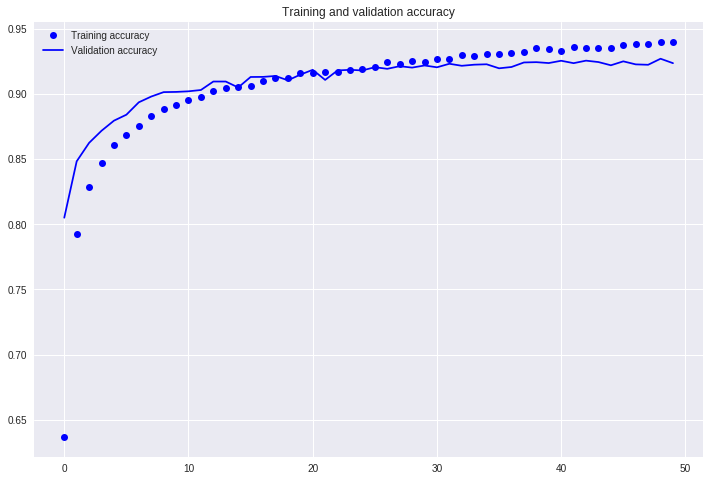

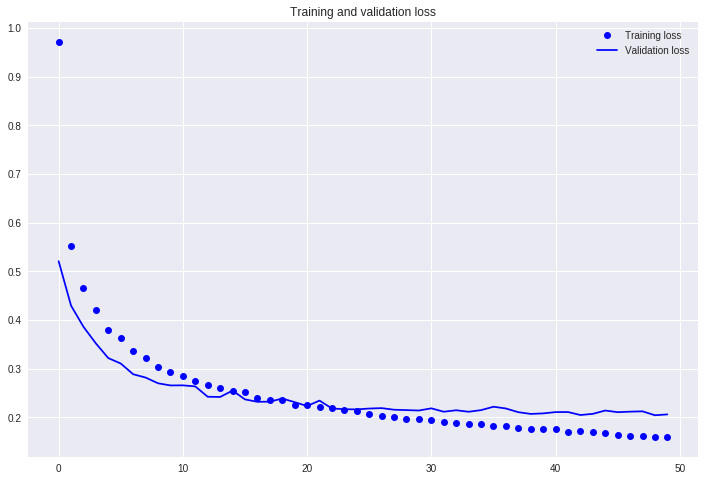

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(12, 8))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()